In [1]:
from IPython.display import Image, display

## Analogy

Consider the following completely made-up scenario: 

There's a country that has many different companies working at many different cities within it.

We also have information of each employee working at each of these companies. All kinds of things like height, names, hair length, tenure, and so on. Because these companies are located in different cities, they each adopt a separate (unknown) cost-of-living adjustment that they apply uniformly to all of their employees. And, for each company, each employee gets the same salary. 

We have a method of getting the salary from the employees but, for contrived reasons, we get a measured value drawn from a Normal distribution centered on their true salary and an estimate of the error (which will be different for each salary). Again, we get 2 numbers when we get the salary information: the salary and an estimate error. The salary data is heteroskedastic (but we have a good idea of the errors for each number). 

And this data was taken over the past 4 decades.

### Hypothesis

**There is a linear relationship between an employee's height and the relative salary at each of these companies.**

If this turns out to be the case, then, this is a **huge deal** (Nobel prize winning deal). Let's just add that at this point, the relationship has to be a straight line in salary vs height space, in that, if this hypothesis were correct, it would appear as a straight line (of any slope/intercept) in this plot (assuming no other systematic errors).

So, a group of researchers takes the salary data for all companies in the Northern part of the country, and the employee's height data for each company, and fits a straight line to the data. They report the slope of each line and an estimated error on the fit, and they find significant non-zero slopes across the ensemble of these measurements. 

Here's an example of the kind of fit being done:

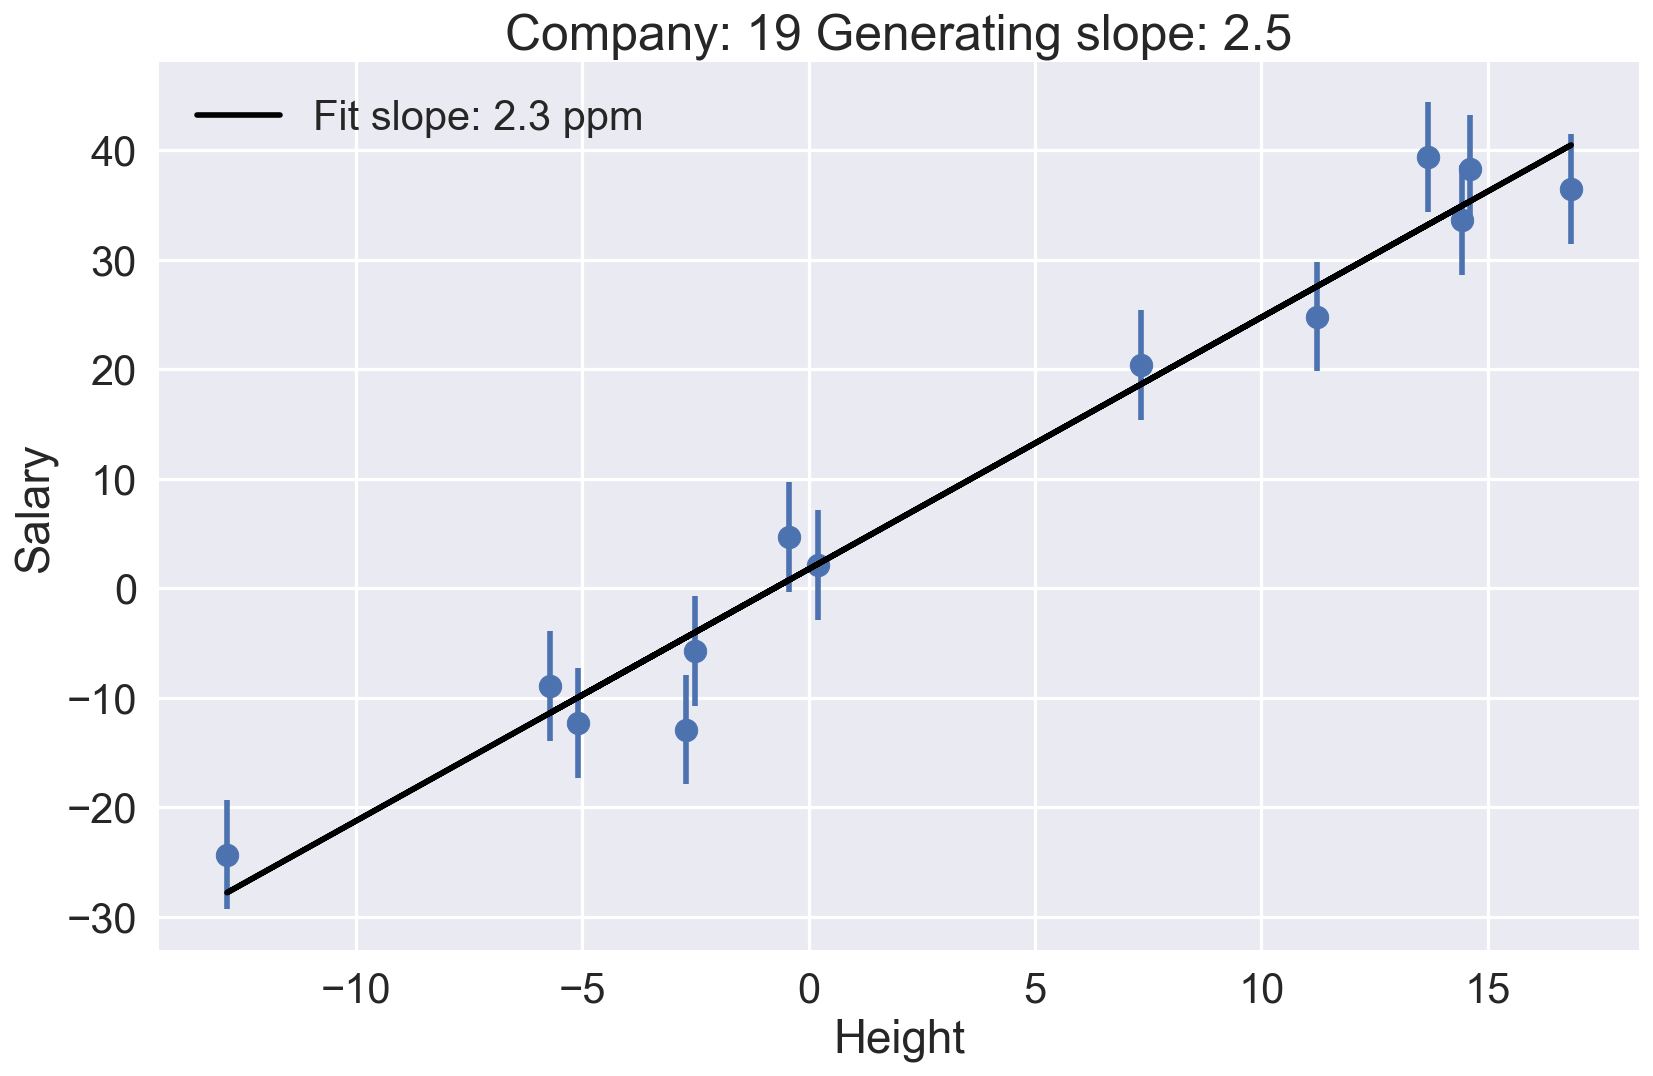

In [166]:
plot_example_company(company=19, daa=2.5)

The above plot was generated for company number 19, with a slope of 2.5, and a best fit line is clearly a decent fit to the data. They made 140 measurements across the Northern half of the country. Reporting the slopes and errors for each company. The data looks like:

In [195]:
keck[['delta_alpha', 'error_delta_alpha']].rename(columns={'delta_alpha':'slope', 'error_delta_alpha':'error'}).head()

slope  error
0   0.34   7.27
1  36.05  39.54
2 -12.53  11.67
3 -78.43  35.48
4 -31.05  24.33

A bunch of other information was recorded at the same time (when the measurement was made, and so on). So they summarized the results across 140 companies by plotting the slope value vs when measurement was made (because if there were some height-bias in the different salaries, it might have changed over time). Remember the expected relationship for this plot should be a bunch of (statistical) zeros.

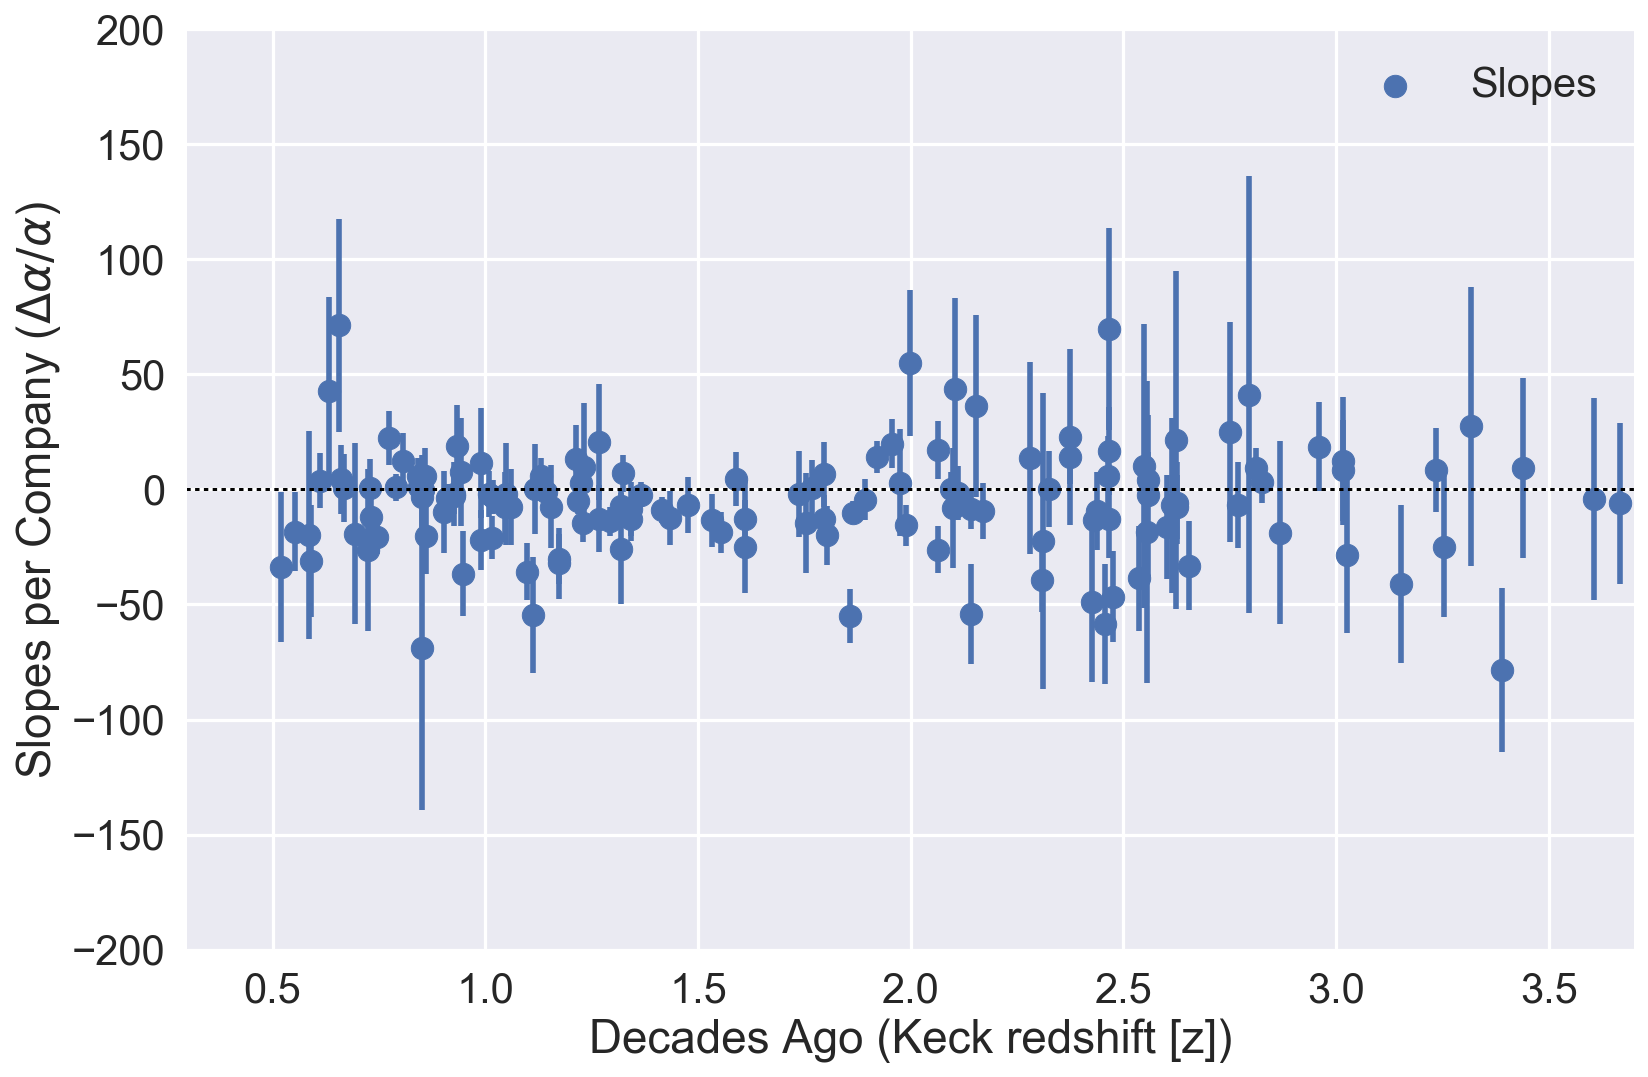

In [196]:
plot_example_telescope_results()

In [217]:
# np.average(keck.delta_alpha, weights=1.0 / keck.extra_error_delta_alpha**2.0)
# np.sqrt(1.0 / np.sum(1.0 / keck.extra_error_delta_alpha**2.0))

Taking a weighted mean of all slope measurements, they found a non-zero result of -5.7 $\pm$ 1.1 ppm. To look for a relationship with time, they took a weighted mean of measurements in time, binned so that each bin would contain roughly an equal number of companies. The next 2-panel plot shows the individual measurements in the upper panel colored to correspond with the color their weighted bin on the lower panel. (The horizontal lines on the upper panel denote the limits on the y-axis for the lower panel). 

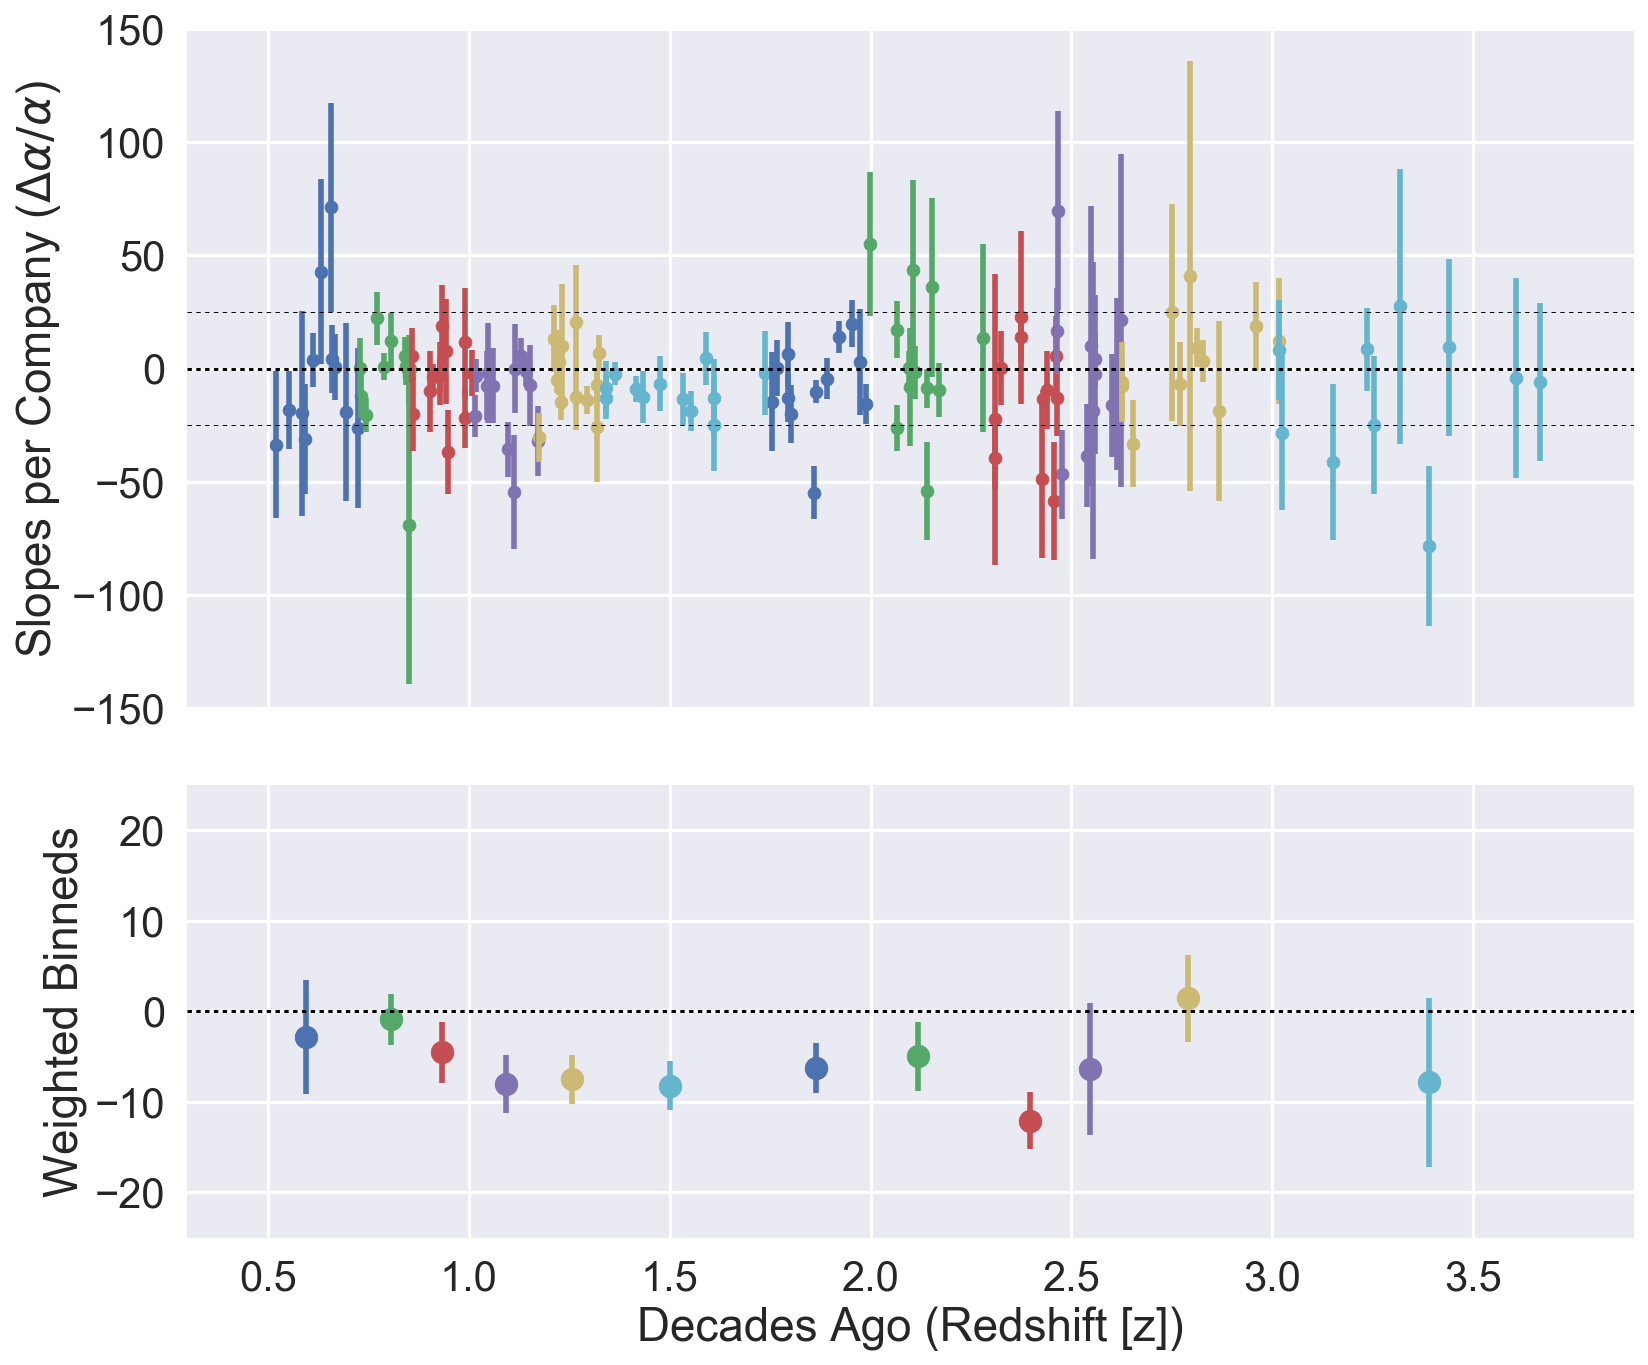

In [216]:
plot_example_telescope_bins(nbins=12, dataframe=keck)

This looks very interesting! But we only looked at the Northern half of the country. Another team of researchers went off to measure the Southern half. And they found the following:

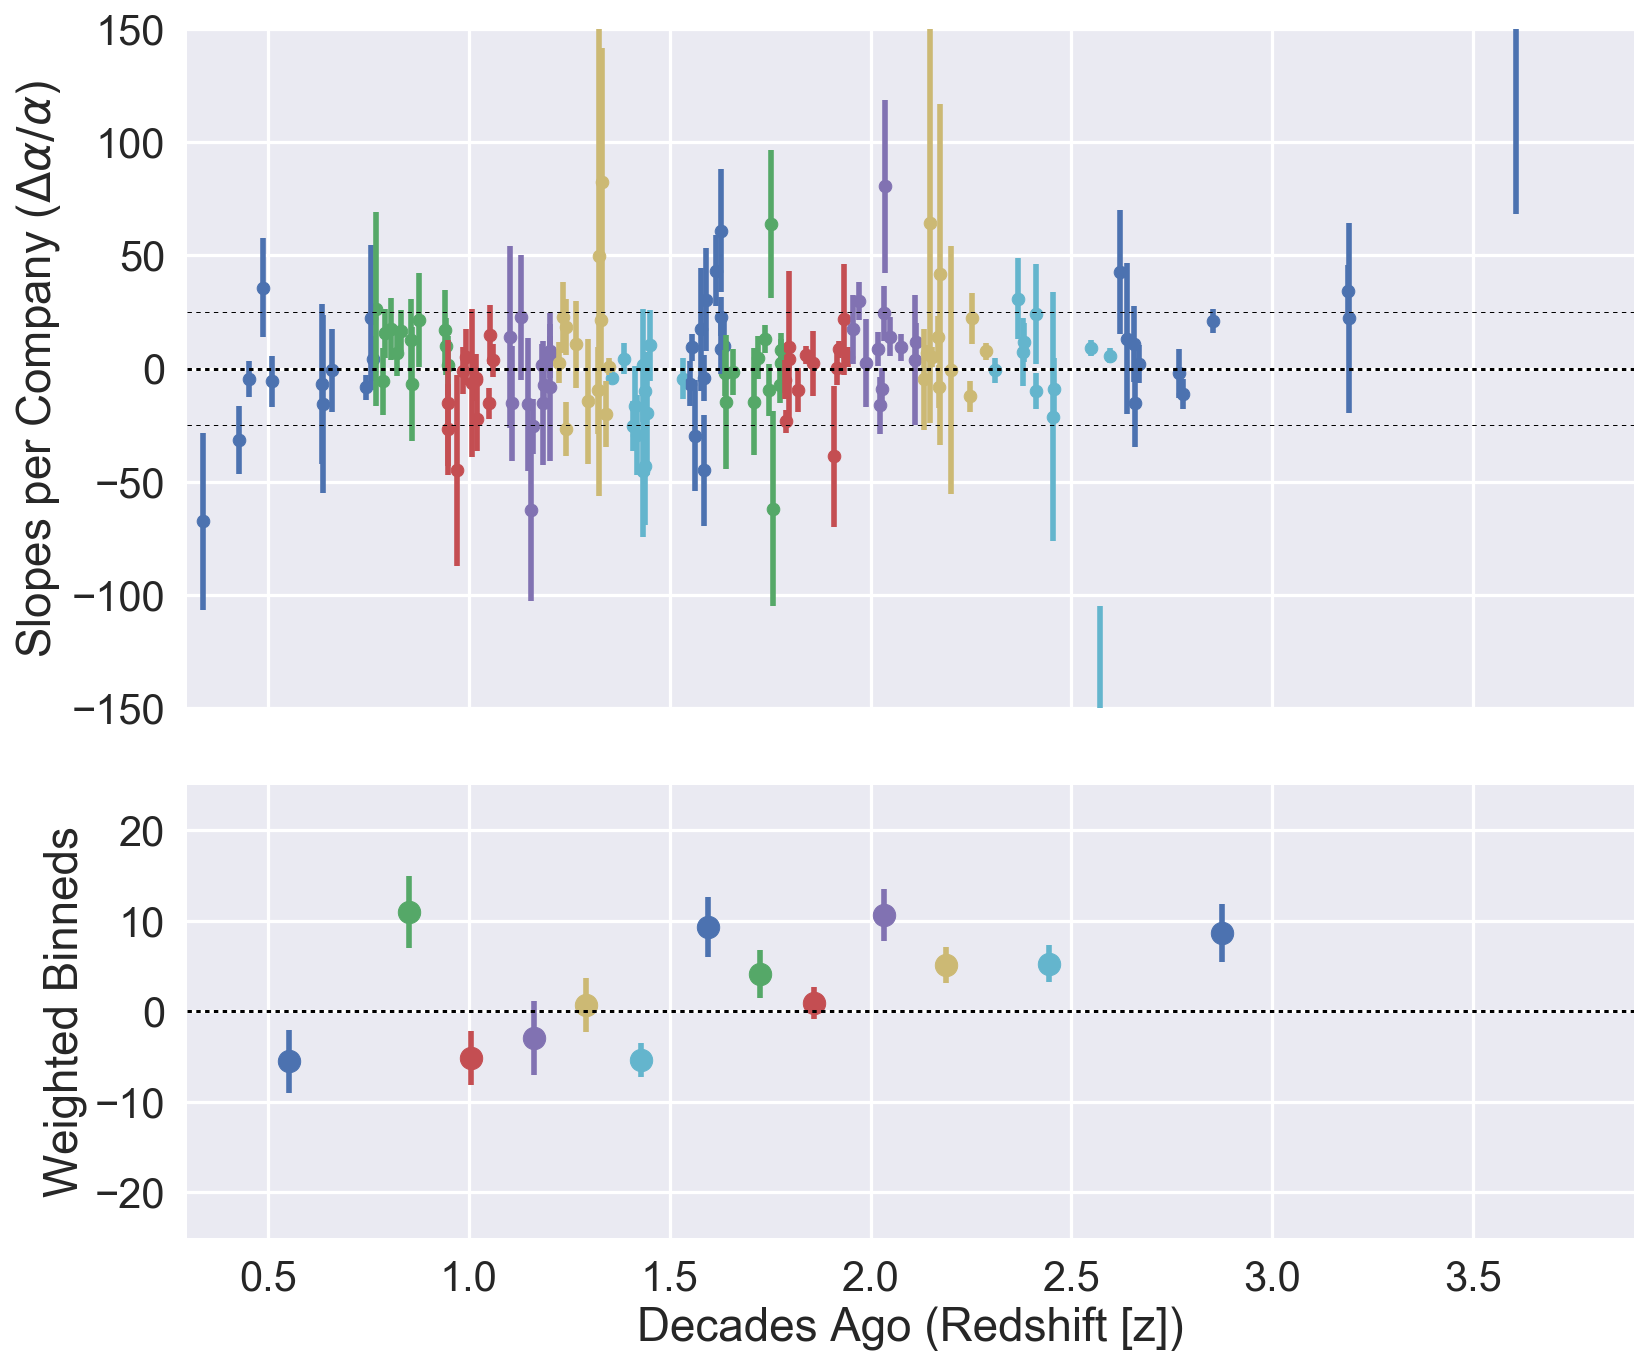

In [224]:
plot_example_telescope_bins(nbins=13, dataframe=vlt)

A surprising result! The weighted bins are no longer uniformly negative, but appear to switch from negative to positive around 1.5 decades ago. Because the data include the lat/longitude of each of these companies, they went to see if they could fit a model that took into account spatial differences. Basically, if you want to think of this semi-accurately, the country is around an entire planet, with companies appearing at specific locations. And there is a gradient across the whole planet that can be thought of in terms of Latitude alone. The fitting model is technically called a dipole, so I will call it a dipole fit.

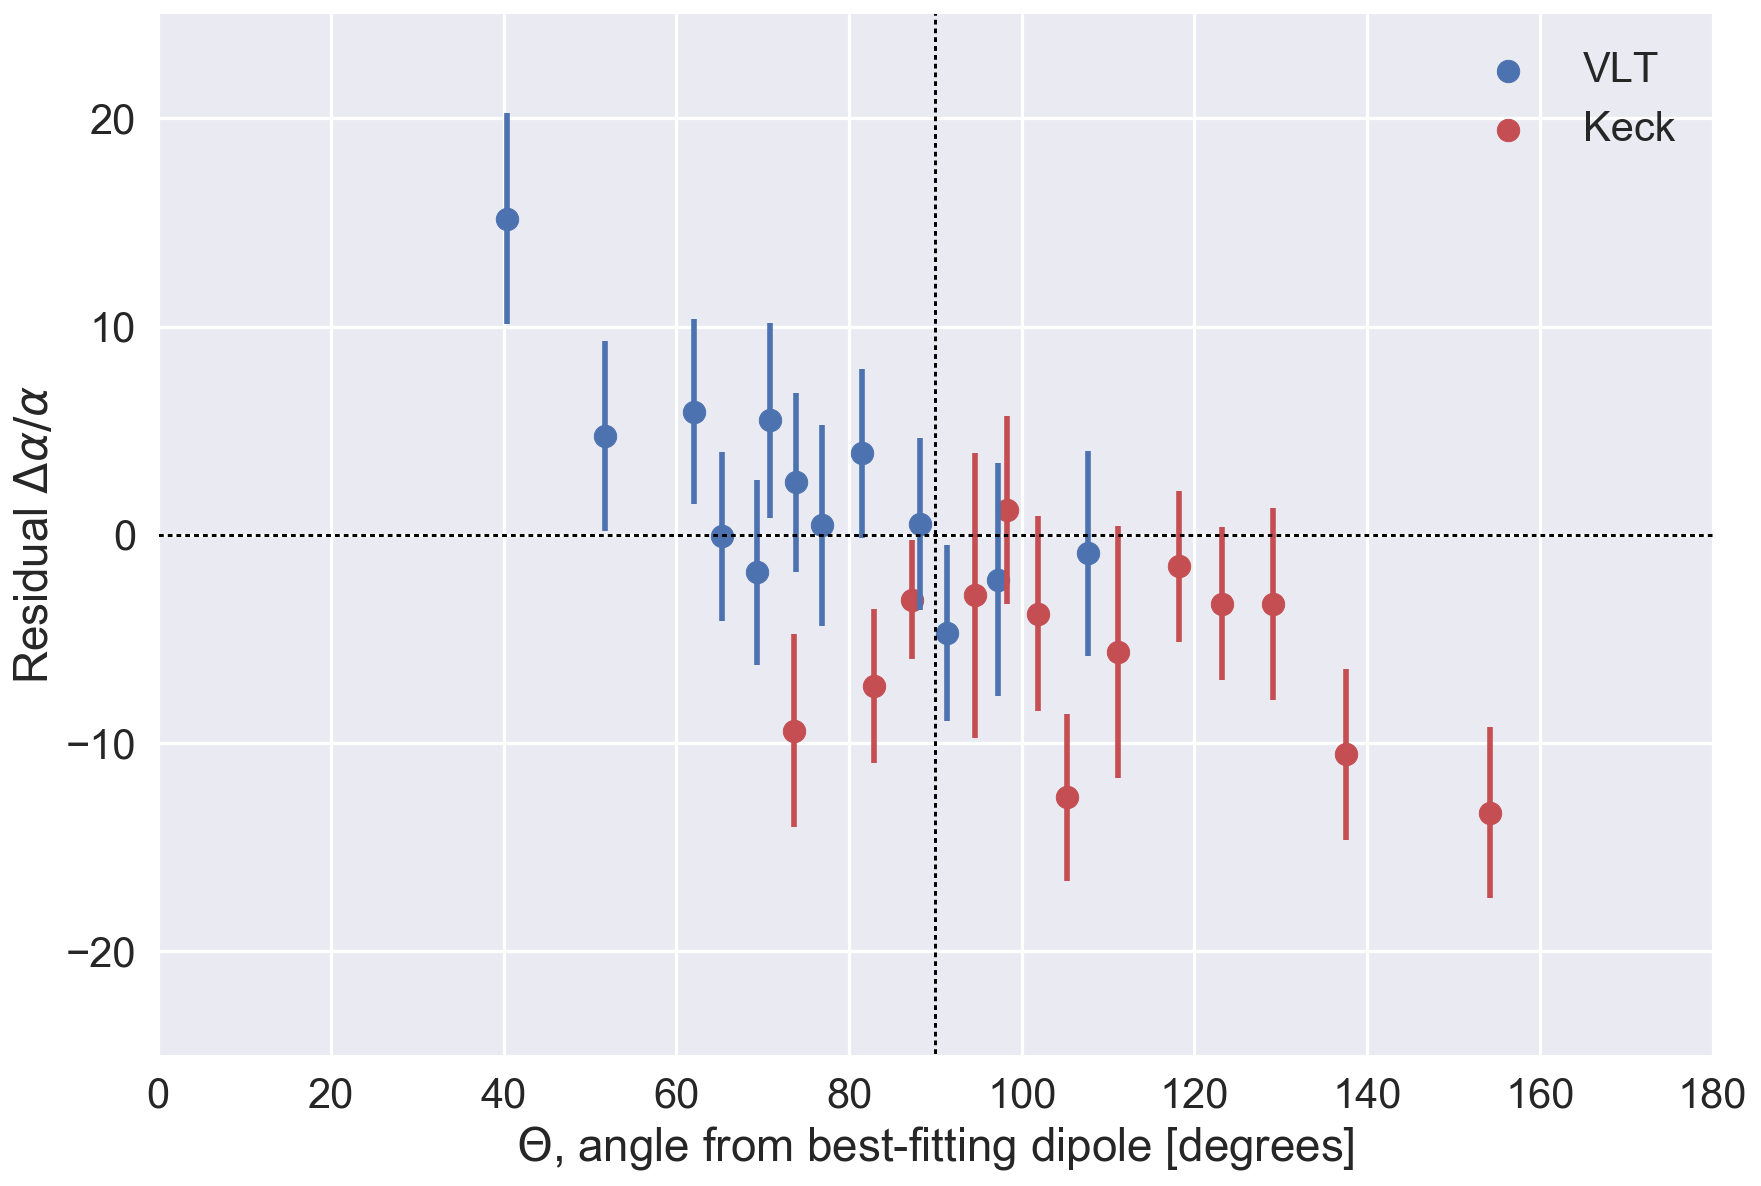

In [241]:
plot_a_v_theta(vlt, color=0, nbins=13, label='VLT')
plot_a_v_theta(keck, color=2, nbins=13, label='Keck')

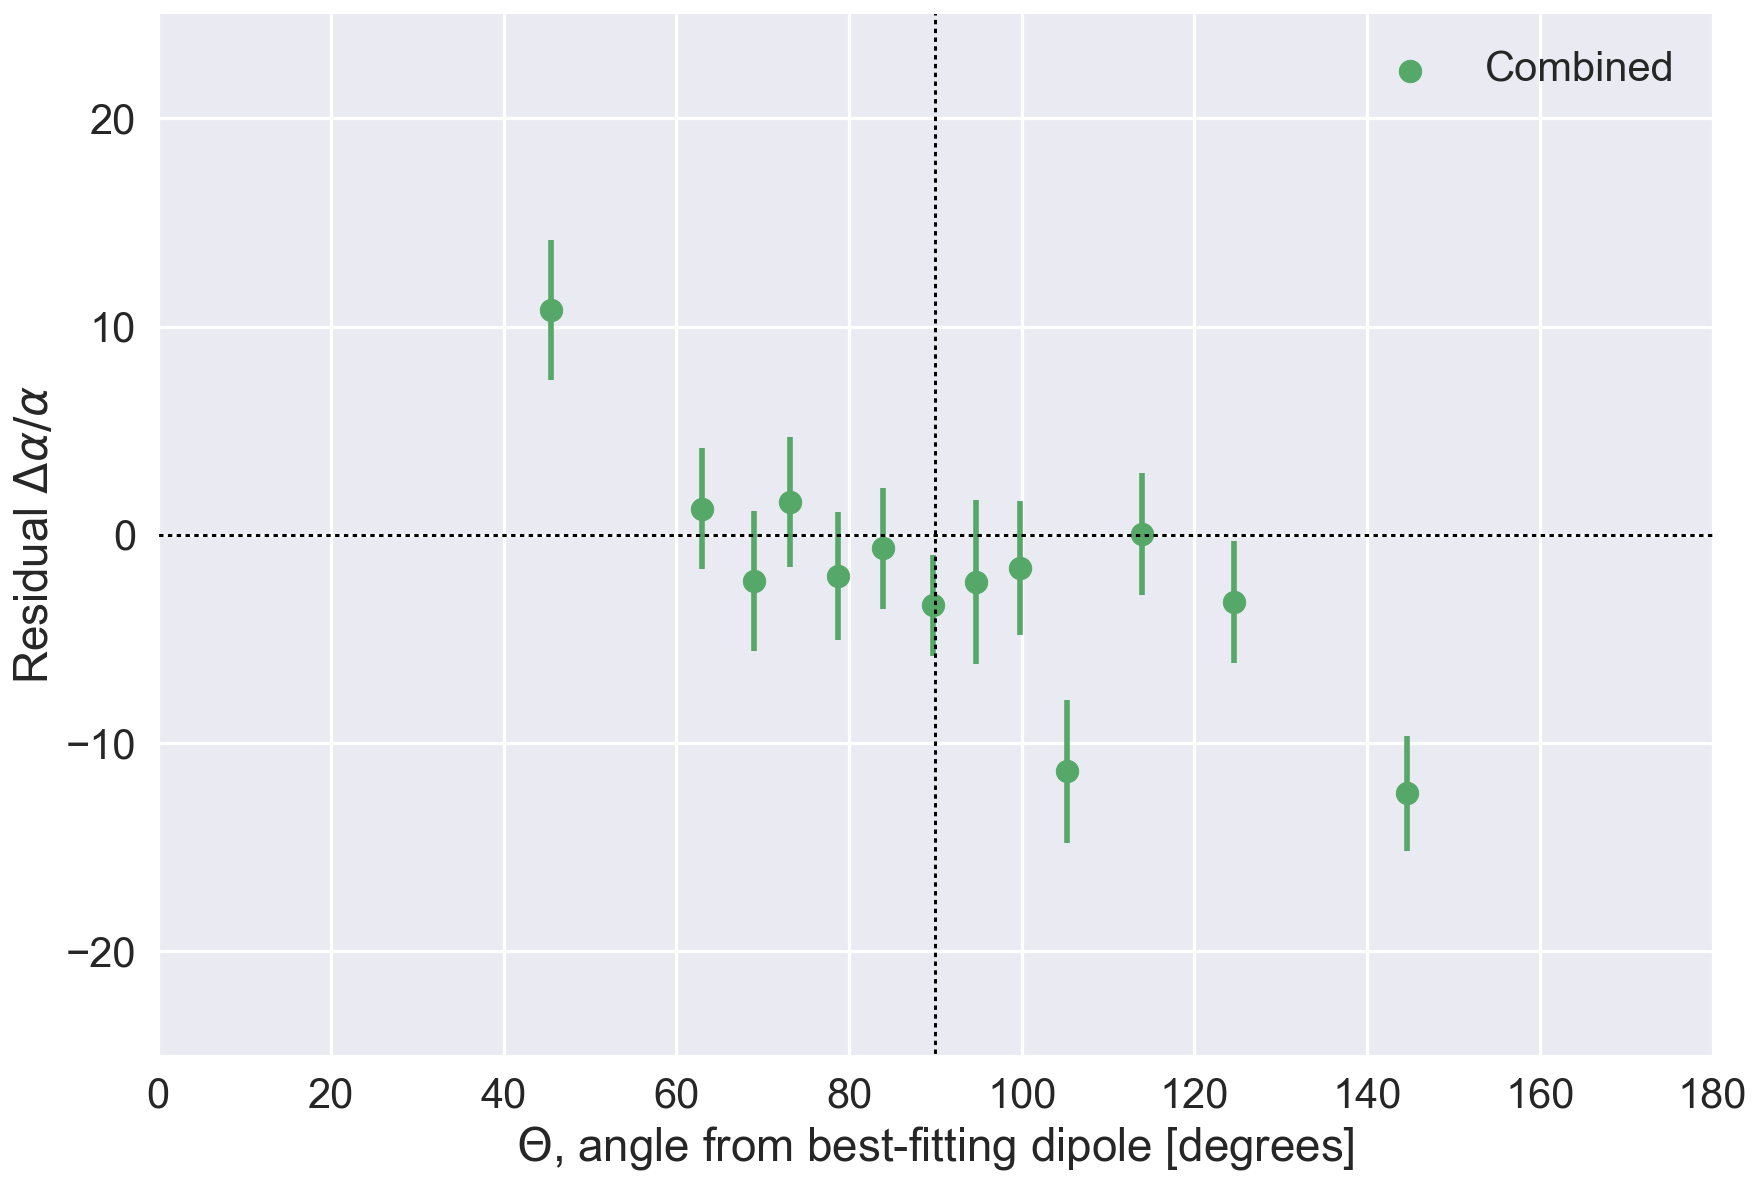

In [242]:
plot_a_v_theta(all_systems, color=1, nbins=13, label='Combined')

## A small wrinkle

Another group of scientists discovers a systematic error in the way the salary measurements are being made. Not only do we have height, salary, and location data, we also have each employee's hair length. It turns out that there is no relationship between height and hair length (just like in the real world). 

However, for even further contrived reasons, the systematic error between an employee's hair length and their measured salary! Just to provide a mental model of what happens, try to stomach the following example. For the Southern companies, they use 2 rulers to measure the length of an employee's hair, one for if their hair is less than say... 5 cm, and another one for if their hair is longer than 5 cm. The Northern companies use 1 ruler to measure their employee's hair. 

The thing is, for all of these rulers, on a per-company basis, they might introduce a systematic error in the recorded . The good news is that if there's an error, it's reasonably well-behaved. So, for the 2-ruler system, you'd have something that might look like: 

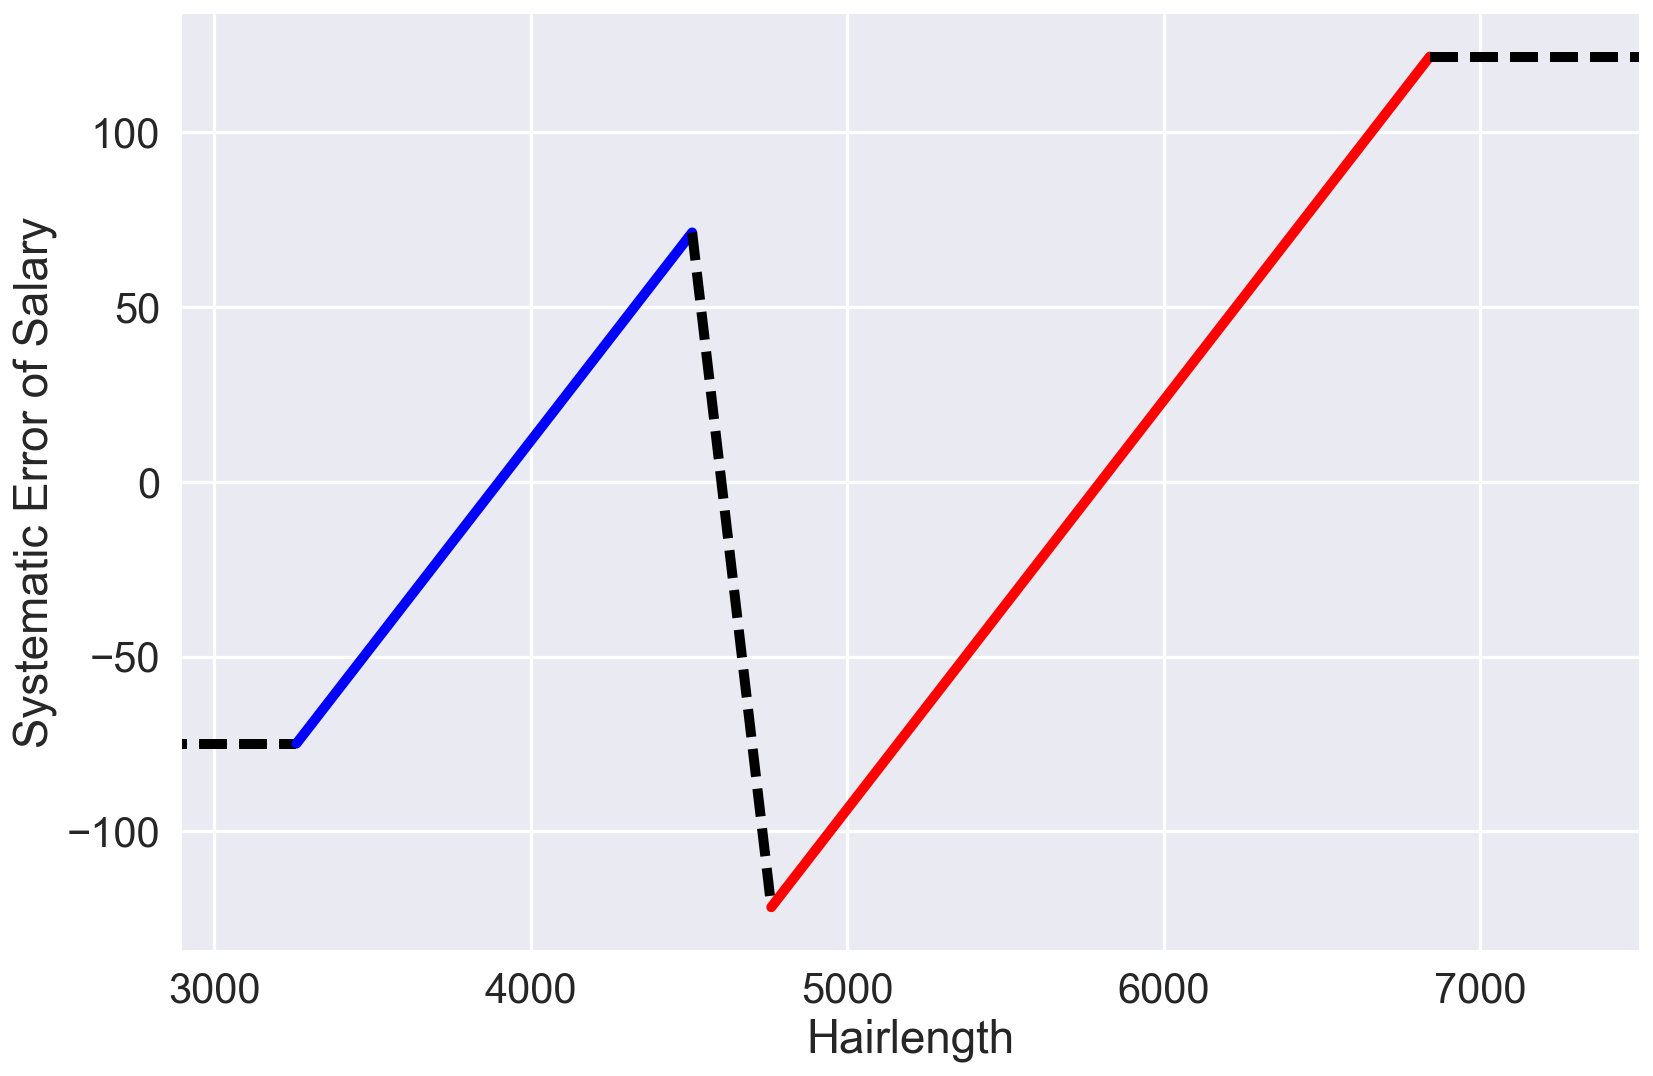

In [278]:
plot_example_systematic(run17)

Where the two rulers show up clearly as two lines w/ roughly the same slope. The y-intercept of this is meaningless, as we only can ever know the relative salary differences per company. 

# STOP HERE

In [340]:
def generate_sigmas(vshifts):
    return np.random.rand(len(vshifts)) * 30.0 + 50.0

def create_blank_transitions_dataset():
    df = pd.DataFrame(columns=['system',
                               'J2000',
                               'source',
                               'wavelength',
                               'vshift', 
                               'sigma', 
                               'qval',
                               'rest_wave',
                              ])
    count = 0
    abs_count = 0
    for index, row in all_systems.iterrows():
        waves = []
        rest_waves = []
        vshifts = []
        qvals_list = []
        for tran in row['transitions'].split():
            vshift = 0.0
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.z_absorption)
            qval = qvals.loc[codes.loc[tran].trans].qval
            waves.append(measured_wave)
            rest_waves.append(rest_wave)
            vshifts.append(vshift)
            qvals_list.append(qval)
        vshifts = np.array(vshifts)
        errors = generate_sigmas(vshifts)
#         vshifts += errors * np.random.randn(len(vshifts))
#         vshifts = vshifts - vshifts[0]
        for single in range(len(vshifts)):
            abs_count += 1
            df.loc[abs_count] = [int(index), #system
                                 row['J2000'],
                                 row.source,
                                 waves[single], #wavelength 
                                 vshifts[single],
                                 errors[single],
                                 qvals_list[single], # qvalues
                                 rest_waves[single],
                                ]
    df['system'] = df.system.astype(int)
    # For numerical stability during fitting, dividing the x-values by 1.0e14
    df['x'] = -2.0 * c * df['qval'] * df['rest_wave'] / 1.0e14
    return df

In [377]:
temp_transitions = create_blank_transitions_dataset()

In [366]:
def fit_alpha(dataframe):
    """Takes a dataframe of transitions and returns a systems dataframe w/ best fit sim_fit_alpha."""
    new_df = all_systems.copy()
    new_df['sim_fit_alpha'] = -1.0
    for index, dfg in dataframe.groupby('system'):
        design_matrix = sm.add_constant(dfg.x)
        results = sm.WLS(dfg.vshift, design_matrix, weights=1.0/dfg.sigma).fit()
        chisq = np.sum((dfg.vshift - results.fittedvalues)**2.0 / (dfg.sigma) ** 2.0)
        const, slope = results.params
        new_df['sim_fit_alpha'].iloc[index] = slope
    return new_df

In [386]:
distortion_1 = run17.copy()

In [400]:
for trans in vlt[vlt.J2000.str.startswith('J043037')]['transitions']:
    trans = trans.split()
    for tran in trans:
        print(tran, codes.loc[tran].trans)

a2 MgI2852
j1 FeII1608
j2 FeII1611
j3 FeII2260
j4 FeII2344
j5 FeII2374
j6 FeII2382
j7 FeII2586
j8 FeII2600
c1 AlII1670
e1 SiII1526
e2 SiII1808
h1 CrII2056
h3 CrII2066
k1 NiII1709
k2 NiII1741
k3 NiII1751
i1 MnII2576
i2 MnII2594
i3 MnII2606


In [473]:
temp.head()

wav_min  midpoint  wav_max
chip                            
B346   3024.5   3454.25   3884.0
B390   3259.1   3888.95   4518.8
B437   3732.4   4365.90   4999.4
R564   4583.5   5634.90   6686.3
R760   5655.8   7559.70   9463.6

In [ ]:
def coadd_distortion():
    

In [ ]:
parser = argparse.ArgumentParser(description='Creates a UVES distortion')

parser.add_argument('--red_arm_slope',
                    help='In km/s/1000A (numbers like 0.175)',
                    required=False,
                    default=0.175,
                    type=float)
parser.add_argument('--red_arm_intercept',
                    help='In m/s (numbers like 175)',
                    required=False,
                    default=None,
                    type=float)

parser.add_argument('--blue_arm_slope',
                    help='In km/s/1000A (numbers like 0.175)',
                    required=False,
                    default=0.175,
                    type=float)
parser.add_argument('--blue_arm_intercept',
                    help='In m/s (numbers like 175.0)',
                    required=False,
                    default=None,
                    type=float)

parser.add_argument('--switchpoint',
                    help='In Angstroms (numbers like 5000)',
                    required=False,
                    default=None,
                    type=float)

# parser.add_argument('--blue_arm_setting', help='Blue arm setting (390)', required=False, default=390, type=int)
# parser.add_argument('--red_arm_setting', help='Red arm setting (580)', required=False, default=580, type=int)

parser.add_argument('--check_if_run', help='', required=False, default=True, type=bool)

parser.add_argument('--json_filename', help='', required=False, default="run.20.json", type=str)

args = vars(parser.parse_args())

json_filename = args['json_filename']

# Put the distortion slope in km s^{-1} per 1000\AA.
# Each arm can have a different slope.
blue_arm_slope = args['blue_arm_slope']
red_arm_slope = args['red_arm_slope']

# if args['blue_arm_setting'] == 390:
blue_arm_midpoint = 3900.0
blue_arm_starting = 3260.0
blue_arm_ending = args['switchpoint']
# elif args['blue_arm_setting'] == 437:
#     # 437 373.24 - 499 nm
#     blue_arm_midpoint = 4370.0
#     blue_arm_starting = 3730.0
#     blue_arm_ending = 4999.0
# else:
#     raise

# if args['red_arm_setting'] == 580:
#     # 580 476 - 684 nm
red_arm_midpoint = 5800.0
red_arm_starting = args['switchpoint'] + 200.0
red_arm_ending = 9840.0
# elif args['red_arm_setting'] == 760:
#     # 760 565.58 - 946.36 nm
#     red_arm_midpoint = 7600.0
#     red_arm_starting = 5655.0
#     red_arm_ending = 9464.0
# else:
#     raise

if args['blue_arm_intercept'] == None:
    blue_arm_intercept = 250
else:
    blue_arm_intercept = args['blue_arm_intercept']
if args['red_arm_intercept'] == None:
    red_arm_intercept = 250
else:
    red_arm_intercept = args['red_arm_intercept']

##############

def offset_from_slope(slope, x_intercept):
    """For a given x-axis intercept and slope, return the offset"""
    return -slope * x_intercept

# correction = -(blue_arm_midpoint * blue_arm_slope + blue_arm_intercept)

#     ax3.plot(blue_wav, blue_wav * slope + blue_int + correction, c='b')
#     ax3.plot(red_wav, red_wav * slope + red_int + correction, c='r')

# Look up the blue or red arm wavelength starting/ending values here:
# http://www.eso.org/observing/etc/bin/gen/form?INS.NAME=UVES+INS.MODE=spectro
region = {}

index = 1
region[index] = {}
# blue arm
region[index]['waves_start'] = blue_arm_starting
region[index]['waves_end'] = blue_arm_ending
region[index]['quad'] = 0.0
region[index]['slope'] = blue_arm_slope
region[index]['offset'] = offset_from_slope(region[index]['slope'], blue_arm_midpoint)

index = 3
# red arm
region[index] = {}
region[index]['waves_start'] = red_arm_starting
region[index]['waves_end'] = red_arm_ending
region[index]['quad'] = 0.0
region[index]['slope'] = red_arm_slope
region[index]['offset'] = offset_from_slope(region[index]['slope'], red_arm_midpoint) + (red_arm_intercept - blue_arm_intercept)


index = 0
# before blue arm
region[index] = {}
region[index]['waves_start'] = 0.0
region[index]['waves_end'] = blue_arm_starting
region[index]['quad'] = 0.0
region[index]['slope'] = 0.0
region[index]['offset'] = region[1]['quad'] * region[1]['waves_start'] ** 2.0 + \
                          region[1]['waves_start'] * region[1]['slope'] + \
                          region[1]['offset']

index = 2
# between blue and red arm
# endpoint of blue arm
x1 = region[1]['waves_end']
y1 = region[1]['quad'] * x1 ** 2.0 + \
          x1 * region[1]['slope'] + \
          region[1]['offset']

# beginning point of red arm

x2 = region[3]['waves_start']
y2 = region[3]['quad'] * x2 ** 2.0 + \
          x2 * region[3]['slope'] + \
          region[3]['offset']

slope = (y2 - y1) / (x2 - x1)
intercept = y1 - slope * x1

region[index] = {}
region[index]['waves_start'] = blue_arm_ending
region[index]['waves_end'] = red_arm_starting
region[index]['quad'] = 0.0
region[index]['slope'] = slope
region[index]['offset'] = intercept

index = 4
# after red arm
region[index] = {}
region[index]['waves_start'] = red_arm_ending
region[index]['waves_end'] = 10000.0
region[index]['quad'] = 0.0
region[index]['slope'] = 0.0
region[index]['offset'] = region[3]['quad'] * region[3]['waves_end'] ** 2.0 + \
                          region[3]['waves_end'] * region[3]['slope'] + \
                          region[3]['offset']


with open(json_filename, 'w') as file_handle:
    json.dump(region.items(), file_handle, sort_keys=True, indent=4)


####
## Read the resulting file with something like the following code:
#
# json_filename = "run.01.json"
# with open(json_filename, 'r') as file_handle:
#     region_dictionary = dict(json.load(file_handle))
# import matplotlib.pyplot as plt
# for index in region_dictionary:
#     begin = region_dictionary[index]['waves_start']
#     end = region_dictionary[index]['waves_end']
#     wavelength = np.linspace(begin, end, 50)
#     quad = region_dictionary[index]['quad']
#     slope = region_dictionary[index]['slope']
#     offset = region_dictionary[index]['offset']
#     if index == 1:
#         color = "blue"
#         linestyle = "-"
#     elif index == 3:
#         color = "red"
#         linestyle = '-'
#     else:
#         color = "black"
#         linestyle = '--'
#     plt.plot(wavelength, quad * wavelength ** 2.0 + wavelength * slope + offset,
#              color=color,
#              linewidth=linewidth,
#              linestyle=linestyle)


In [387]:
distortion_1 = {0: {'offset': -74.88,
  'quad': 0.0,
  'slope': 0.0,
  'waves_end': 3260.0,
  'waves_start': 0.0},
 1: {'offset': -456.3,
  'quad': 0.0,
  'slope': 0.117,
  'waves_end': 4510.0,
  'waves_start': 3260.0},
 2: {'offset': 3553.9919999999997,
  'quad': 0.0,
  'slope': -0.7722,
  'waves_end': 4760.0,
  'waves_start': 4510.0},
 3: {'offset': -678.6,
  'quad': 0.0,
  'slope': 0.117,
  'waves_end': 6840.0,
  'waves_start': 4760.0},
 4: {'offset': 121.68000000000006,
  'quad': 0.0,
  'slope': 0.0,
  'waves_end': 10000.0,
  'waves_start': 6840.0}}

{0: {'offset': -74.88,
  'quad': 0.0,
  'slope': 0.0,
  'waves_end': 3260.0,
  'waves_start': 0.0},
 1: {'offset': -456.3,
  'quad': 0.0,
  'slope': 0.117,
  'waves_end': 4510.0,
  'waves_start': 3260.0},
 2: {'offset': 3553.9919999999997,
  'quad': 0.0,
  'slope': -0.7722,
  'waves_end': 4760.0,
  'waves_start': 4510.0},
 3: {'offset': -678.6,
  'quad': 0.0,
  'slope': 0.117,
  'waves_end': 6840.0,
  'waves_start': 4760.0},
 4: {'offset': 121.68000000000006,
  'quad': 0.0,
  'slope': 0.0,
  'waves_end': 10000.0,
  'waves_start': 6840.0}}

In [376]:
def velocity_shift(wavelength, distortion=run17):
    for segment in distortion:
        if (wavelength > distortion[segment]['waves_start']) and (wavelength <= distortion[segment]['waves_end']):
            slope = distortion[segment]['slope']
            offset = distortion[segment]['offset']
    return -(wavelength * slope + offset)
    

In [378]:
temp_transitions['vshift'] += temp_transitions.wavelength.apply(lambda x: velocity_shift(x))

In [379]:
temp_systems = fit_alpha(temp_transitions)

In [380]:
temp_systems.head()

J2000  z_emission  z_absorption  delta_alpha  error_delta_alpha  \
0  J000149-015940        2.31       2.09510         0.34               7.27   
1  J000149-015940        2.31       2.15390        36.05              39.54   
2  J000322-260316        4.11       1.43420       -12.53              11.67   
3  J000322-260316        4.11       3.38970       -78.43              35.48   
4  J000520+052410        1.90       0.59137       -31.05              24.33   

   extra_error_delta_alpha  dipole_delta_alpha  dipole_angle sample source  \
0                18.885386           -2.377815       93.5334     B1   Keck   
1                39.540000           -2.377815       93.5334     B1   Keck   
2                11.670000            1.115461       72.6324      C   Keck   
3                35.480000            1.115461       72.6324      C   Keck   
4                24.330000           -3.538861      100.4470      C   Keck   

   sigflag  imrotator              transitions  sim_fit_alpha  
0        2          0  d g h i j k l s t u v w       0.313347  
1        1          0                  d f g l       3.350422  
2        1          1                  b c p r      -4.662447  
3        1          1                  d g l m       0.043898  
4        1          0              b c n p q r      -2.897314

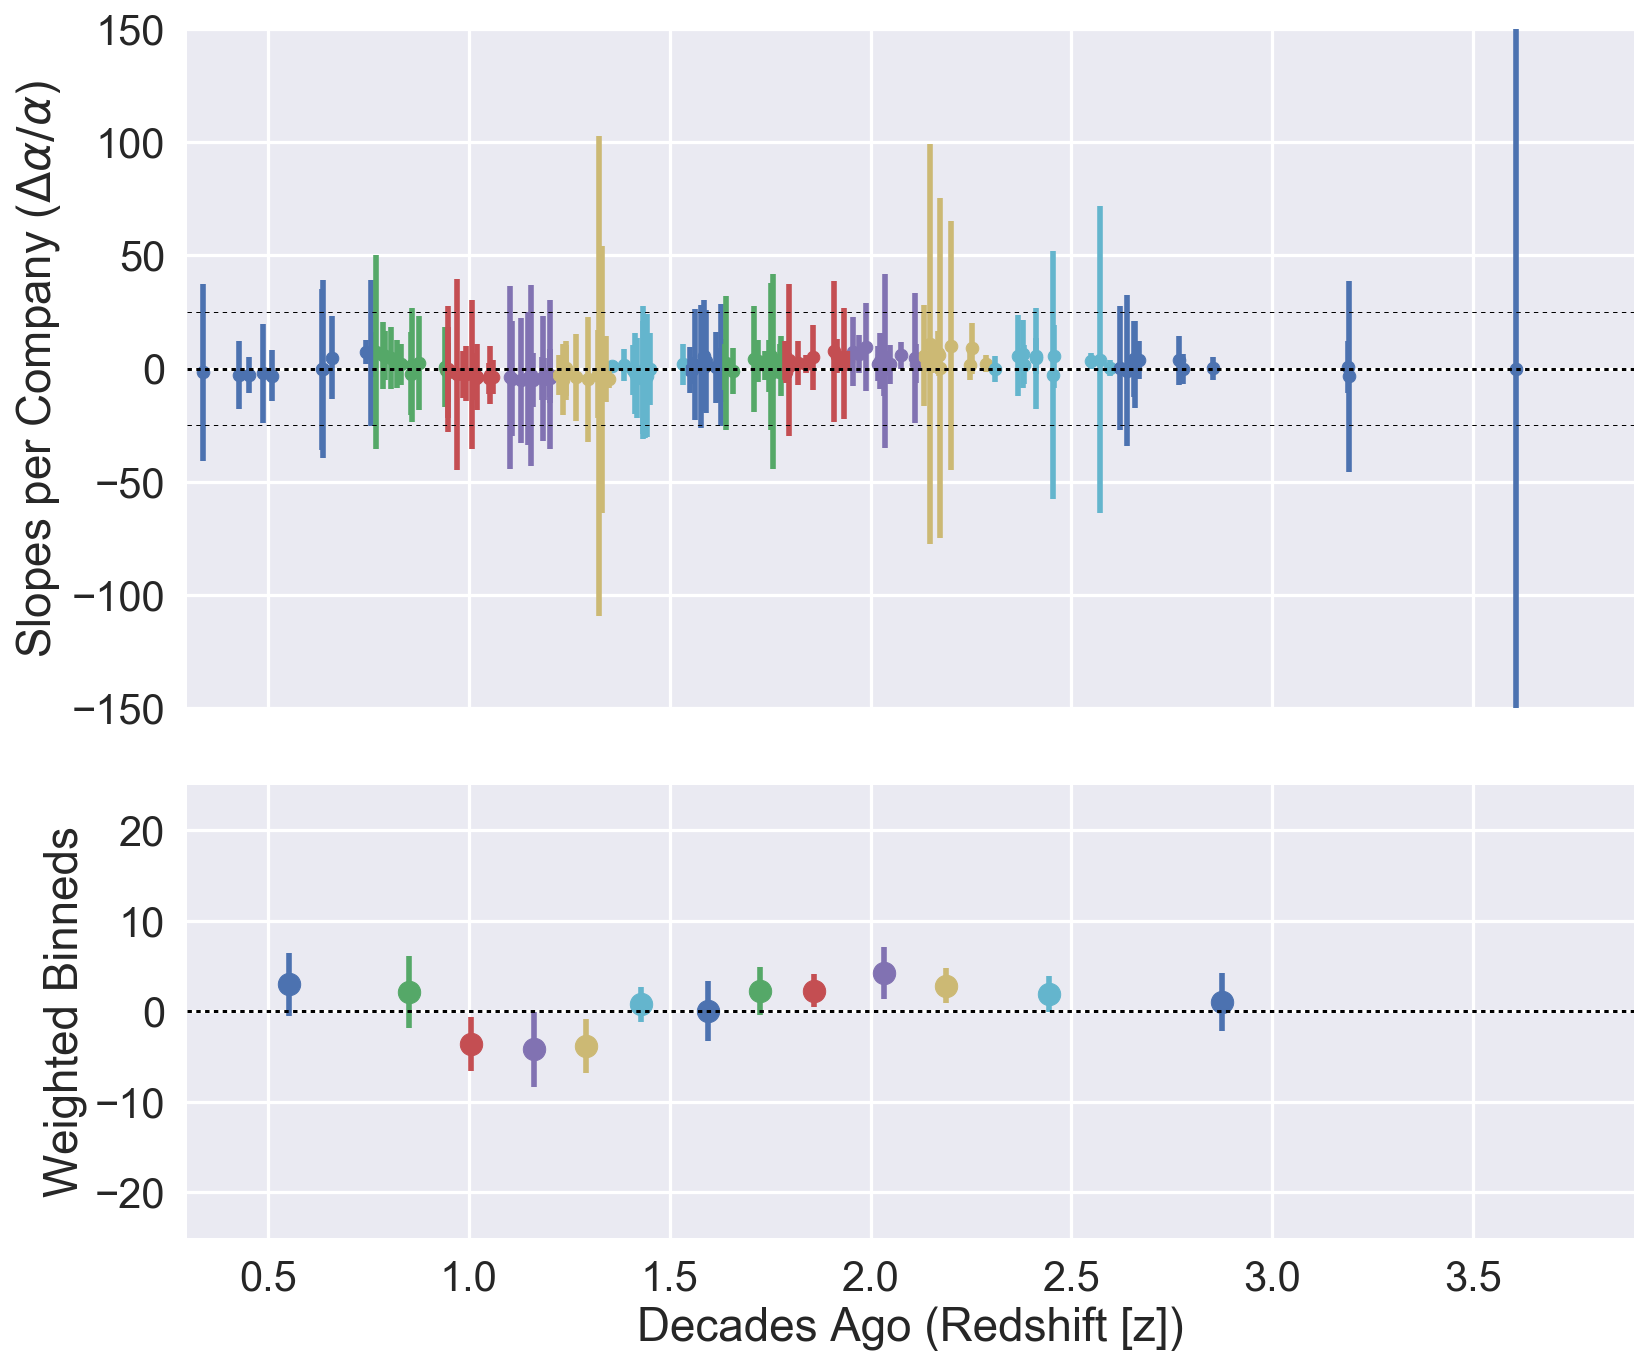

In [381]:
plot_example_telescope_bins(nbins=13, alphacol='sim_fit_alpha', dataframe=temp_systems[temp_systems.source == 'VLT'])

In [ ]:
    row = all_systems.iloc[company]
    df = df_a[df_a.system==company]
    heights = df.x
    design_matrix = sm.add_constant(heights)

    results = sm.WLS(vshifts, design_matrix, weights=1.0/sigmas).fit()
    chisq = np.sum((vshifts - results.fittedvalues)**2.0 / (sigmas) ** 2.0)
    const, slope = results.params

    ax.scatter(heights, vshifts, color=sns.color_palette()[color_index], label='')
    ax.errorbar(heights, vshifts, yerr=sigmas, c=sns.color_palette()[color_index],  ls='none', label='')
    ax.plot(heights, results.fittedvalues, color='k', label='Fit slope: ' + str(round(slope, 2)) + " ppm")
    
    ax.legend(loc='best')
    ax.set_xlabel("Height")
    ax.set_ylabel("Salary")
    ax.set_title("Company: " + str(company) + " Generating slope: " + str(daa))
    fig.tight_layout()

In [ ]:
# def add_wavelength_distortion(dataframe):
#             if gen_dipole_alpha:
#                 vshift += shifted_velocity(row['dipole_delta_alpha'],
#                                            qval,
#                                            rest_wave)
#             if wavelength_distortion:
#                 vshift += distorted_velocity(row, measured_wave)
#             waves.append(measured_wave)
#             rest_waves.append(rest_wave)
#             vshifts.append(vshift)
#             qvals_list.append(qval)
#         vshifts = np.array(vshifts)
#         errors = sigmas(vshifts)
#         vshifts += errors * np.random.randn(len(vshifts))
#         vshifts = vshifts - vshifts[0]
#         for single in range(len(vshifts)):
#             abs_count += 1
#             dataframe.loc[abs_count] = [int(index), #system
#                                  row['J2000'],
#                                  row.source,
#                                  waves[single], #wavelength 
#                                  vshifts[single],
#                                  errors[single],
#                                  qvals_list[single], # qvalues
#                                  rest_waves[single],
#                                 ]
#     dataframe['system'] = dataframe.system.astype(int)
#     # For numerical stability during fitting, dividing the x-values by 1.0e14
#     dataframe['x'] = -2.0 * c * dataframe['qval'] * dataframe['rest_wave'] / 1.0e14

#     if len(dataframe) == 0:
        
#     else:
        
#     return dataframe

def generate_dataset(gen_dipole_alpha=True, 
                     wavelength_distortion=False,
                     seed=228,
                    ):
    df = pd.DataFrame(columns=['system',
                               'J2000',
                               'source',
                               'wavelength',
                               'vshift', 
                               'sigma', 
                               'qval',
                               'rest_wave'
                              ])
    count = 0
    abs_count = 0
    for index, row in all_systems.iterrows():
        waves = []
        rest_waves = []
        vshifts = []
        qvals_list = []
        for tran in row['transitions'].split():
            vshift = 0.0
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.z_absorption)
            qval = qvals.loc[codes.loc[tran].trans].qval
            if gen_dipole_alpha:
                vshift += shifted_velocity(row['dipole_delta_alpha'],
                                           qval,
                                           rest_wave)
            if wavelength_distortion:
                vshift += distorted_velocity(row, measured_wave)
            waves.append(measured_wave)
            rest_waves.append(rest_wave)
            vshifts.append(vshift)
            qvals_list.append(qval)
        vshifts = np.array(vshifts)
        errors = sigmas(vshifts)
        vshifts += errors * np.random.randn(len(vshifts))
        vshifts = vshifts - vshifts[0]
        for single in range(len(vshifts)):
            abs_count += 1
            df.loc[abs_count] = [int(index), #system
                                 row['J2000'],
                                 row.source,
                                 waves[single], #wavelength 
                                 vshifts[single],
                                 errors[single],
                                 qvals_list[single], # qvalues
                                 rest_waves[single],
                                ]
    df['system'] = df.system.astype(int)
    # For numerical stability during fitting, dividing the x-values by 1.0e14
    df['x'] = -2.0 * c * df['qval'] * df['rest_wave'] / 1.0e14
    return df

In [215]:
def plot_example_telescope_bins(nbins = 12,
                                alphacol = 'delta_alpha',
                                errorcol = 'error_delta_alpha',
                                binned_lim = 25.0,
                                dataframe=keck,
                               ):
    fig, (ax, ax2) = plt.subplots(figsize=(12, 10), 
                                  nrows=2,
                                  sharex=True,
                                  gridspec_kw={'height_ratios':[1.5,1]},
                                 )


    for index, df in enumerate(np.array_split(dataframe.sort_values('z_absorption'), nbins)):
        color = sns.color_palette(n_colors=13)[index]

        x = df.z_absorption
        y = df[alphacol]
        e = df[errorcol]
        ax.scatter(x, (y), c=color, label='', s=40)
        ax.errorbar(x, (y), yerr=e, c=color,  ls='none', label='')

        x = np.average(df.z_absorption)
        y = np.average(df[alphacol], weights=(1.0 / (df[errorcol] ** 2.0)))
        e = np.sqrt(1.0 / np.sum(1.0 / (df[errorcol] ** 2.0)))
        label=''
        if index == 0:
            label=label
        else:
            label=''
        ax2.scatter(x, y, c=color, label=label)
        ax2.errorbar(x, y, yerr=e, c=color)

    ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
    ax.hlines(binned_lim, -2, 6, linestyles=':', lw=.5, color='k')
    ax.hlines(-binned_lim, -2, 6, linestyles=':', lw=.5, color='k')
    ax2.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')

    ax.set_ylabel(r"Slopes per Company ($\Delta \alpha/\alpha$)")
    ax2.set_ylabel(r"Weighted Binneds")
    ax2.set_xlabel(r"Decades Ago (Redshift [z])")
    ax.legend(loc='best')
    ax.set_xlim(0.3, 3.9)
    ax.set_ylim(-150, 150)
    ax2.set_ylim(-binned_lim, binned_lim)
    fig.tight_layout()


In [339]:
# two data structures: systems and transitions

In [117]:
def fit_hypothesis(system=0, dataframe1=df_a, hypothesis='x'):
    """Return the chisq and the fit model object for a given dataframe and hypothesis."""
    plotdf1 = dataframe1[dataframe1.system == system]
    assert(hypothesis in ['x', 'w'])
    if hypothesis == 'x':
        X = sm.add_constant(plotdf1.x)
    elif hypothesis == 'w':
        X = sm.add_constant(plotdf1.wavelength)
    results = sm.WLS(plotdf1.vshift, X, weights=1.0/plotdf1.sigma).fit()
    chisq = np.sum((plotdf1.vshift - results.fittedvalues)**2.0 / (plotdf1.sigma) ** 2.0)
    return chisq, results

In [164]:
def plot_example_company(company=19, # which system to use
                         daa=2.5, # ppm of generated slope
                        ):

    row = all_systems.iloc[company]
    df = df_a[df_a.system==company]
    heights = df.x

    color_index = 0

    waves = []
    rest_waves = []
    vshifts = []
    qvals_list = []
    for tran in row['transitions'].split():
        vshift = 0.0
        rest_wave = qvals.loc[codes.loc[tran].trans].wave
        measured_wave = rest_wave * (1 + row.z_absorption)
        qval = qvals.loc[codes.loc[tran].trans].qval
        vshift += shifted_velocity(daa,
                                   qval,
                                   rest_wave)

        waves.append(measured_wave)
        rest_waves.append(rest_wave)
        vshifts.append(vshift)
        qvals_list.append(qval)

    waves = np.array(waves)
    rest_waves = np.array(rest_waves)
    vshifts = np.array(vshifts)
    qvals_list = np.array(qvals_list)
    sigmas = np.ones_like(waves) * 5.0
    
    vshifts += sigmas * np.random.randn(len(vshifts))
    fig, ax = plt.subplots(figsize=(12, 8))

    design_matrix = sm.add_constant(heights)

    results = sm.WLS(vshifts, design_matrix, weights=1.0/sigmas).fit()
    chisq = np.sum((vshifts - results.fittedvalues)**2.0 / (sigmas) ** 2.0)
    const, slope = results.params

    ax.scatter(heights, vshifts, color=sns.color_palette()[color_index], label='')
    ax.errorbar(heights, vshifts, yerr=sigmas, c=sns.color_palette()[color_index],  ls='none', label='')
    ax.plot(heights, results.fittedvalues, color='k', label='Fit slope: ' + str(round(slope, 2)) + " ppm")
    
    ax.legend(loc='best')
    ax.set_xlabel("Height")
    ax.set_ylabel("Salary")
    ax.set_title("Company: " + str(company) + " Generating slope: " + str(daa))
    fig.tight_layout()


In [ ]:
def plot_example_telescope_results(dataframe=keck):
    fig, ax = plt.subplots(figsize=(12, 8))
    x = dataframe.z_absorption
    y = dataframe.delta_alpha
    e = dataframe.error_delta_alpha
    color=0
    label='Slopes'
    ax.scatter(x, (y), c=sns.color_palette()[color], label=label)
    ax.errorbar(x, (y), yerr=e, c=sns.color_palette()[color],  ls='none', label='')
    ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
    ax.set_ylabel(r"Slopes per Company ($\Delta \alpha/\alpha$)")
    ax.set_xlabel(r"Decades Ago (Keck redshift [z])")
    ax.legend(loc='best')
    ax.set_xlim(0.3, 3.7)
    ax.set_ylim(-200, 200)
    fig.tight_layout()
    

In [ ]:
def generate_dataset(gen_dipole_alpha=True, 
                     wavelength_distortion=False,
                     seed=228,
                    ):
    df = pd.DataFrame(columns=['system',
                               'J2000',
                               'source',
                               'wavelength',
                               'vshift', 
                               'sigma', 
                               'qval',
                               'rest_wave'
                              ])
    count = 0
    abs_count = 0
    for index, row in all_systems.iterrows():
        waves = []
        rest_waves = []
        vshifts = []
        qvals_list = []
        for tran in row['transitions'].split():
            vshift = 0.0
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.z_absorption)
            qval = qvals.loc[codes.loc[tran].trans].qval
            if gen_dipole_alpha:
                vshift += shifted_velocity(row['dipole_delta_alpha'],
                                           qval,
                                           rest_wave)
            if wavelength_distortion:
                vshift += distorted_velocity(row, measured_wave)
            waves.append(measured_wave)
            rest_waves.append(rest_wave)
            vshifts.append(vshift)
            qvals_list.append(qval)
        vshifts = np.array(vshifts)
        errors = sigmas(vshifts)
        vshifts += errors * np.random.randn(len(vshifts))
        vshifts = vshifts - vshifts[0]
        for single in range(len(vshifts)):
            abs_count += 1
            df.loc[abs_count] = [int(index), #system
                                 row['J2000'],
                                 row.source,
                                 waves[single], #wavelength 
                                 vshifts[single],
                                 errors[single],
                                 qvals_list[single], # qvalues
                                 rest_waves[single],
                                ]
    df['system'] = df.system.astype(int)
    # For numerical stability during fitting, dividing the x-values by 1.0e14
    df['x'] = -2.0 * c * df['qval'] * df['rest_wave'] / 1.0e14
    return df


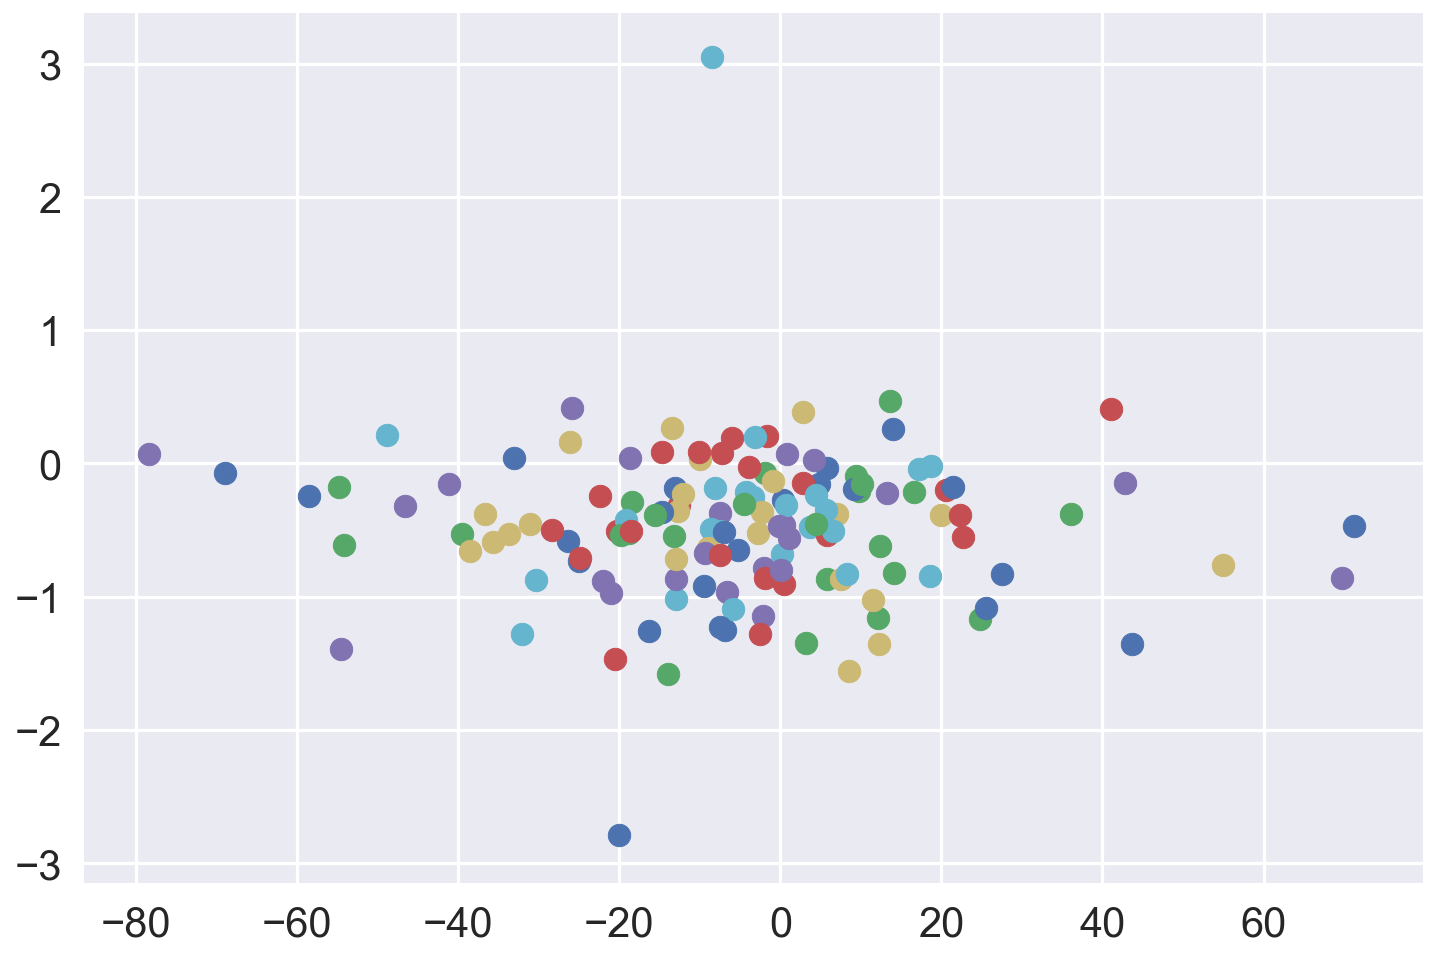

In [114]:
fig, ax = plt.subplots(figsize=(12, 8))
for company in keck.index:
    chisq, results = fit_hypothesis(system=company, dataframe1=df_a, hypothesis='x')
    results.params.x
    ax.scatter(keck.iloc[company].delta_alpha, results.params.x)

In [277]:
def read_systematic(infile='../data/run.17.json'):
    """Read systematic error file."""
#     with open('../data/run.17.json', 'w') as fp:
#         json.dump(run17, fp, indent=4, sort_keys=True)
    with open(infile, 'r') as fp:
        temp = dict(json.load(fp))
    return temp

run17 = {int(k):v for k, v in temp.items()}

def plot_example_systematic(region_dictionary=run17):
    color = "black"
    linewidth = 5.0
    fig, ax = plt.subplots(figsize=(12, 8))
    for index in region_dictionary:
        begin = region_dictionary[index]['waves_start']
        end = region_dictionary[index]['waves_end']
        wavelength = np.linspace(begin, end, 50)
        quad = region_dictionary[index]['quad']
        slope = region_dictionary[index]['slope']
        offset = region_dictionary[index]['offset']
        if index == 1:
            color = "blue"
            linestyle = "-"
        elif index == 3:
            color = "red"
            linestyle = '-'
        else:
            color = "black"
            linestyle = '--'
        ax.plot(wavelength, quad * wavelength ** 2.0 + wavelength * slope + offset,
                 color=color, 
                 linewidth=linewidth, 
                 linestyle=linestyle)

    ax.set_xlim(2900, 7500)
    ax.set_xlabel("Hairlength")
    ax.set_ylabel("Systematic Error of Salary")
    fig.tight_layout()

In [89]:
keck[keck.J2000.eq("J000149-015940")]

J2000  z_emission  z_absorption  delta_alpha  error_delta_alpha  \
0  J000149-015940        2.31        2.0951         0.34               7.27   
1  J000149-015940        2.31        2.1539        36.05              39.54   

   extra_error_delta_alpha  dipole_delta_alpha  dipole_angle sample source  \
0                18.885386           -2.377815       93.5334     B1   Keck   
1                39.540000           -2.377815       93.5334     B1   Keck   

   sigflag  imrotator              transitions  
0        2          0  d g h i j k l s t u v w  
1        1          0                  d f g l

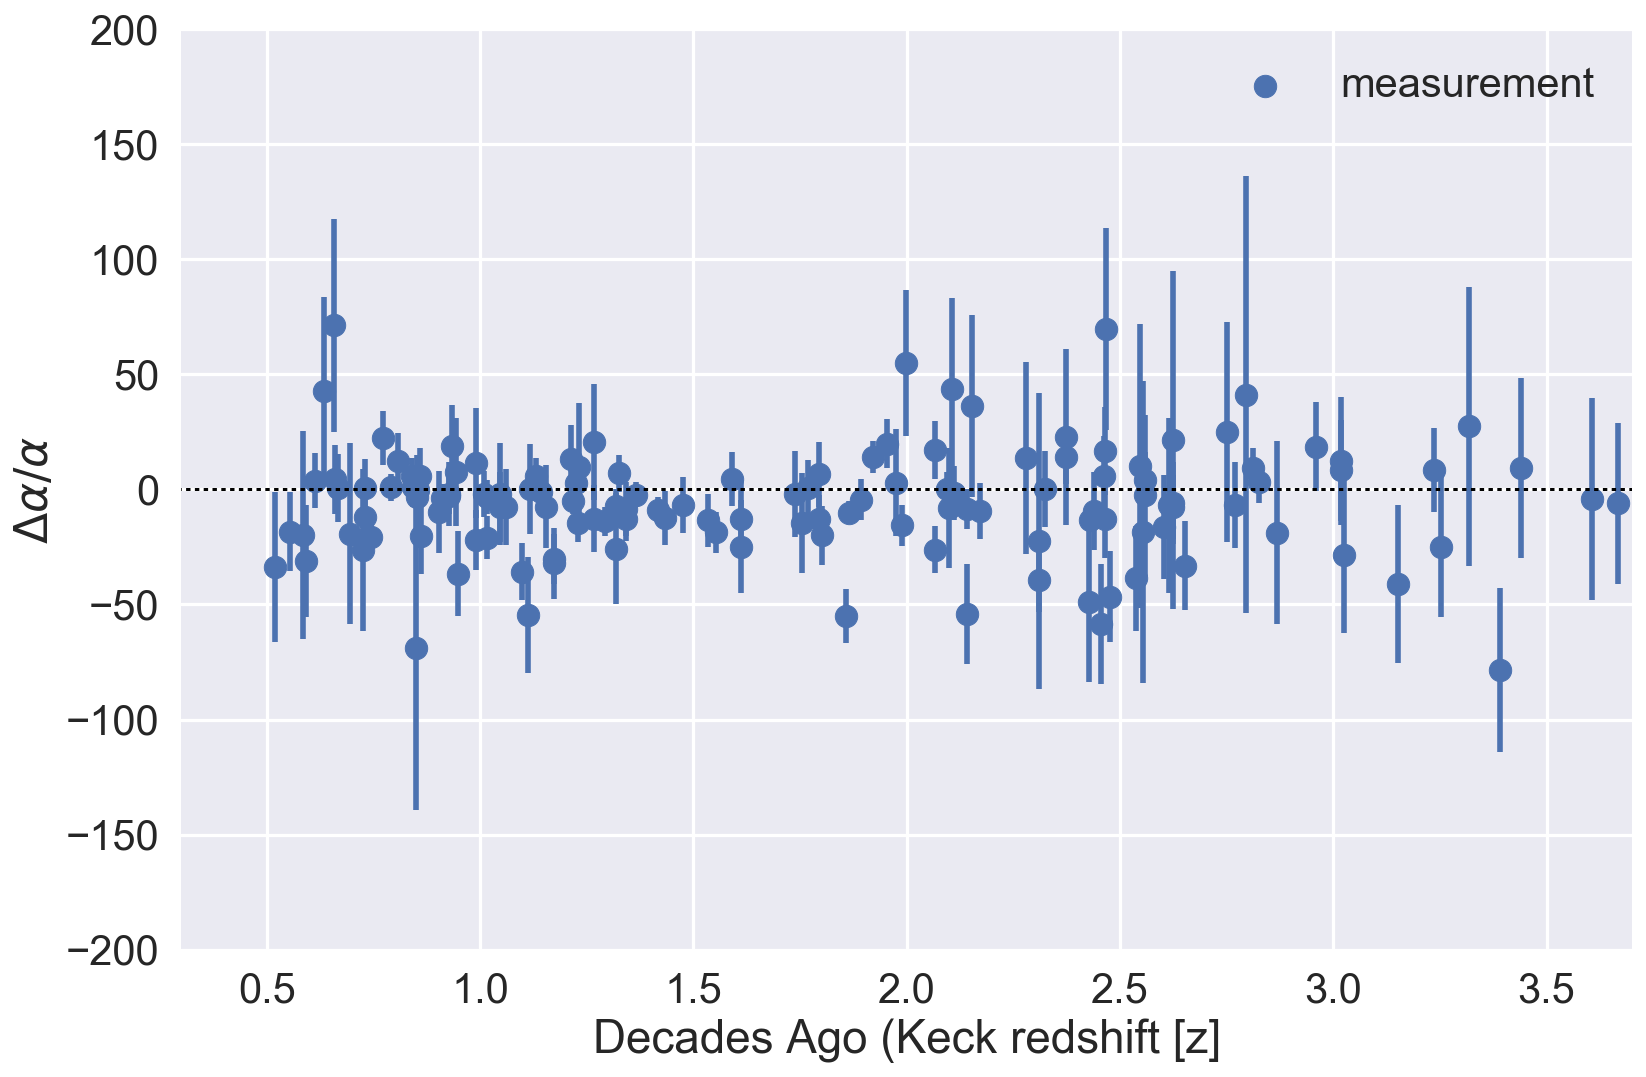

In [60]:
fig, ax = plt.subplots(figsize=(12, 8))
x = keck.z_absorption
y = keck.delta_alpha
e = keck.error_delta_alpha
color=0
label='measurement'
ax.scatter(x, (y), c=sns.color_palette()[color], label=label)
ax.errorbar(x, (y), yerr=e, c=sns.color_palette()[color],  ls='none', label='')
ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
ax.set_ylabel(r"$\Delta \alpha/\alpha$")
ax.set_xlabel(r"Decades Ago (Keck redshift [z]")
ax.legend(loc='best')
ax.set_xlim(0.3, 3.7)
ax.set_ylim(-200, 200)
fig.tight_layout()

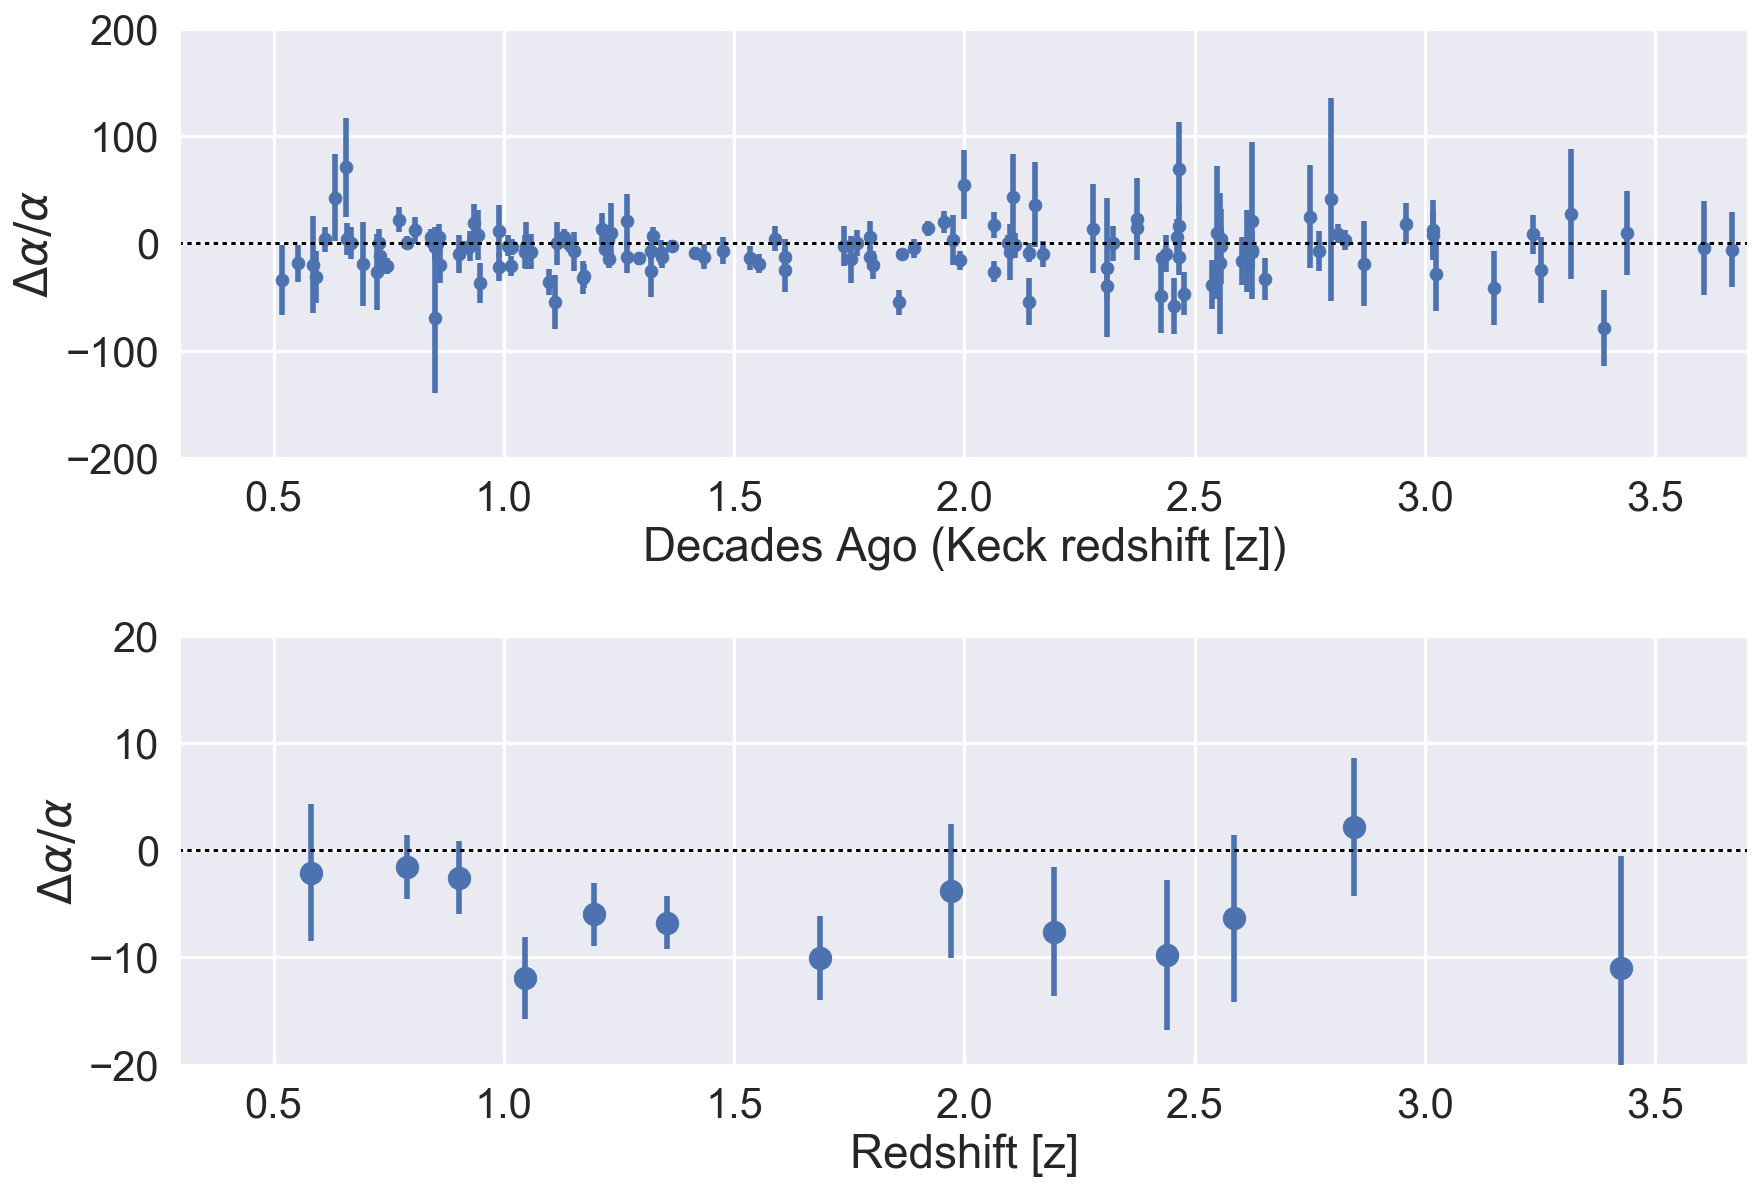

In [70]:
fig, (ax, ax2) = plt.subplots(nrows=2)
x = keck.z_absorption
y = keck.delta_alpha
e = keck.error_delta_alpha
color=0
label='measurement'
ax.scatter(x, (y), c=sns.color_palette()[color], label='', s=40)
ax.errorbar(x, (y), yerr=e, c=sns.color_palette()[color],  ls='none', label='')
ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
ax.set_ylabel(r"$\Delta \alpha/\alpha$")
ax.set_xlabel(r"Decades Ago (Keck redshift [z])")
ax.legend(loc='best')
ax.set_xlim(0.3, 3.7)
ax.set_ylim(-200, 200)
plot_a_v_z(keck, nbins=13, ylims=200, ax=ax2)
ax2.set_ylim(-20, 20)
fig.tight_layout()


In [ ]:
plot_a_v_z(keck)

It's important to note that none of the measurements by themselves is enough to establish a measurement at a 5-$\sigma$ level, but taken as an ensemble, it approaches ~4.7$\sigma$.

## Simulated data

I'm going to give you a set of data. This set of data, the y-values will be generated in one of two ways (or a combination).

 - An $\alpha$ process ($\alpha$ process)
 - A wavelength process (w process)

Here is a single system, plotted as though it was generated in either $\alpha$ or w processes (and transitions smoothly between them to highlight the fact that that y-values are the same. It is merely the x-axis that gets changed:

![alt text](../img/02-animation.gif "Switch")

**Given a dataset, can you devise a test that quantifies the relative likelihood of either process $\alpha$ or w generating it?**

One extra piece of information that is important: if $\alpha$ is generating a signal, it must be a straight line in the $\alpha$ plot. If it is a w-process, it can be more flexible. 

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings

warnings.filterwarnings('ignore')

In [3]:
from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import GridSpec
from itertools import combinations, islice, takewhile
import seaborn as sns
import json
import mpld3
import numpy as np
import pandas as pd
import scipy.sparse

import os, sys
import warnings
from astropy import units as u
from astropy.coordinates import SkyCoord
import statsmodels.api as sm
sns.set_context('poster', font_scale=1.3)

from ipywidgets import interact, FloatSlider, SelectMultiple, interactive

# "constants"
from scipy.constants import c # speed of light in m/s

In [342]:
DIP_RA = 17.3
DIP_RA_ERR = 1.0
DIP_DEC = -61.0
DIP_DEC_ERR = 10.0
DIP_AMPLITUDE = 0.97e-5
DIP_AMPLITUDE_ERR = 0.21e-5 # average of asymmetric errors
DIP_MONOPOLE = -0.178e-5
DIP_MONOPOLE_ERR  = 0.084e-5

dipole = SkyCoord(DIP_RA, DIP_DEC, unit=(u.hourangle, u.deg))

# Data
vltqs = pd.read_csv('../data/vlt-transitions-new.tsv', sep='\t')
vltqs['trans'] = vltqs['transition'] + vltqs.four.astype(str)

keckqs = pd.read_csv("../data/keck-transitions-new.tsv", sep='\t')
keckqs['trans'] = keckqs.transition + keckqs.four.astype(str)

qvals = pd.read_csv("../data/qvalues.txt", sep=' ', index_col=0)

codes = pd.concat([keckqs.set_index('code')[['trans', 'wavelength']],
                   vltqs.set_index('code')[['trans', 'wavelength']]])

all_systems = pd.read_csv("../data/full-parse-new.tsv", sep='\t')

vlt_ccds = pd.read_csv("../data/vlt-ccd.csv", index_col='chip')

In [343]:
vlt = all_systems[all_systems.source.eq('VLT')].copy()
keck = all_systems[all_systems.source.eq('Keck')].copy()

In [62]:
def plot_a_v_z(dataframe, alphacol='delta_alpha', 
               errorcol='extra_error_delta_alpha', 
               nbins=13,
               color=0,
               ylims=(20),
               label='',
               fig=None,
               ax=None,
              ):
    if fig == None:
        fig = plt.gcf()
    if ax == None:
        ax = plt.gca()
    for index, df in enumerate(np.array_split(dataframe.sort_values('z_absorption'), nbins)):
        x = np.average(df.z_absorption)
        y = np.average(df[alphacol], weights=(1.0 / (df[errorcol] ** 2.0)))
        e = np.sqrt(1.0 / np.sum(1.0 / (df[errorcol] ** 2.0)))
        if index == 0:
            label=label
        else:
            label=''
        ax.scatter(x, y, c=sns.color_palette()[color], label=label)
        ax.errorbar(x, y, yerr=e, c=sns.color_palette()[color])
    ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
    ax.set_ylabel(r"$\Delta \alpha/\alpha$")
    ax.set_xlabel(r"Redshift [z]")
    ax.legend(loc='best')
    ax.set_xlim(0.3, 3.7)
    ax.set_ylim(-ylims, ylims)
    fig.tight_layout()

In [32]:
def plot_a_v_zresid(dataframe, 
                    dataframe2,
                    alphacol='delta_alpha',
                    alphacol2='dipole_delta_alpha',
                    errorcol='extra_error_delta_alpha', color=0, label=''):
    """Measured - model"""
    fig = plt.gcf()
    ax = plt.gca()
    nbins = 13
    for index in range(nbins):
        df = np.array_split(dataframe.sort_values('z_absorption'), nbins)[index]
        x = np.average(df.z_absorption)
        y = np.average(df[alphacol], weights=(1.0 / (df[errorcol] ** 2.0)))
        e = np.sqrt(1.0 / np.sum(1.0 / (df[errorcol] ** 2.0)))
        
        df2 = np.array_split(dataframe2.sort_values('z_absorption'), nbins)[index]
        x2 = np.average(df2.z_absorption)
        y2 = np.average(df2[alphacol2], weights=(1.0 / (df2[errorcol] ** 2.0)))
        e2 = np.sqrt(1.0 / np.sum(1.0 / (df2[errorcol] ** 2.0)))
        if index == 0:
            label=label
        else:
            label=''
        ax.scatter(x, (y - y2), c=sns.color_palette()[color], label=label)
        ax.errorbar(x, (y - y2), yerr=e, c=sns.color_palette()[color])
    ax.hlines(0, -2, 6, linestyles=':', lw=1.5, color='k')
    ax.set_ylabel(r"Residual $\Delta \alpha/\alpha$")
    ax.set_xlabel(r"Redshift [z]")
    ax.legend(loc='best')
    ax.set_xlim(0.3, 3.7)
    ax.set_ylim(-20, 20)
    fig.tight_layout()

In [33]:
all_systems.head()

J2000  z_emission  z_absorption  delta_alpha  error_delta_alpha  \
0  J000149-015940        2.31       2.09510         0.34               7.27   
1  J000149-015940        2.31       2.15390        36.05              39.54   
2  J000322-260316        4.11       1.43420       -12.53              11.67   
3  J000322-260316        4.11       3.38970       -78.43              35.48   
4  J000520+052410        1.90       0.59137       -31.05              24.33   

   extra_error_delta_alpha  dipole_delta_alpha  dipole_angle sample source  \
0                18.885386           -2.377815       93.5334     B1   Keck   
1                39.540000           -2.377815       93.5334     B1   Keck   
2                11.670000            1.115461       72.6324      C   Keck   
3                35.480000            1.115461       72.6324      C   Keck   
4                24.330000           -3.538861      100.4470      C   Keck   

   sigflag  imrotator              transitions  
0        2          0  d g h i j k l s t u v w  
1        1          0                  d f g l  
2        1          1                  b c p r  
3        1          1                  d g l m  
4        1          0              b c n p q r

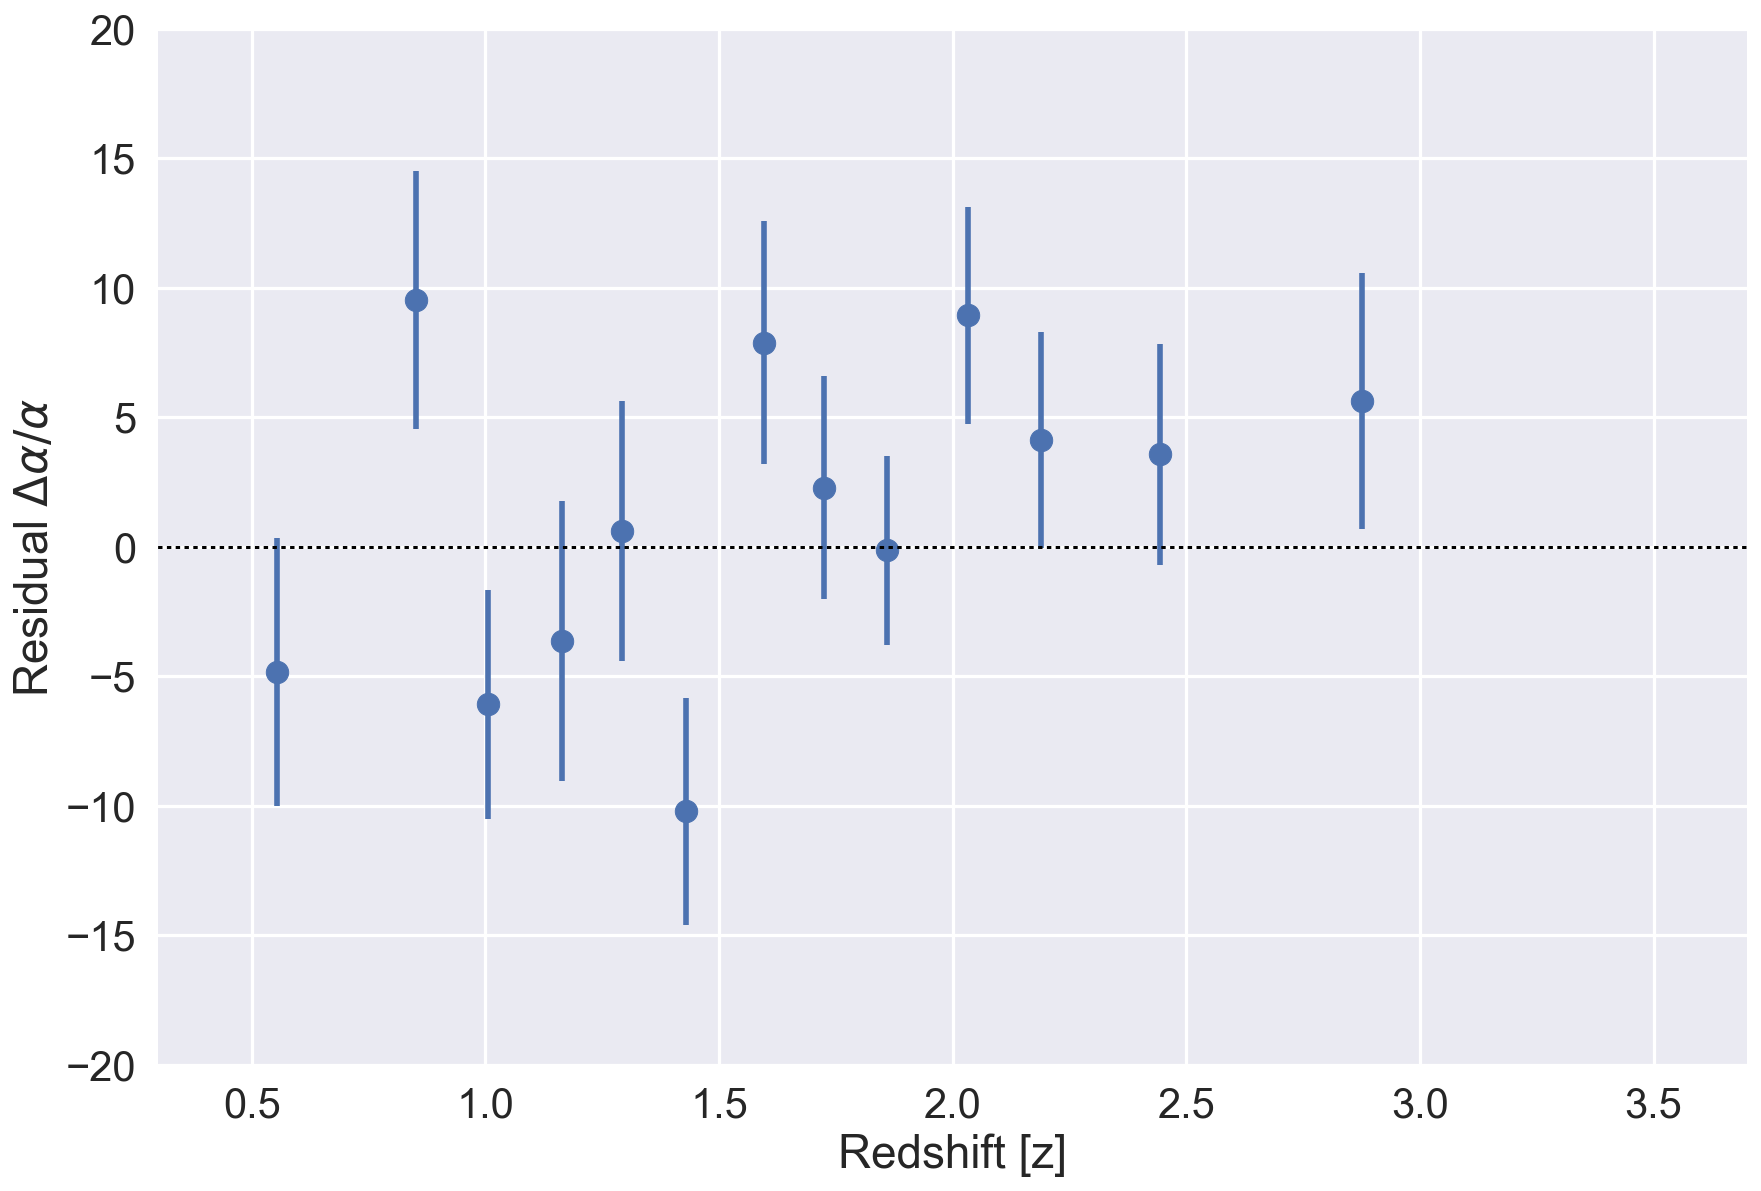

In [34]:
plot_a_v_zresid(vlt, vlt)

In [231]:
def plot_a_v_theta(dataframe,
                   alphacol='delta_alpha',
                   alphacol2='dipole_delta_alpha',
                   nbins=13,
                   errorcol='extra_error_delta_alpha', color=0, label=''):
    """Measured - model"""
    fig = plt.gcf()
    ax = plt.gca()
    for index in range(nbins):
        df = np.array_split(dataframe.sort_values('dipole_angle'), nbins)[index]
        x = np.average(df.dipole_angle)
        y = np.average(df[alphacol], weights=(1.0 / (df[errorcol] ** 2.0)))
        e = np.sqrt(1.0 / np.sum(1.0 / (df[errorcol] ** 2.0)))
        
        if index == 0:
            label=label
        else:
            label=''
        ax.scatter(x, (y), c=sns.color_palette()[color], label=label)
        ax.errorbar(x, (y), yerr=e, c=sns.color_palette()[color])
    ax.hlines(0, -2, 200, linestyles=':', lw=1.5, color='k')
    ax.vlines(90, -30, 30, linestyles=':', lw=1.5, color='k')
    ax.set_ylabel(r"Residual $\Delta \alpha/\alpha$")
    ax.set_xlabel(r"$\Theta$, angle from best-fitting dipole [degrees]")
    ax.legend(loc='best')
    ax.set_xlim(0.0, 180.0)
    ax.set_ylim(-25, 25)
    fig.tight_layout()

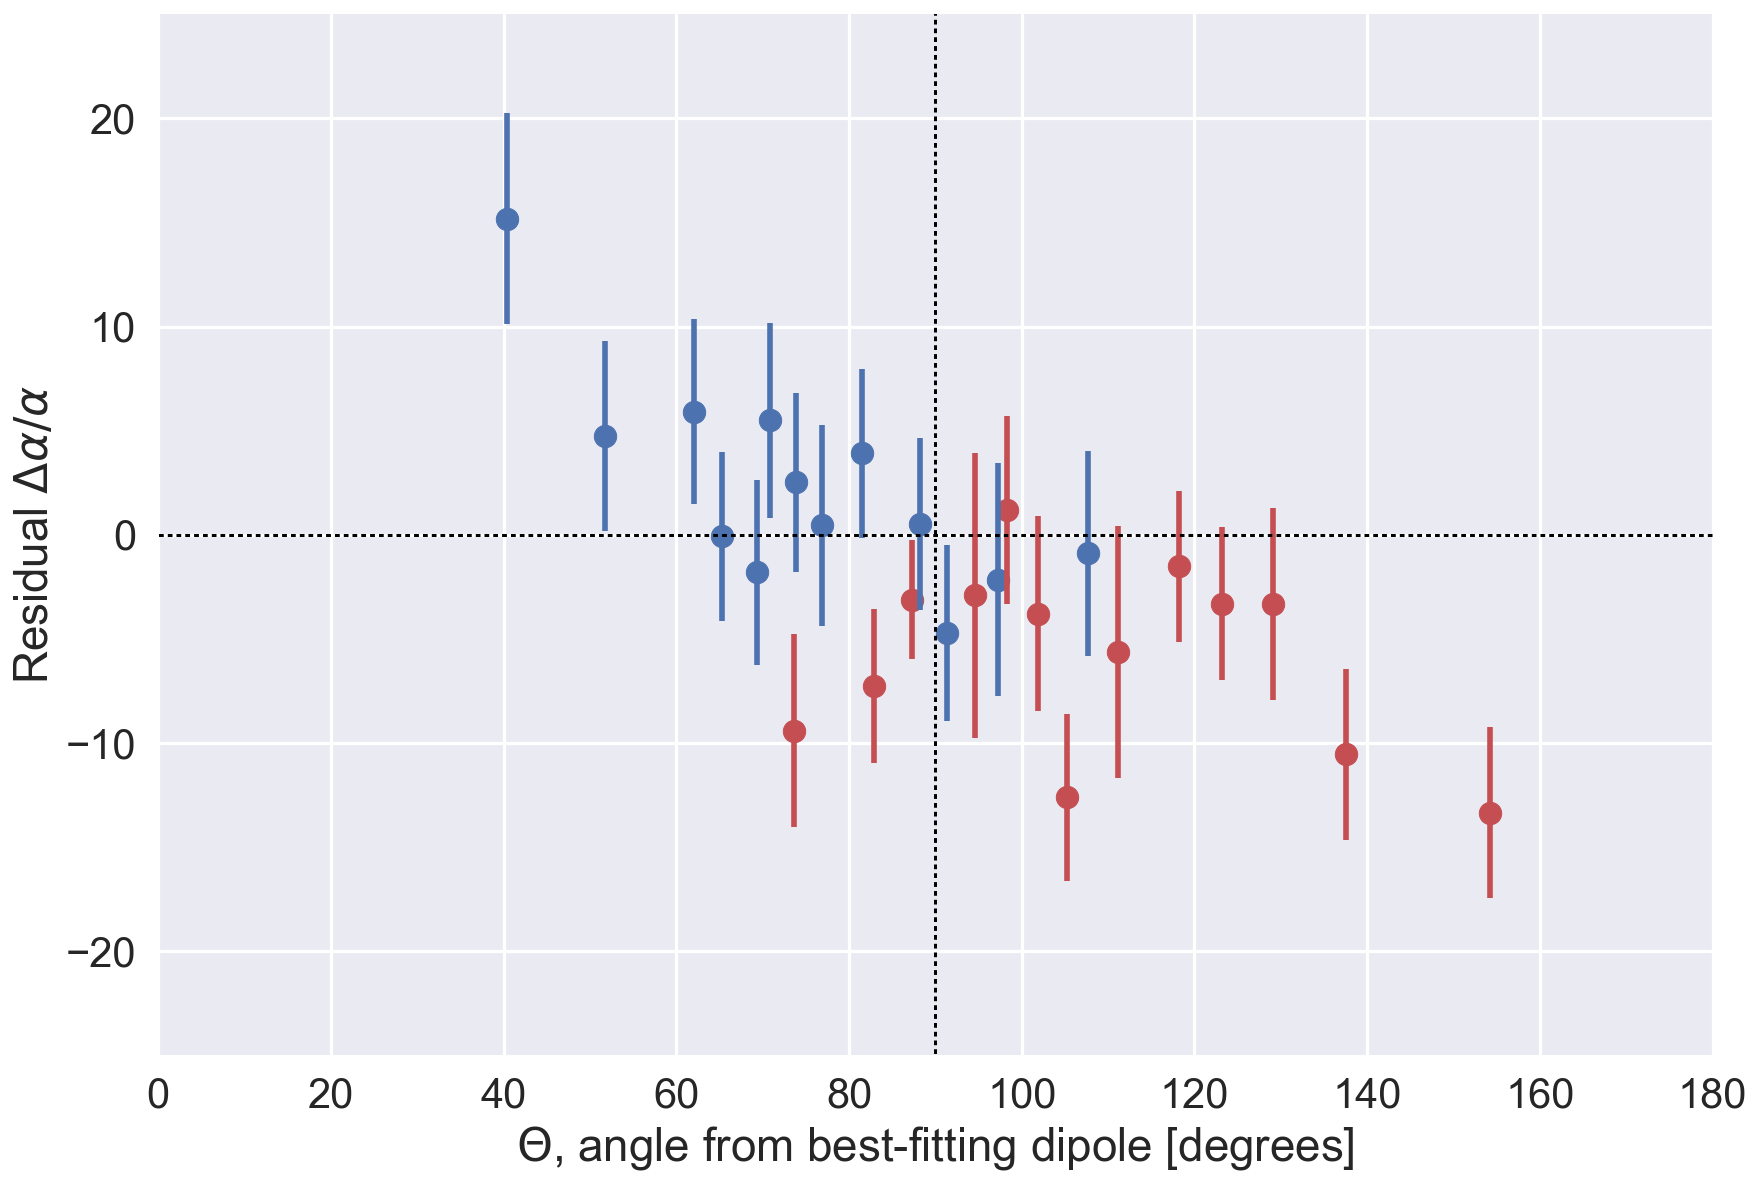

In [226]:
plot_a_v_theta(vlt, color=0)
plot_a_v_theta(keck, color=2)

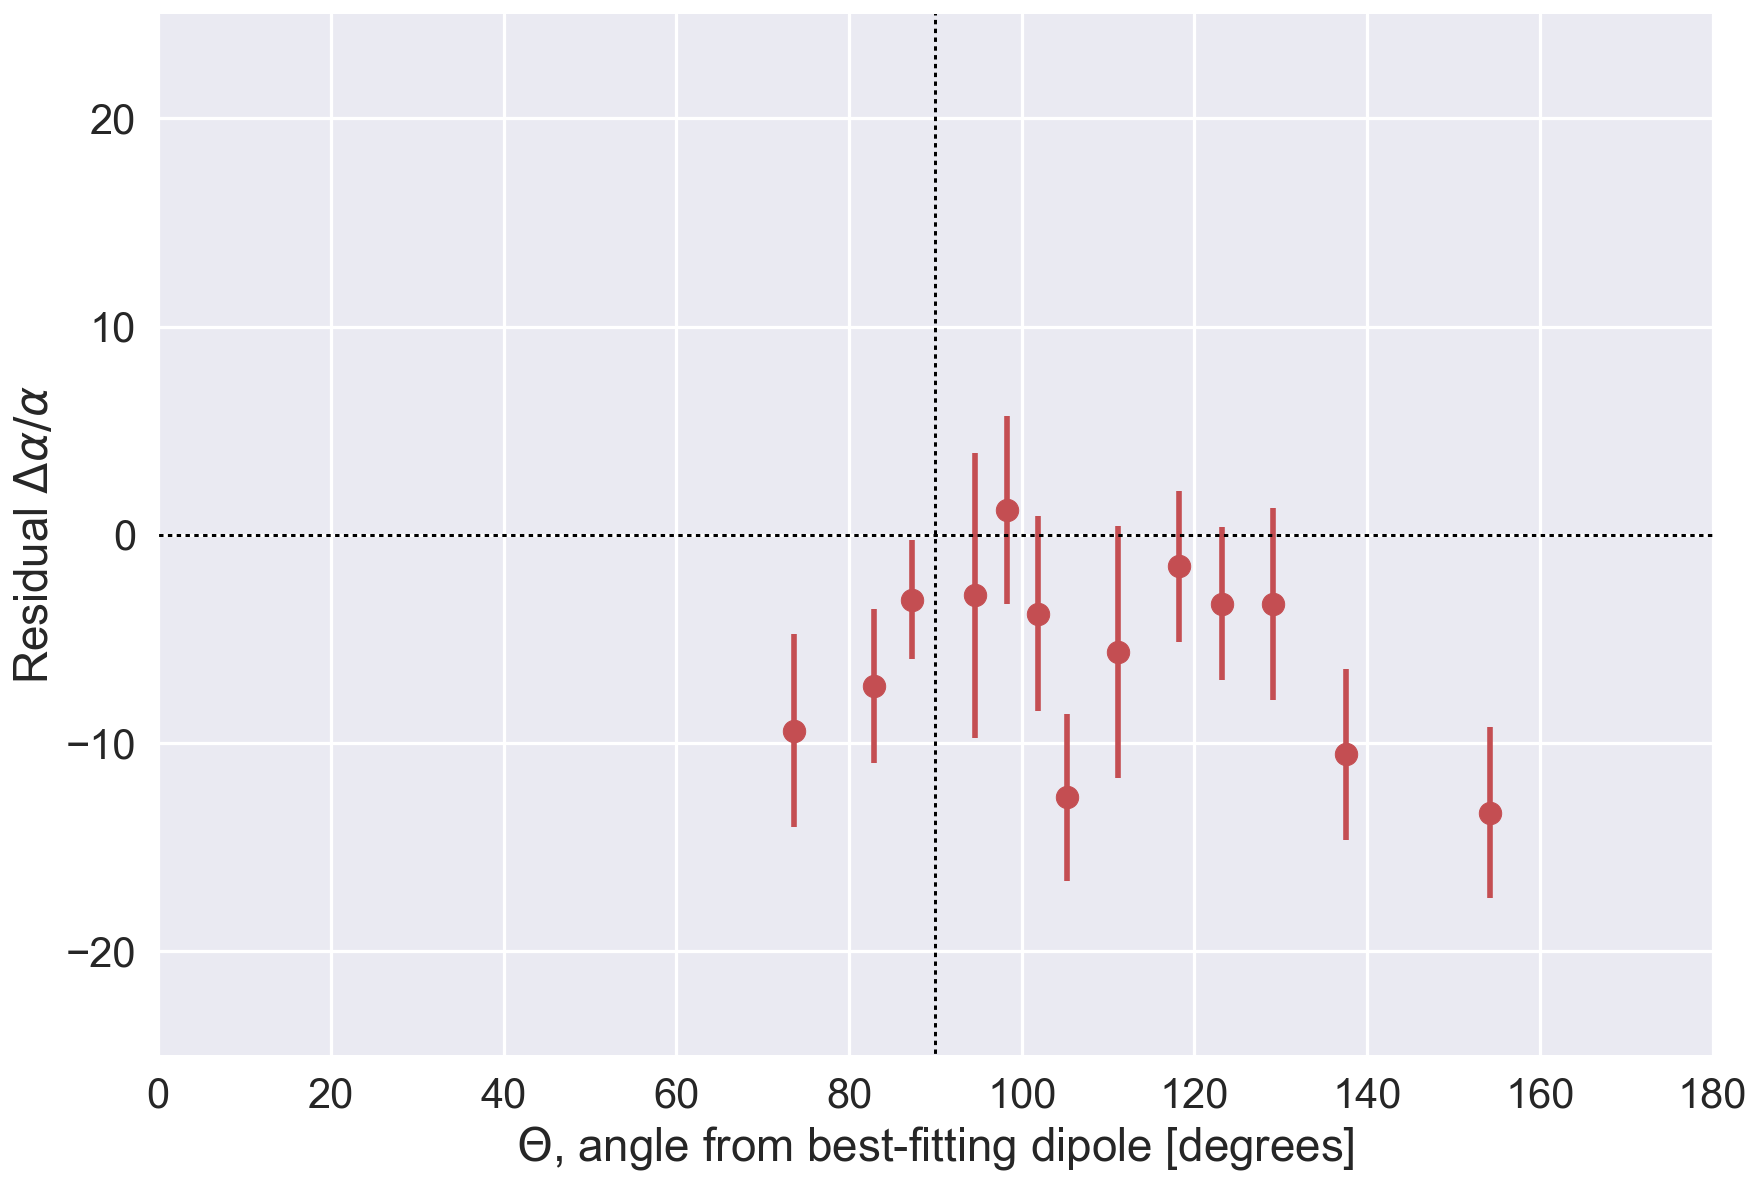

In [37]:
plot_a_v_theta(keck, color=2)

In [229]:
first = keck[keck.sigflag == 1]
second = keck[keck.sigflag == 2]

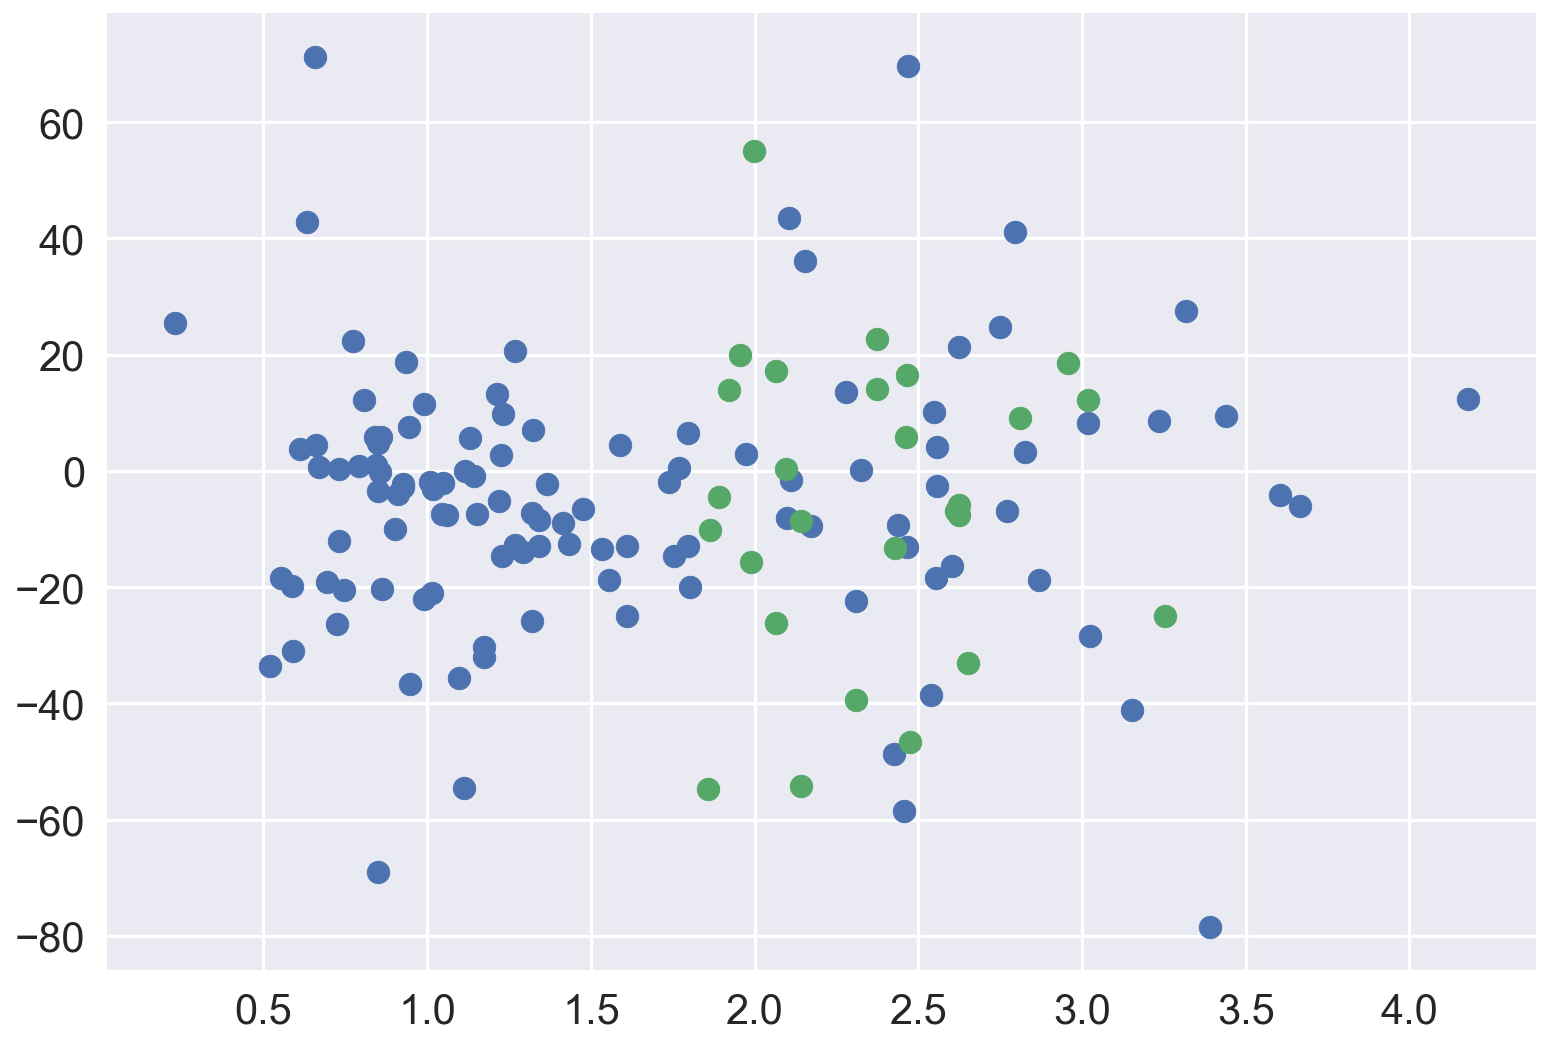

In [230]:
plt.scatter(first.z_absorption, first.delta_alpha)
plt.scatter(second.z_absorption, second.delta_alpha)

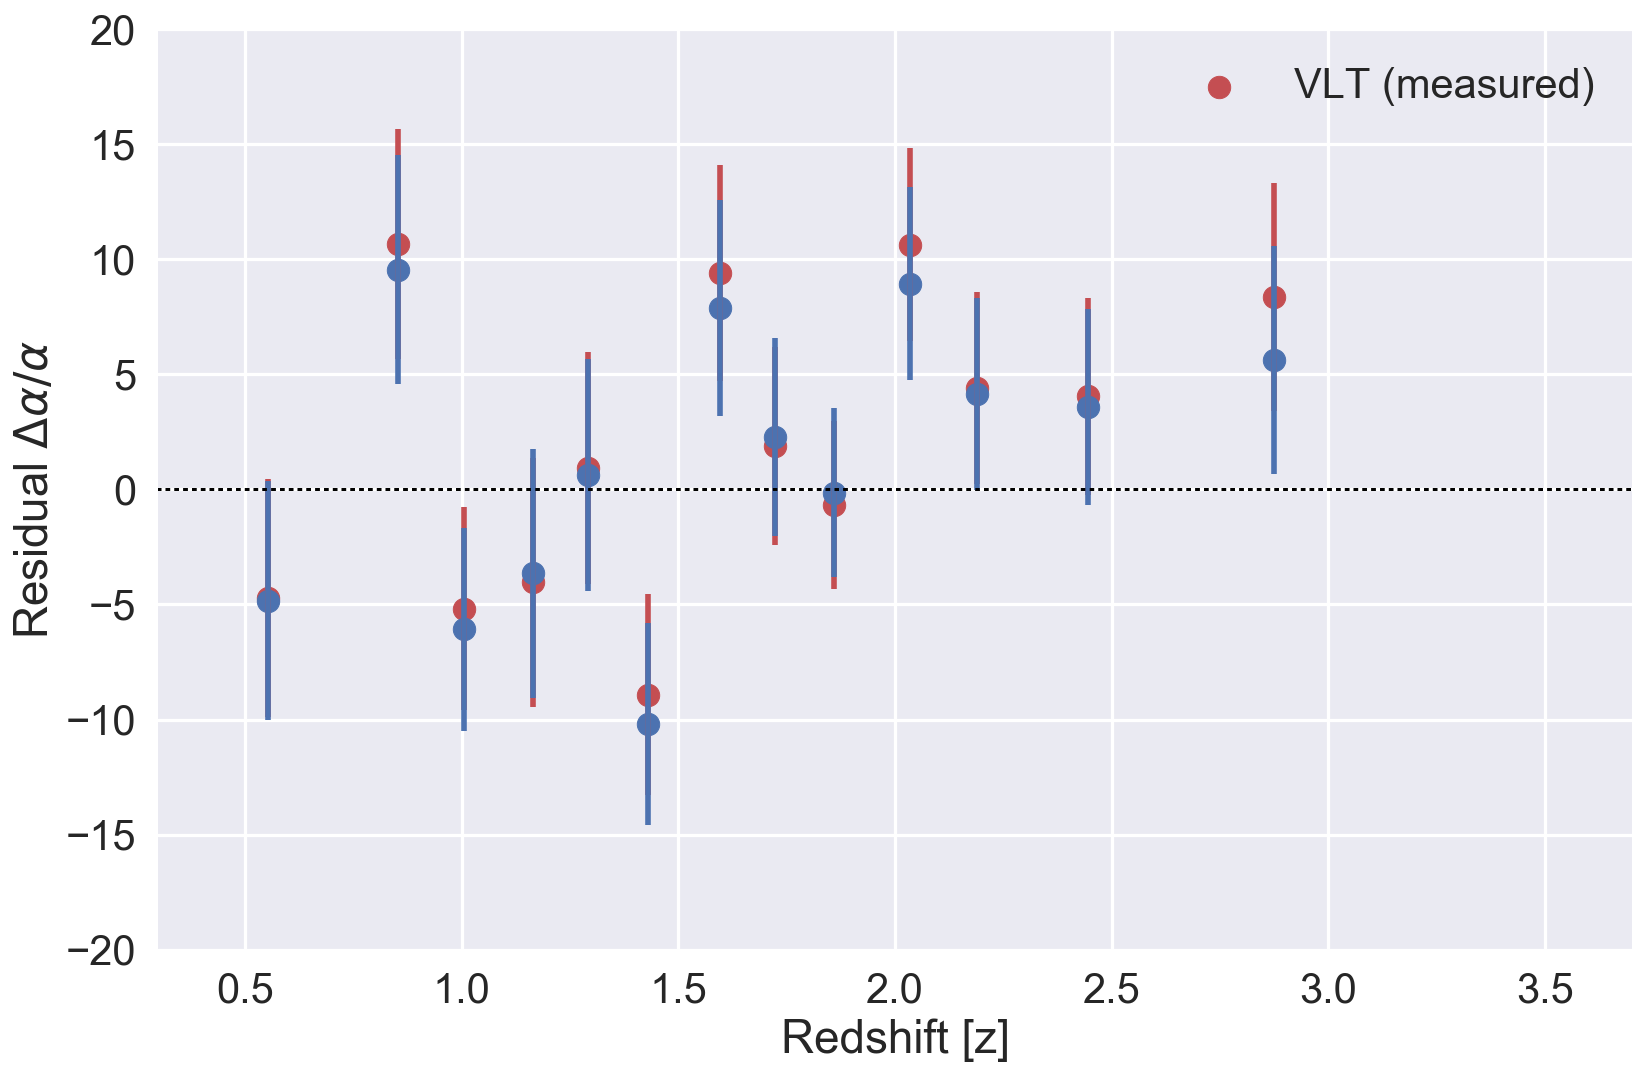

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(vlt, color=2, label='VLT (measured)')
plot_a_v_zresid(vlt, vlt)

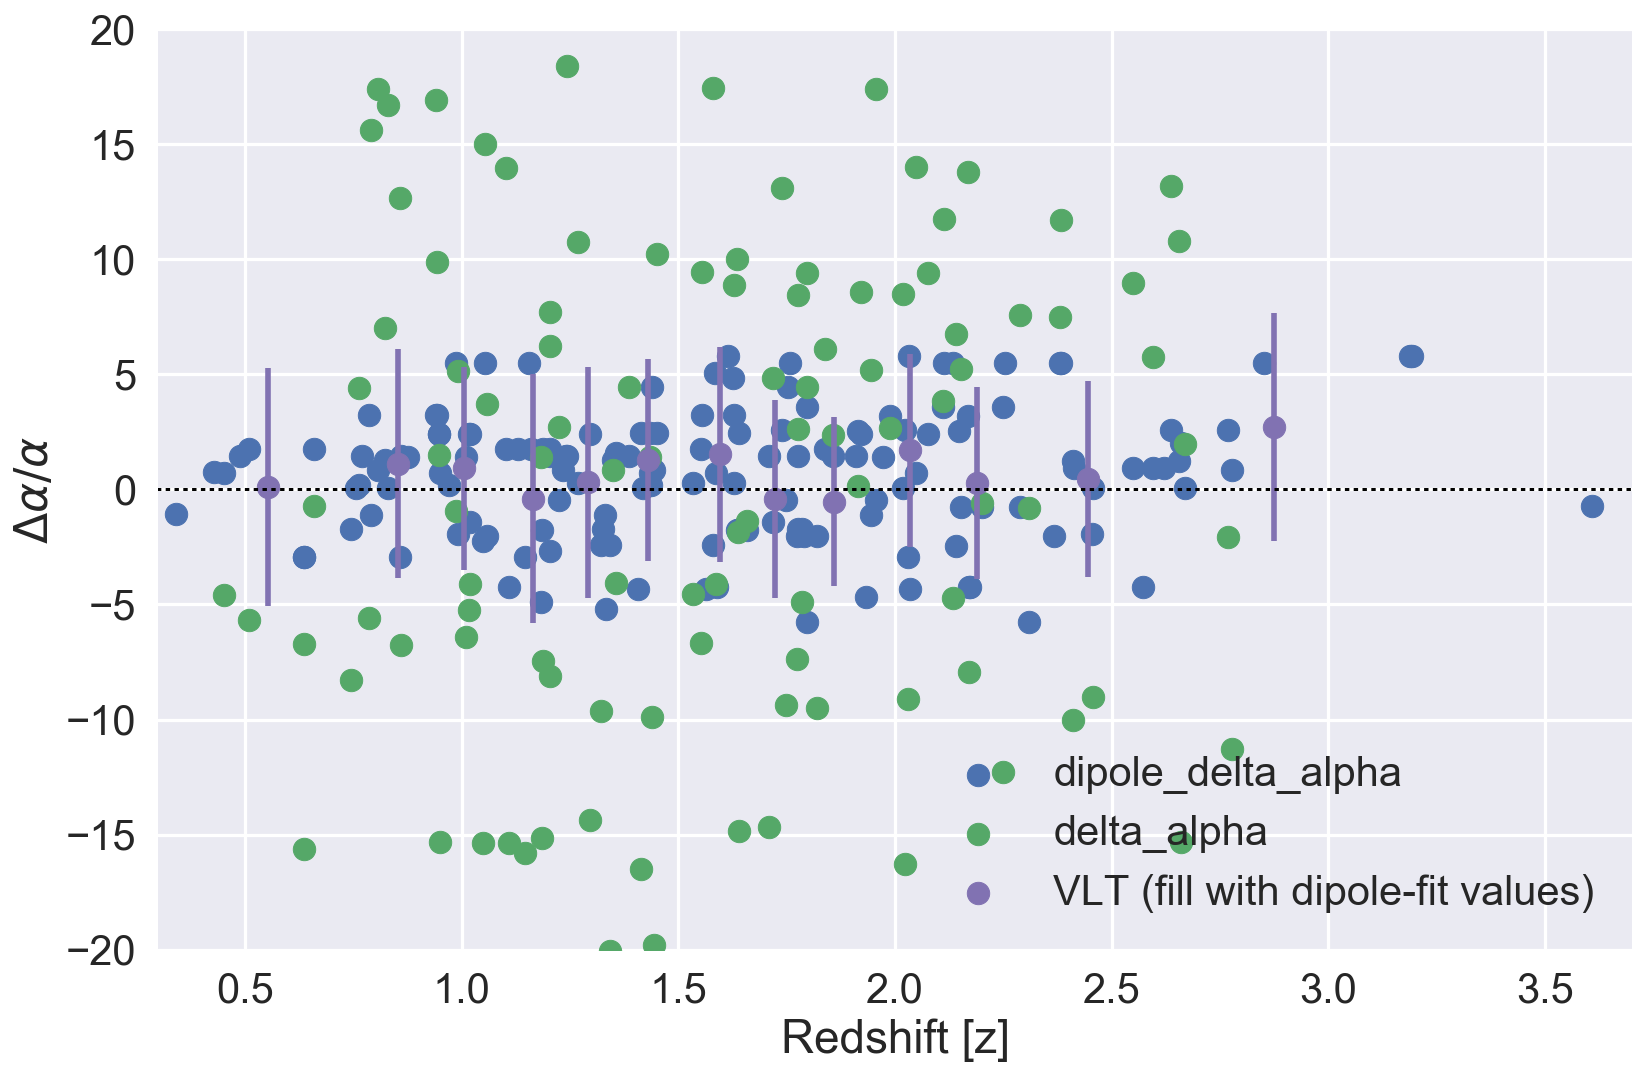

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(vlt.z_absorption, vlt.dipole_delta_alpha)
ax.scatter(vlt.z_absorption, vlt.delta_alpha)
plot_a_v_z(vlt, alphacol='dipole_delta_alpha', color=3, label='VLT (fill with dipole-fit values)')

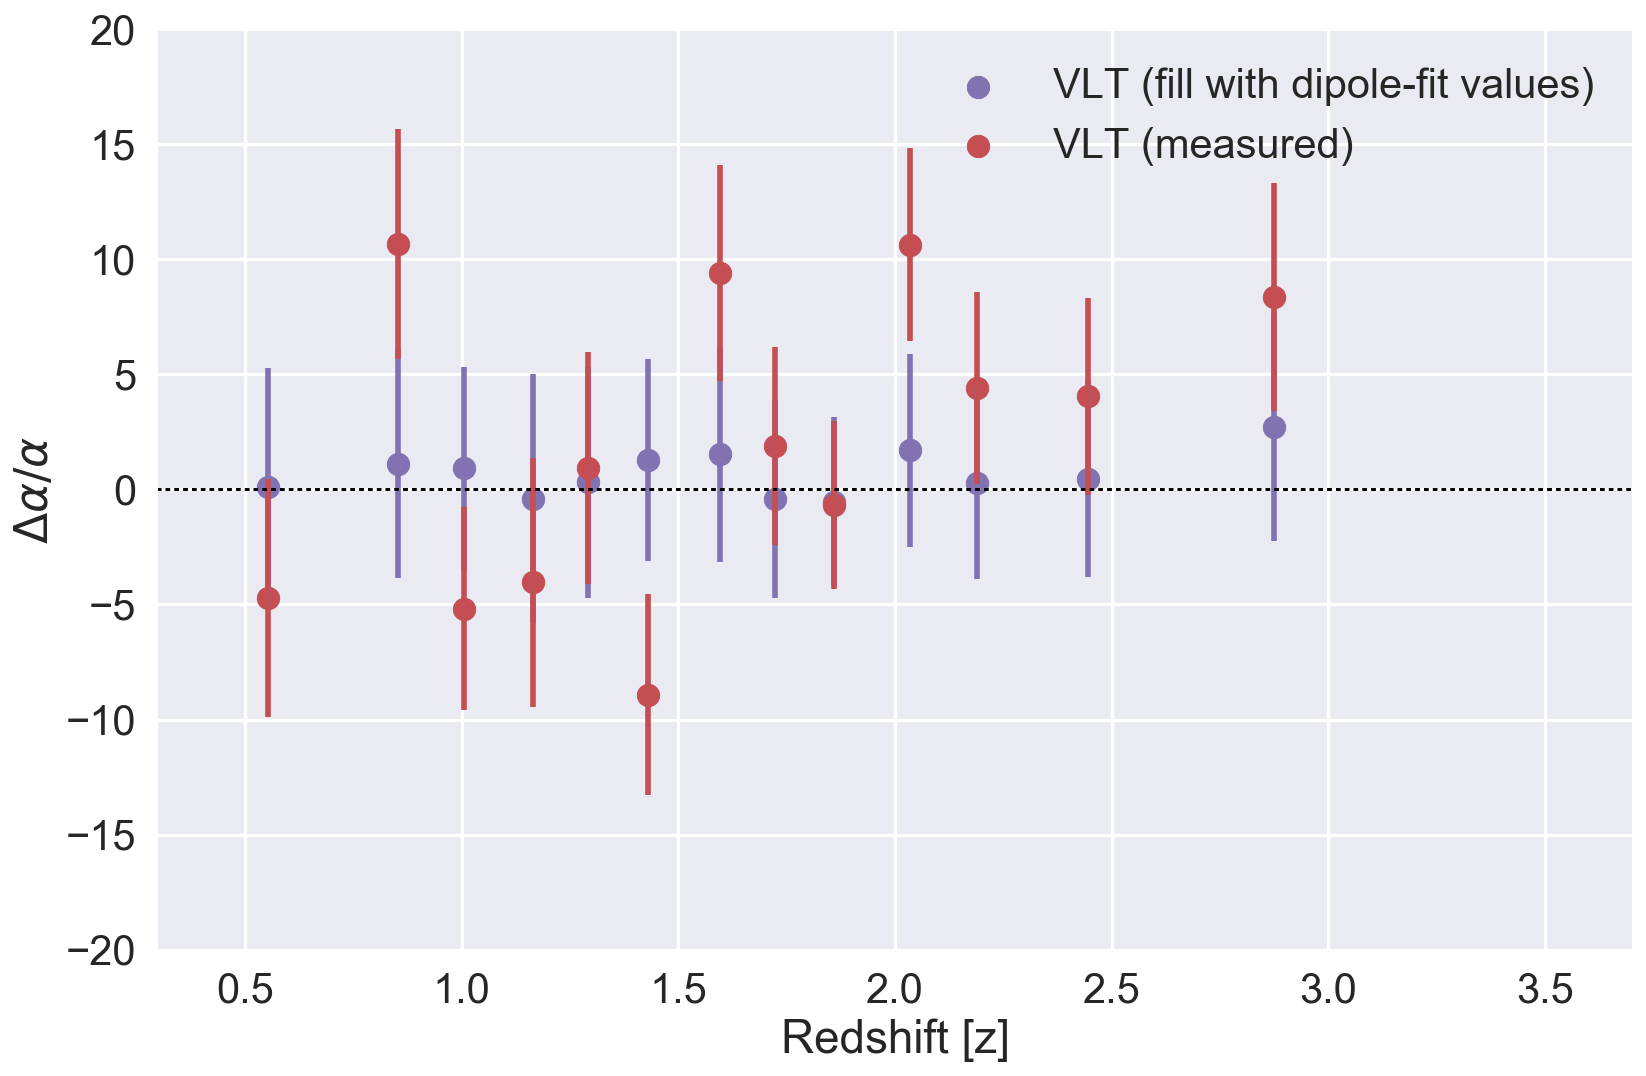

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(vlt, alphacol='dipole_delta_alpha', color=3, label='VLT (fill with dipole-fit values)')
plot_a_v_z(vlt, color=2, label='VLT (measured)')

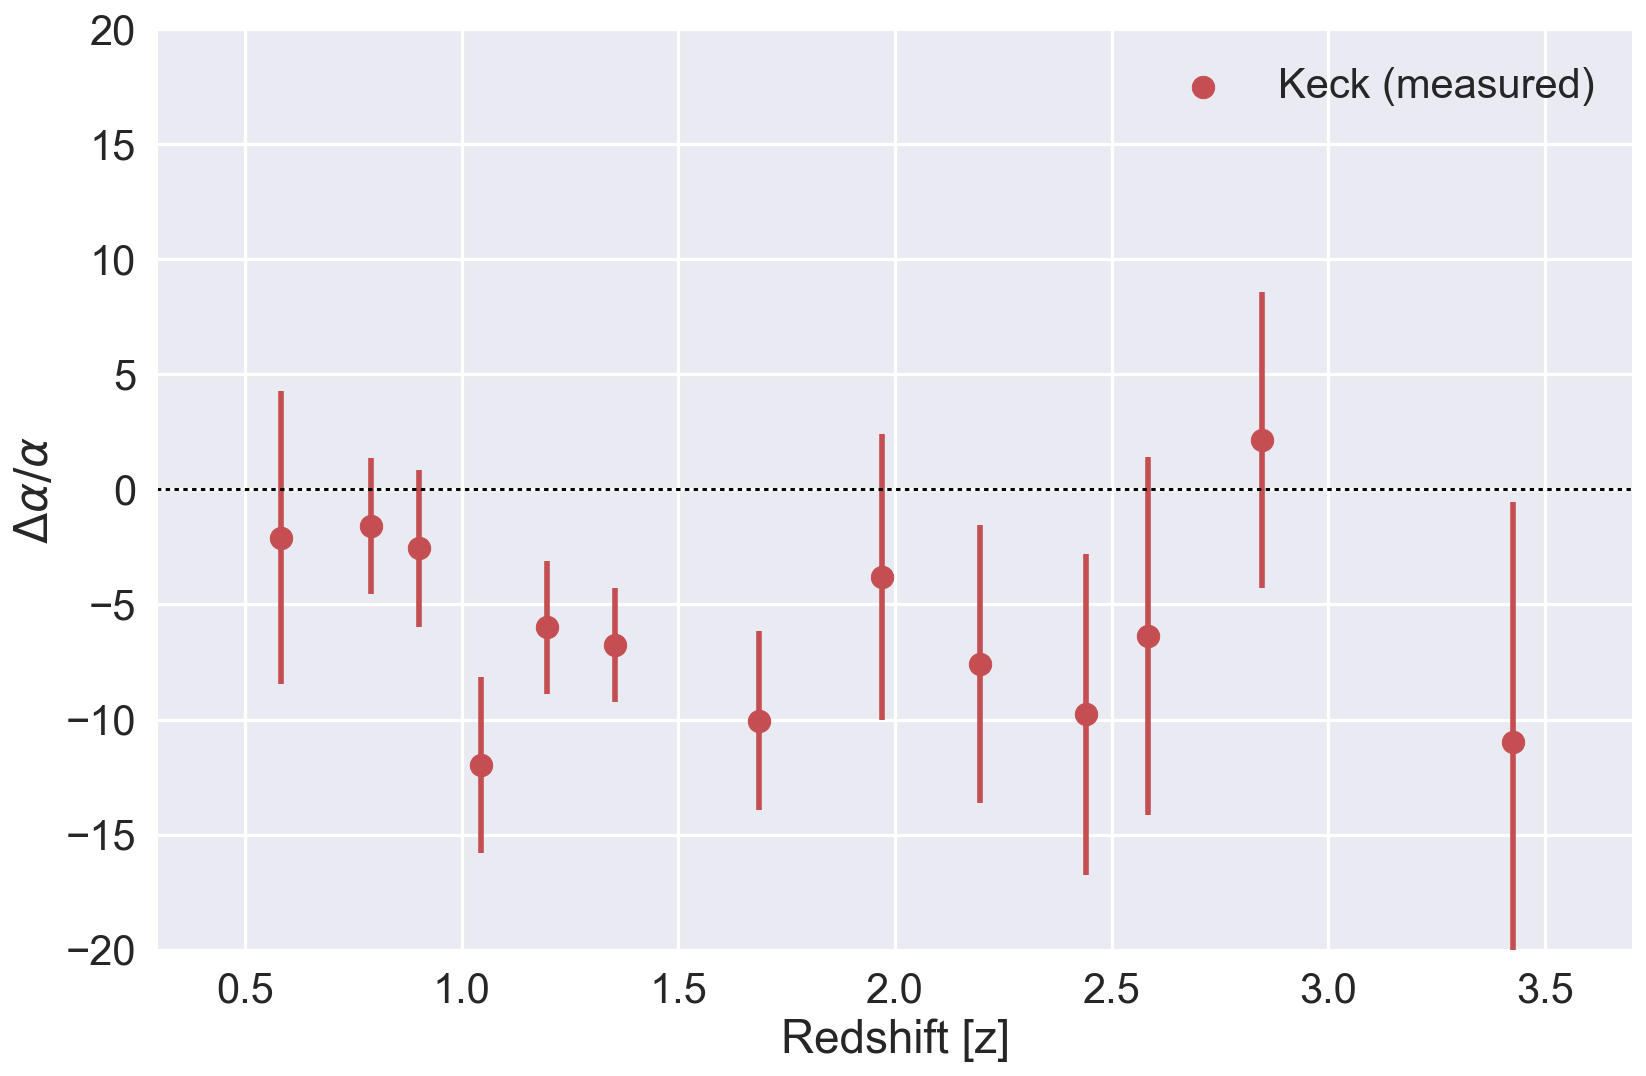

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(keck, color=2, label='Keck (measured)')

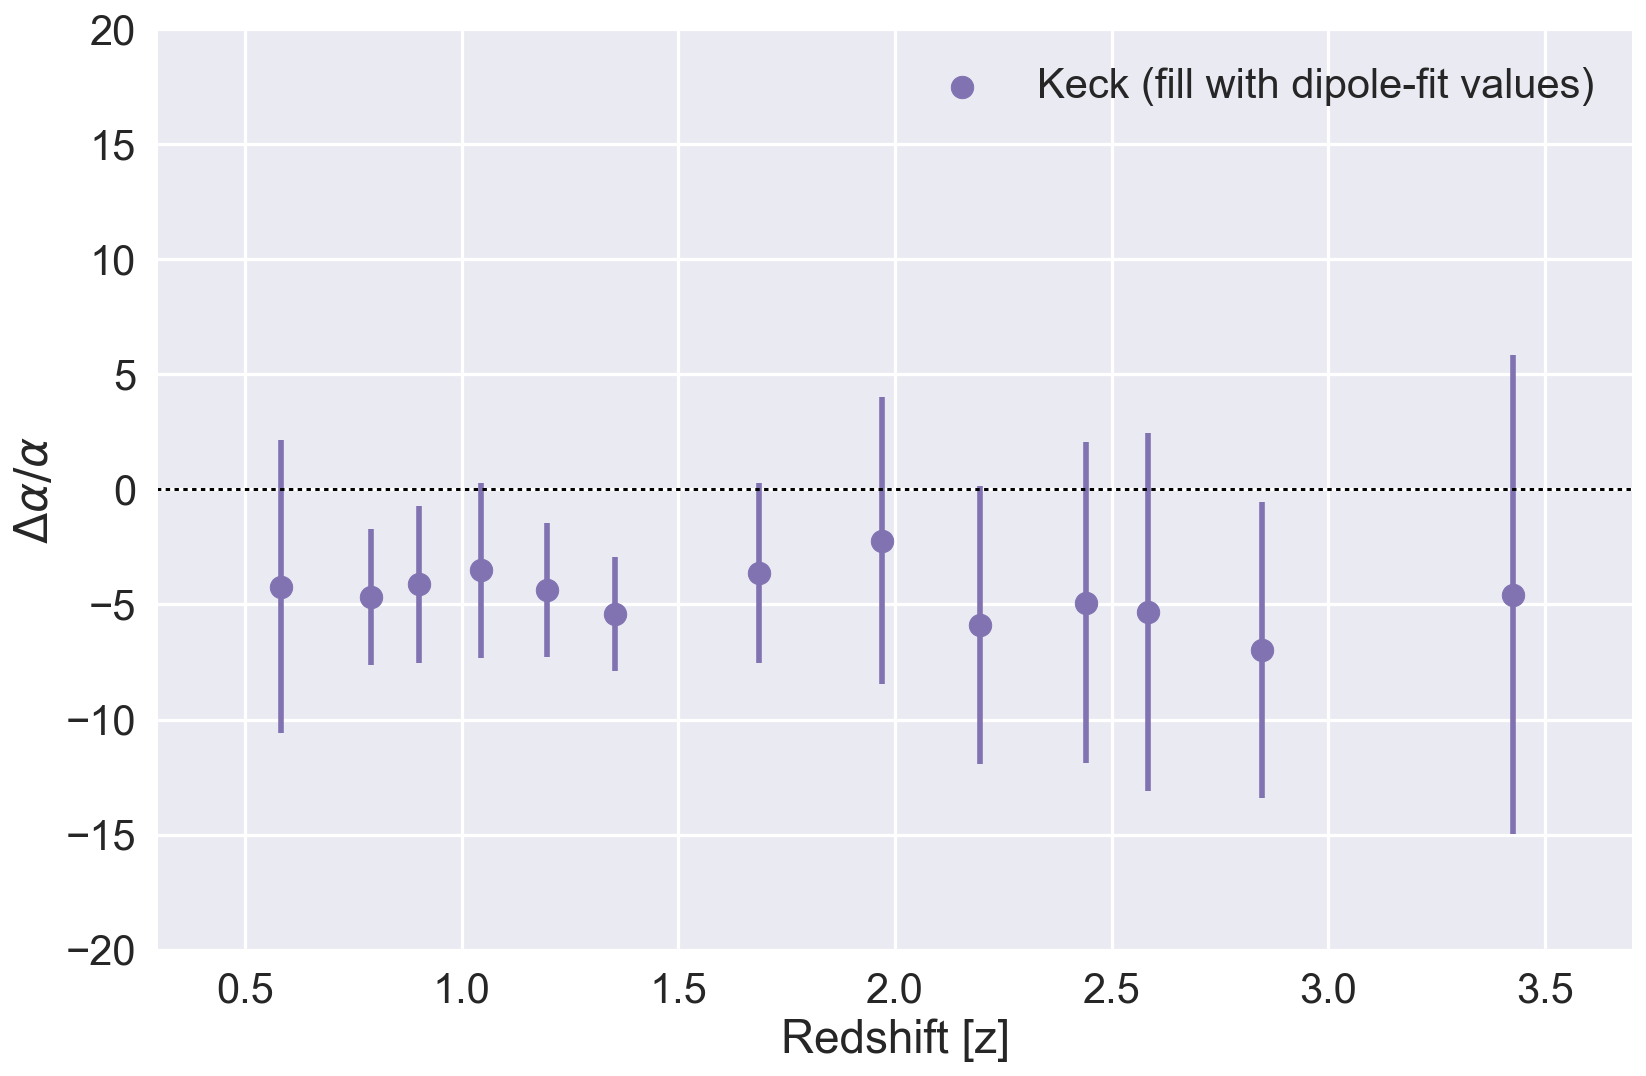

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(keck, alphacol='dipole_delta_alpha', color=3, label='Keck (fill with dipole-fit values)')

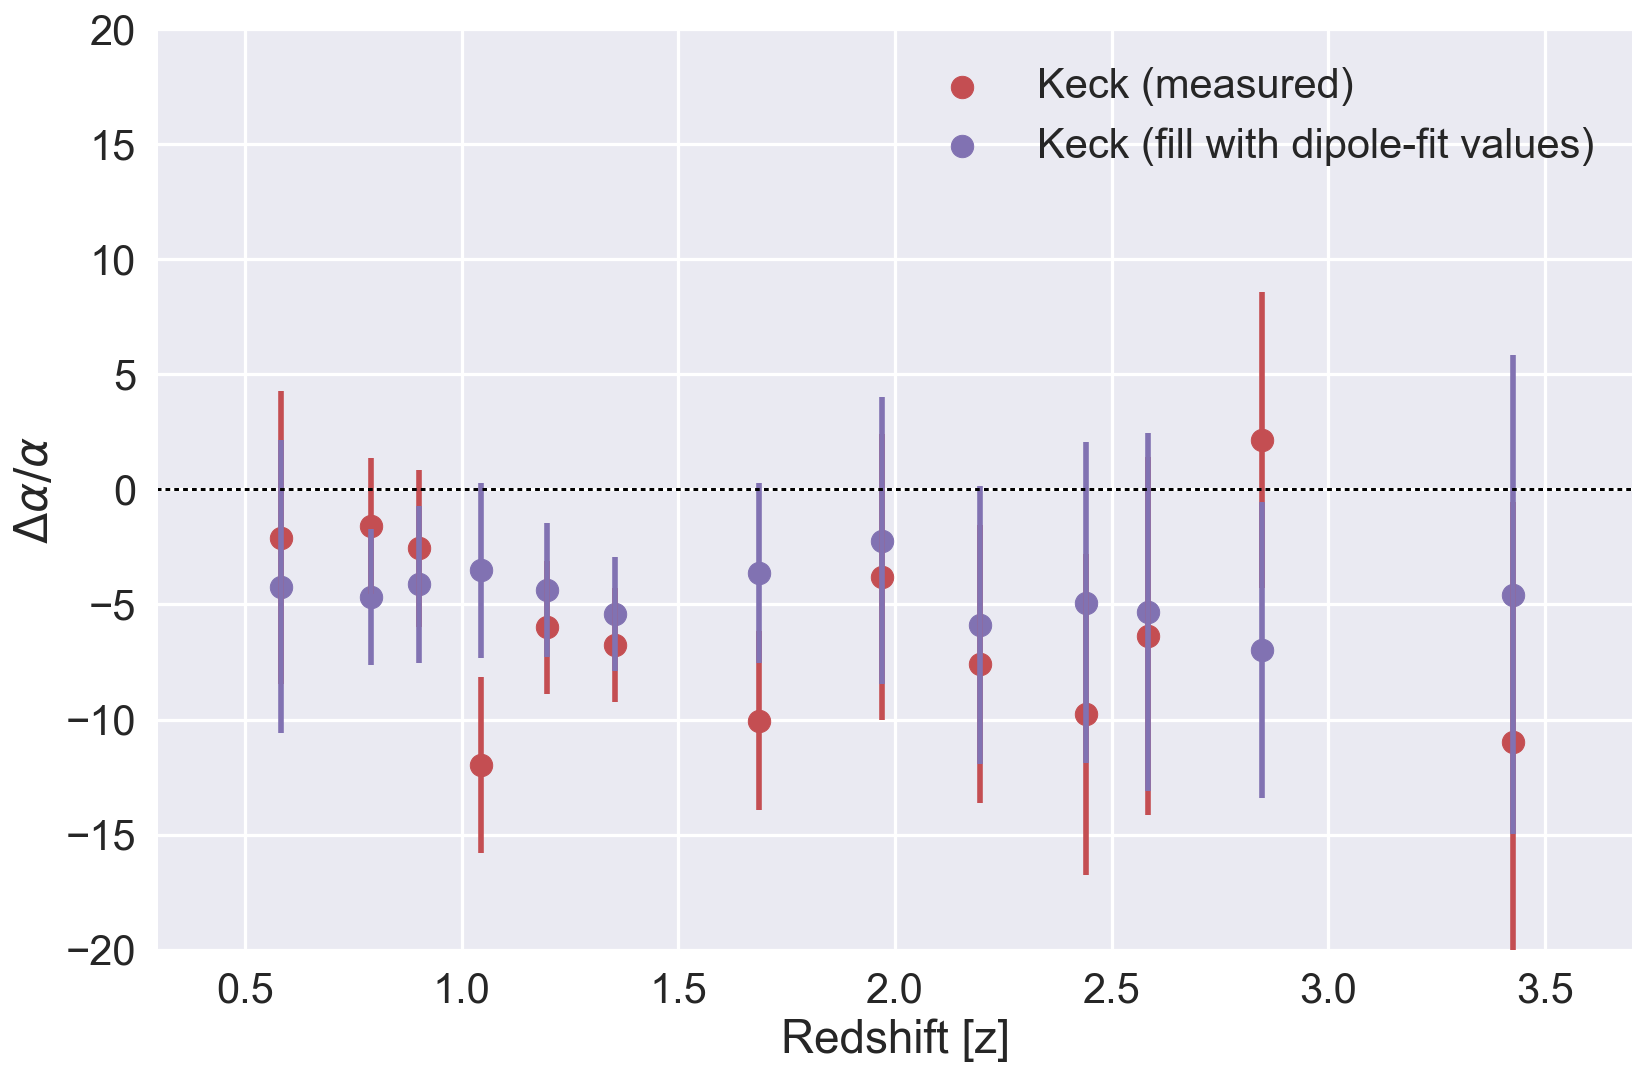

In [190]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_a_v_z(keck, color=2, label='Keck (measured)')
plot_a_v_z(keck, alphacol='dipole_delta_alpha', color=3, label='Keck (fill with dipole-fit values)')

In [151]:
def observed_shifts(telescope='VLT'):
    waves = []
    shifts = []
    for index, row in all_systems[all_systems.source.eq(telescope)].iterrows():
        for tran in row['transitions'].split():
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.z_absorption)
            qval = qvals.loc[codes.loc[tran].trans].qval
            waves.append(measured_wave)
            shifts.append(shifted_velocity(row.delta_alpha, qval, rest_wave))
    return np.array(waves), np.array(shifts)


def parse_j2000(name):
    """Takes the J2000 name stored in the results and returns it in a format astropy can understand."""
    return ' '.join([name[1:3], name[3:5], name[5:7], name[7:10], name[10:12], name[12:]])

def j2000_to_theta(name):
    """Returns the angle (degrees) between the position on the sky from 
    a given `name` and the position of the dipole model from 2012, King."""
    c = SkyCoord(parse_j2000(name), unit=(u.hourangle, u.deg))
    return float(c.separation(dipole).to_string(decimal=True))

def dipole_alpha(name):
    """Returns the value of Delta alpha/alpha as given by the best fit 2012 King model for 
    the given name (position).
    """
    theta = j2000_to_theta(name)
    return (DIP_AMPLITUDE * np.cos(np.deg2rad(theta)) + DIP_MONOPOLE) * 1e6

def plot_system(system, dataframe):
    plotdf = dataframe[dataframe.system == system]
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 10), nrows=2)
    sns.regplot('wavelength', 'vshift', data=plotdf, ax=ax1)
    sns.regplot('x', 'vshift', data=plotdf, ax=ax2)
    fig.tight_layout()


def shifted_velocity(del_alpha, q, lamb):
    # vj =v0 + ∆α xj, xj =−2cqjλ0j,
    x = -2 * c * q * lamb
    return del_alpha * x * 1e-14


def VLT_distortion(measured_wave, 
                   cutoff=10000., 
                   slope1=0.06, 
                   intercept1 = -100.0,
                   slope2 =0.160,
                   intercept2=-1500.0,
                  ):
    """Telescope dependent distortion function for the VLT sample."""
    if measured_wave < cutoff:
        return measured_wave * slope1 + intercept1
    else:
        return measured_wave * slope2 + intercept2

def Keck_distortion(measured_wave, cutoff=10000.):
    """Telescope dependent distortion function for the Keck sample."""
    slope1 = .0600
    intercept1 = -100
    slope2 = .160
    intercept2 = -1500
    if measured_wave < cutoff:
        return measured_wave * slope1 + intercept1
    else:
        return measured_wave * slope2 + intercept2
    
def distorted_velocity(row, measured_wave):
    """Telescope dependent distortion function for the VLT sample."""
    if row.source == "VLT":
        return VLT_distortion(measured_wave)
    elif row.source == "Keck":
        return Keck_distortion(measured_wave)

In [152]:
df_a = generate_dataset(gen_dipole_alpha=True, wavelength_distortion=False)
df_w = generate_dataset(gen_dipole_alpha=False, wavelength_distortion=True)

In [104]:
def plot_hypotheses(system, dataframe1, dataframe2):
    plotdf1 = dataframe1[dataframe1.system == system]
    plotdf2 = dataframe2[dataframe2.system == system]
    fig, ((ax2, ax4), (ax3, ax1)) = plt.subplots(figsize=(14, 10), nrows=2, ncols=2, )
    
    chi_one, mod_one = fit_hypothesis(system=system, dataframe1=dataframe1, hypothesis='w')
    ax1.errorbar(plotdf1.wavelength, plotdf1.vshift, yerr=plotdf1.sigma,  ls='none', 
                 label=r'$\chi^2$ = ' + str(np.round(chi_one, 2)), color=sns.color_palette()[2])
    ax1.scatter(plotdf1.wavelength, plotdf1.vshift, color=sns.color_palette()[2], label='')
    ax1.plot(plotdf1.wavelength, mod_one.fittedvalues, color='k')

    chi_one, mod_one = fit_hypothesis(system=system, dataframe1=dataframe1, hypothesis='x')
    ax3.errorbar(plotdf1.x, plotdf1.vshift, yerr=plotdf1.sigma,  ls='none', 
                 label=r'$\chi^2$ = ' + str(np.round(chi_one, 2)), color=sns.color_palette()[0])
    ax3.scatter(plotdf1.x, plotdf1.vshift, color=sns.color_palette()[0], label='')
    ax3.plot(plotdf1.x, mod_one.fittedvalues, color='k')

    chi_one, mod_one = fit_hypothesis(system=system, dataframe1=dataframe2, hypothesis='w')
    ax2.errorbar(plotdf2.wavelength, plotdf2.vshift, yerr=plotdf2.sigma,  ls='none', 
                 label=r'$\chi^2$ = ' + str(np.round(chi_one, 2)), color=sns.color_palette()[0])
    ax2.scatter(plotdf2.wavelength, plotdf2.vshift, color=sns.color_palette()[0], label='')
    ax2.plot(plotdf2.wavelength, mod_one.fittedvalues, color='k')

    chi_one, mod_one = fit_hypothesis(system=system, dataframe1=dataframe2, hypothesis='x')
    ax4.errorbar(plotdf2.x, plotdf2.vshift, yerr=plotdf2.sigma,  ls='none', 
                 label=r'$\chi^2$ = ' + str(np.round(chi_one, 2)), color=sns.color_palette()[2])
    ax4.scatter(plotdf2.x, plotdf2.vshift, color=sns.color_palette()[2], label='')
    ax4.plot(plotdf2.x, mod_one.fittedvalues, color='k')

    autoAxis = ax2.axis()
    rec = Rectangle((autoAxis[0],
                     autoAxis[2]),
                    (autoAxis[1]-autoAxis[0]),
                    (autoAxis[3]-autoAxis[2]),
                    fill=False,lw=2)
    rec = ax2.add_patch(rec)
    rec.set_clip_on(False)
    
    autoAxis = ax3.axis()
    rec = Rectangle((autoAxis[0],
                     autoAxis[2]),
                    (autoAxis[1]-autoAxis[0]),
                    (autoAxis[3]-autoAxis[2]),
                    fill=False,lw=2)
    rec = ax3.add_patch(rec)
    rec.set_clip_on(False)
    
    ax3.set_title(r"$\alpha$ process $\alpha$ fit")
    ax2.set_title(r"W process W fit")
    ax1.set_title(r"$\alpha$ process W fit")
    ax4.set_title(r"W process $\alpha$ fit")
    ax2.set_ylabel("vshift [m/s]")
    ax3.set_ylabel("vshift [m/s]")
    ax1.set_xlabel("wavelength")
    ax2.set_xlabel("wavelength")
    ax3.set_xlabel("x")
    ax4.set_xlabel("x")
    leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=True, frameon=True, facecolor='white', loc='best')
    for item in leg.legendHandles:
        item.set_visible(False)
    leg = ax2.legend(handlelength=0, handletextpad=0, fancybox=True, frameon=True, facecolor='white', loc='best')
    for item in leg.legendHandles:
        item.set_visible(False)
    leg = ax3.legend(handlelength=0, handletextpad=0, fancybox=True, frameon=True, facecolor='white', loc='best')
    for item in leg.legendHandles:
        item.set_visible(False)
    leg = ax4.legend(handlelength=0, handletextpad=0, fancybox=True, frameon=True, facecolor='white', loc='best')
    for item in leg.legendHandles:
        item.set_visible(False)
    fig.tight_layout()

# To Do:

 - animation of transitioning between x and w on the x-axis
 - interactive plot that fits a spline with offsets
 - Binned model from paper with dipole result

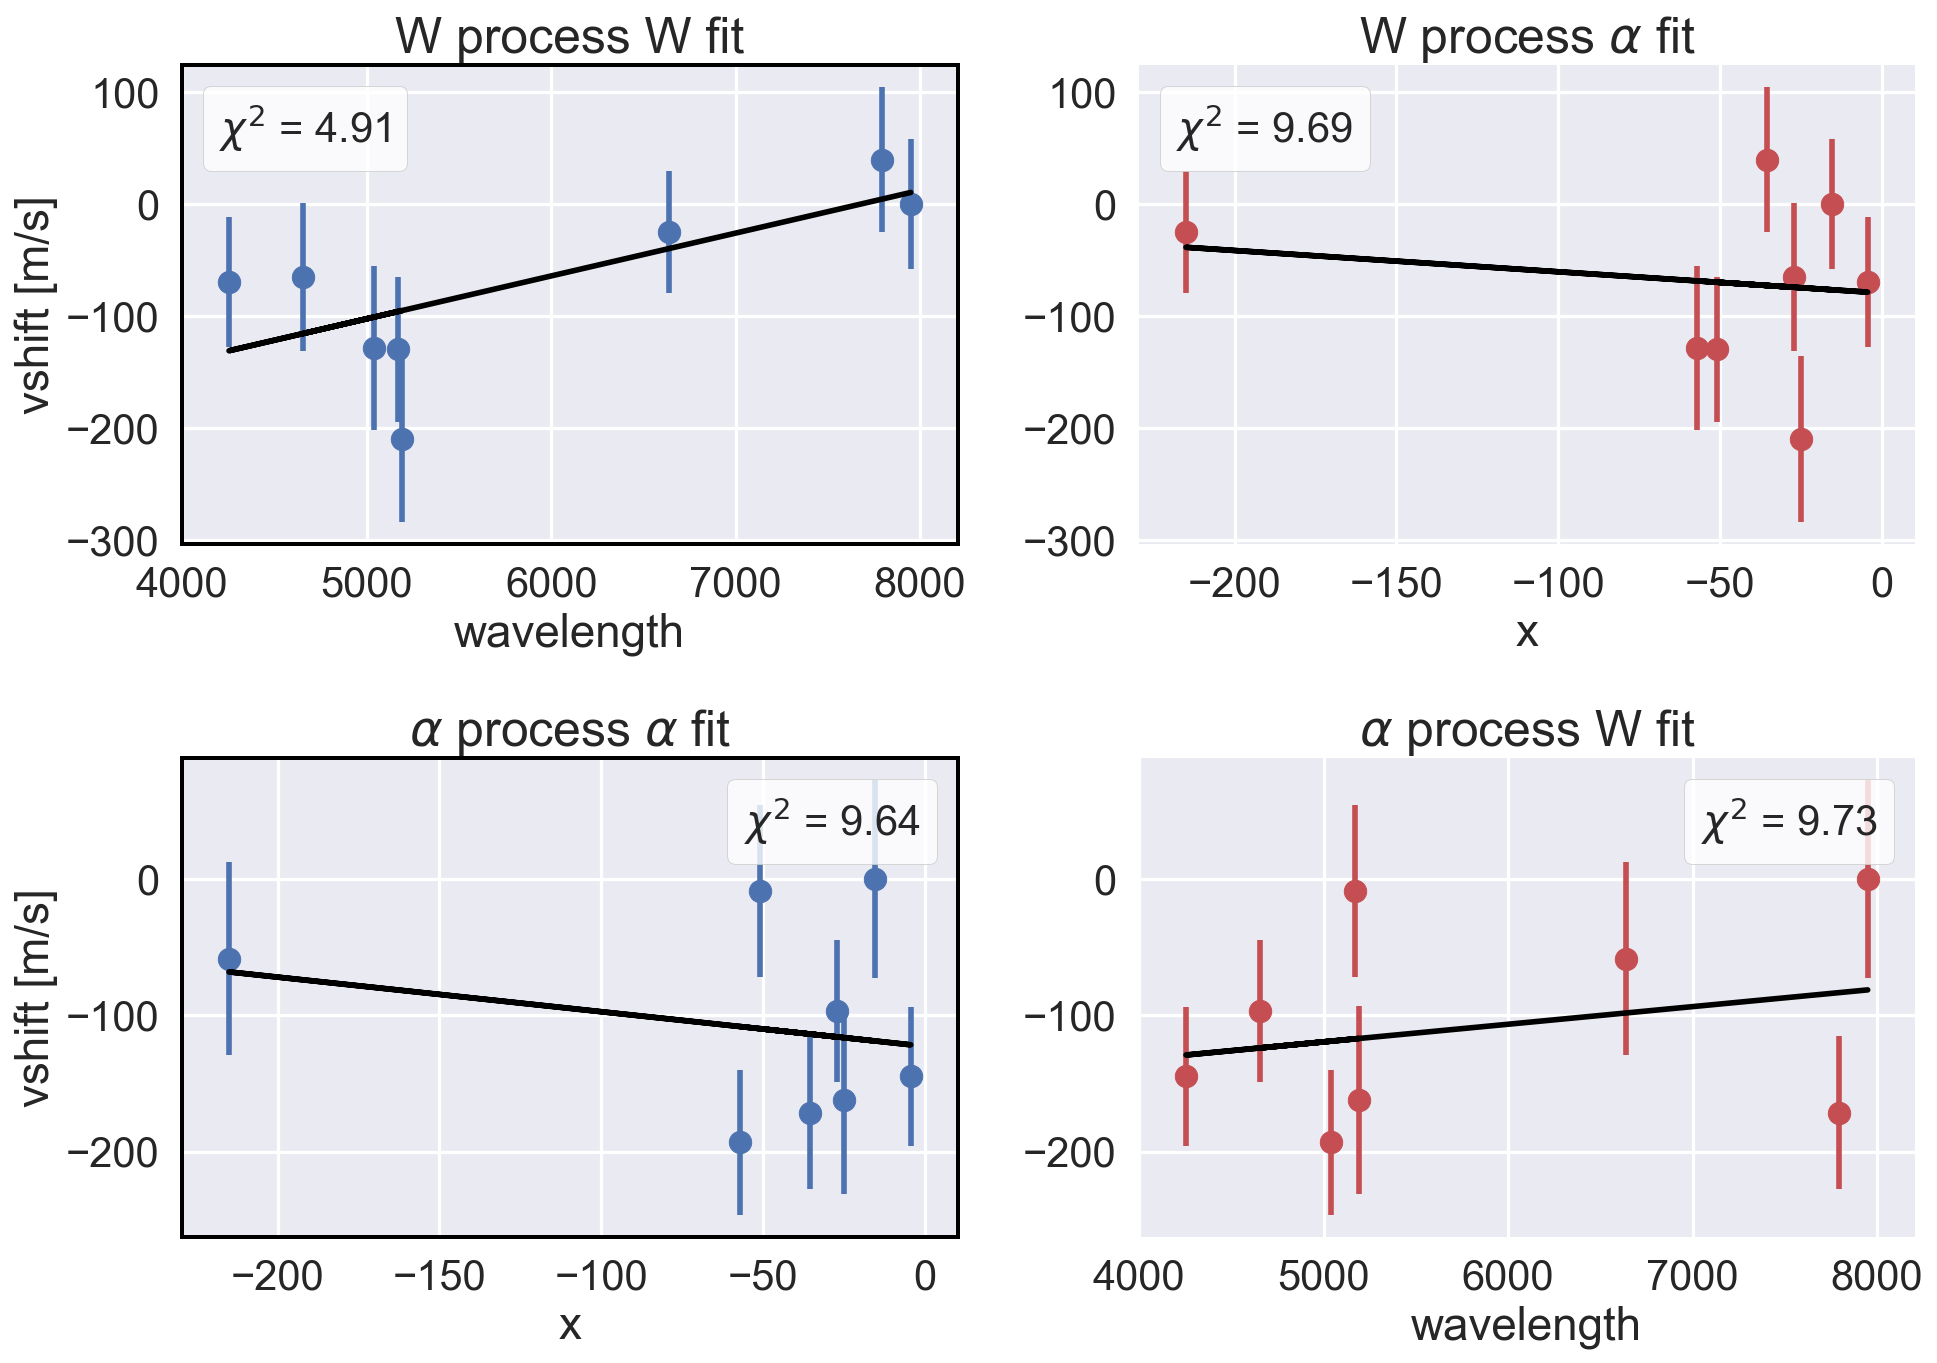

In [15]:
plot_hypotheses(231, df_a, df_w)

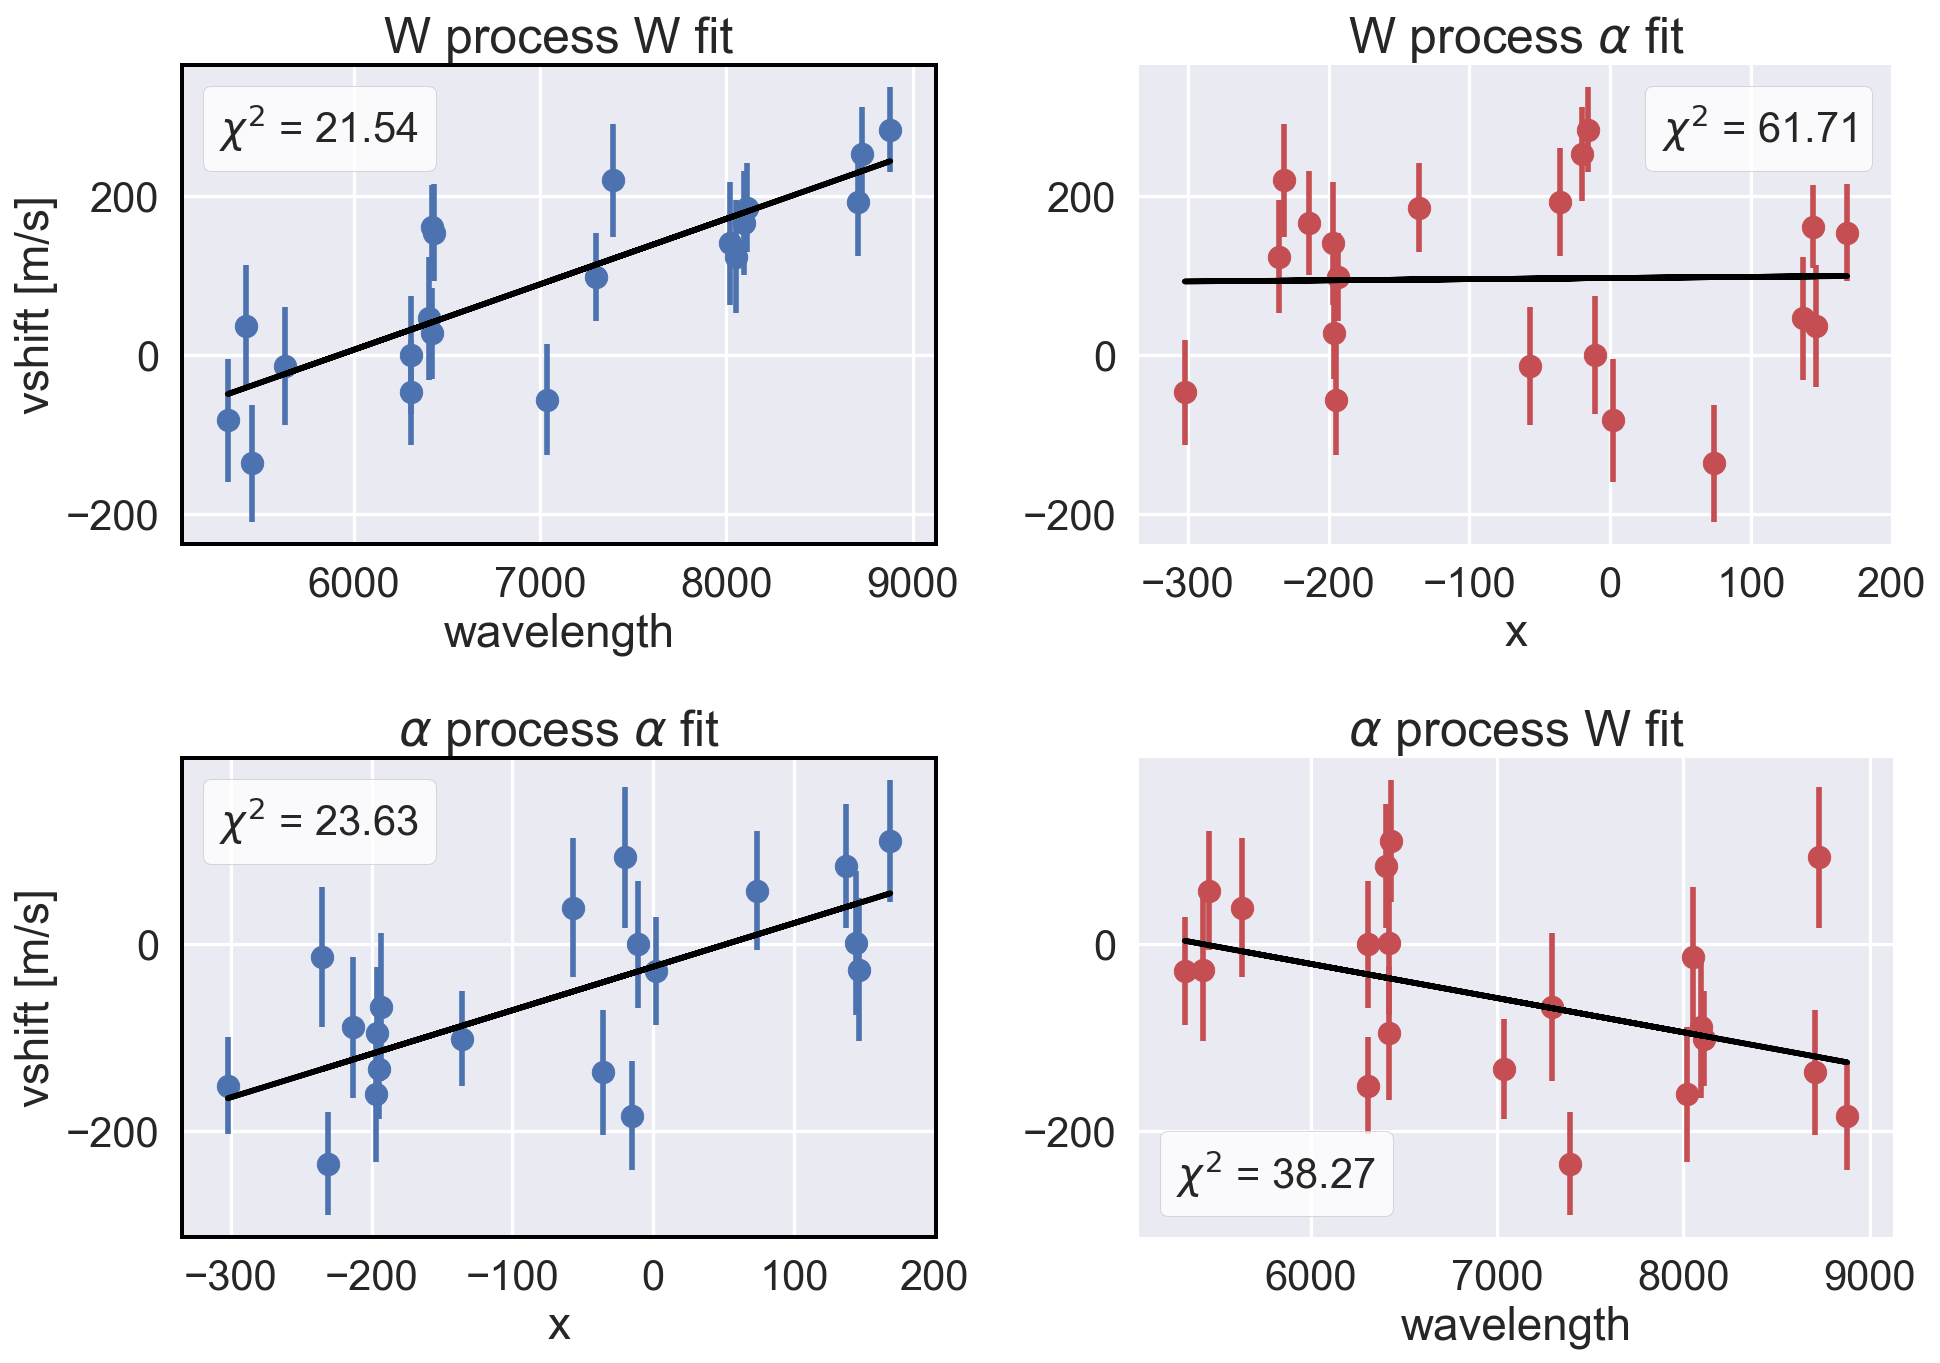

In [70]:
plot_hypotheses(264, df_a, df_w)

In [17]:
df_a[df_a.system==264][['wavelength', 'x', 'vshift', 'sigma']]

wavelength           x      vshift      sigma
1755  6307.606019  -10.570881    0.000000  67.976694
1756  8880.132002  -15.395341 -183.532169  58.355253
1757  8703.930794  -35.545013 -137.297620  66.331114
1758  8726.270535  -20.339554   92.848987  75.616709
1759  7036.901052 -194.518419 -133.810894  53.660659
1760  7296.596596 -193.263758  -67.622065  79.228620
1761  7390.744395 -231.349696 -234.822291  54.856296
1762  8051.204649 -234.963760  -13.484665  74.865876
1763  8093.295722 -213.586285  -88.895179  75.334126
1764  5627.621790  -57.021421   39.181348  74.643997
1765  6400.314994  136.852178   83.482650  66.500987
1766  6418.916085  144.421525    1.191747  77.352706
1767  6431.141238  168.482323  110.252705  65.407266
1768  6306.554306 -302.252500 -151.424592  51.622702
1769  6420.236917 -196.023305  -95.371981  71.310984
1770  5321.313473    2.050106  -28.727743  57.401675
1771  5420.757525  146.189238  -27.174443  76.853809
1772  5453.012154   73.529547   57.321850  63.162448
1773  8020.831197 -197.150297 -160.717142  71.998956
1774  8112.791439 -135.805536 -101.281514  50.916272

In [230]:
chisqs = {# data_hypo
            'x_x':[],
            'x_w':[],
            'w_x':[],
            'w_w':[]}

data = {'x':df_a, 'w':df_w}
for system in sorted(df_w.system.unique()):
    for df in ['x', 'w']:
        for hypo in ['x', 'w']:
            chisq, results = fit_hypothesis(system=system, dataframe1=data[df], hypothesis=hypo)
            chisqs['_'.join([df, hypo])].append(chisq)
for item in chisqs:
    chisqs[item] = np.array(chisqs[item])

In [245]:
np.sum(chisqs['w_x']/chisqs['w_w'] < 1.0) / len(chisqs['w_x'])

0.058020477815699661

In [253]:
np.sum(chisqs['x_x']/chisqs['x_w'] < 1.0) / len(chisqs['w_x'])

0.90443686006825941

In [247]:
all_systems.head()

#J2000   zem     zabs     da    eda sample source  sigflag  \
0  J000149-015940  2.31  2.09510   0.34   7.27     B1   Keck        2   
1  J000149-015940  2.31  2.15390  36.05  39.54     B1   Keck        1   
2  J000322-260316  4.11  1.43420 -12.53  11.67      C   Keck        1   
3  J000322-260316  4.11  3.38970 -78.43  35.48      C   Keck        1   
4  J000520+052410  1.90  0.59137 -31.05  24.33      C   Keck        1   

   imrotator               transition  
0          0  d g h i j k l s t u v w  
1          0                  d f g l  
2          1                  b c p r  
3          1                  d g l m  
4          0              b c n p q r

In [251]:
angles = []
dipole_alphas = []
measured_alphas = []

for index, row in all_systems.iterrows():
    name = row['J2000']
    angles.append(j2000_to_theta(name))
    dipole_alphas.append(dipole_alpha(name))
    measured_alphas.append(row.delta_alpha)

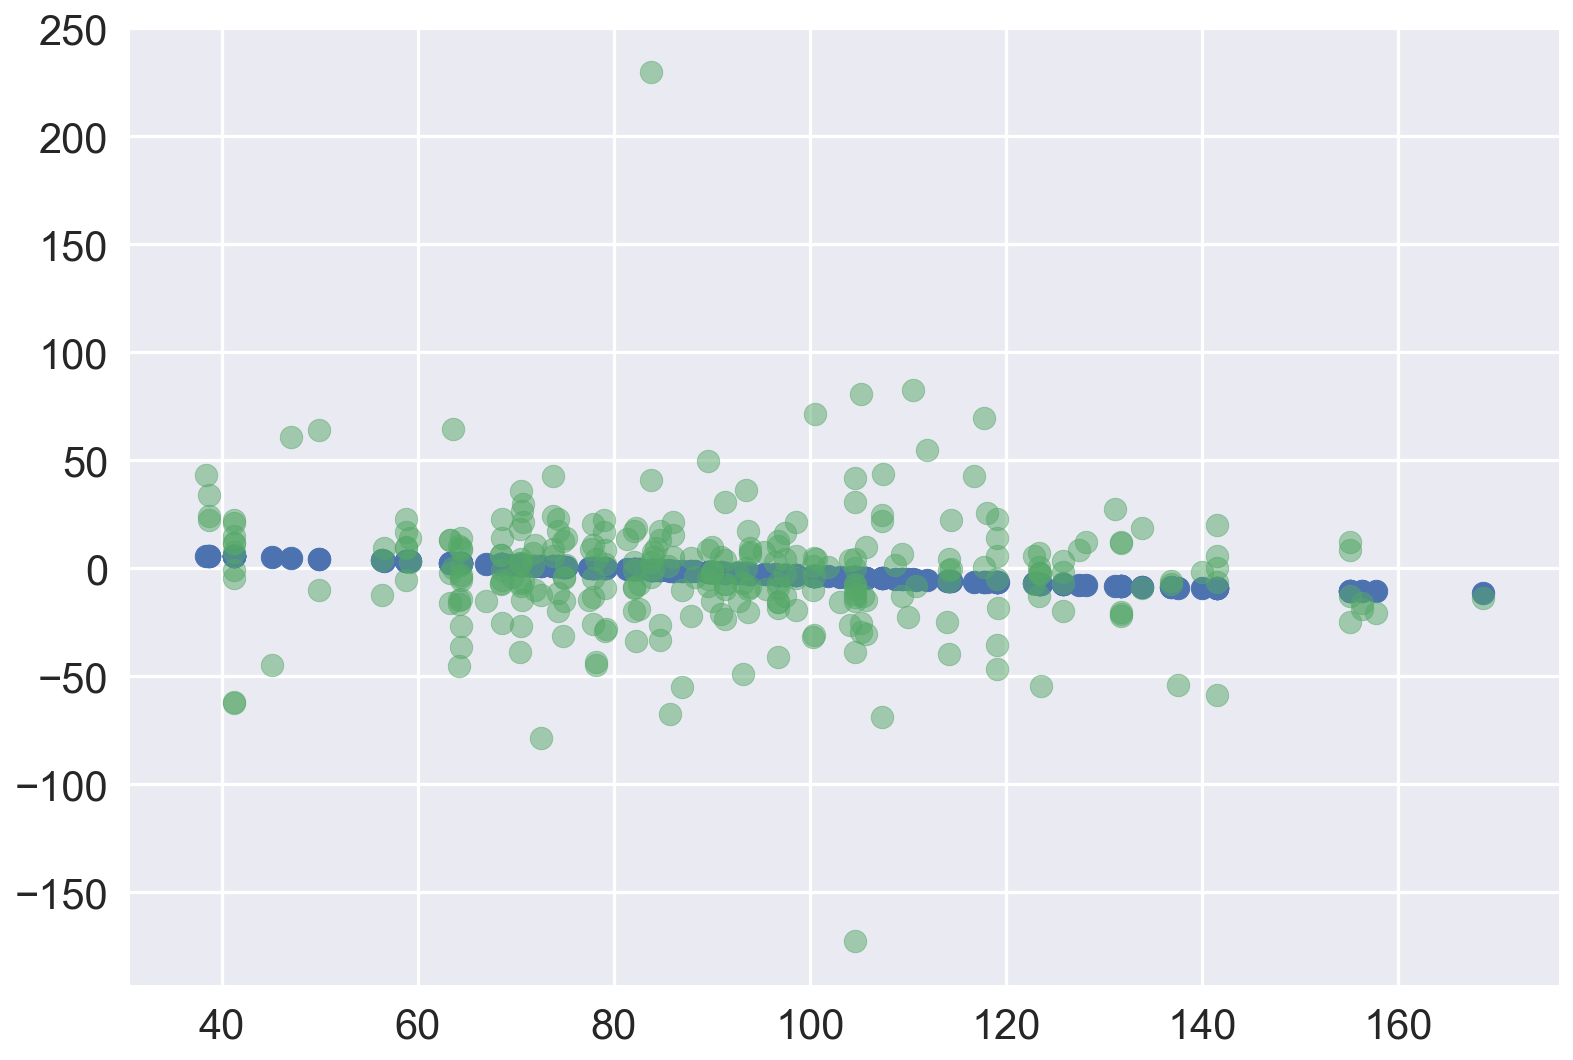

In [264]:
plt.scatter(angles, dipole_alphas)
plt.scatter(angles, measured_alphas, alpha=0.5)

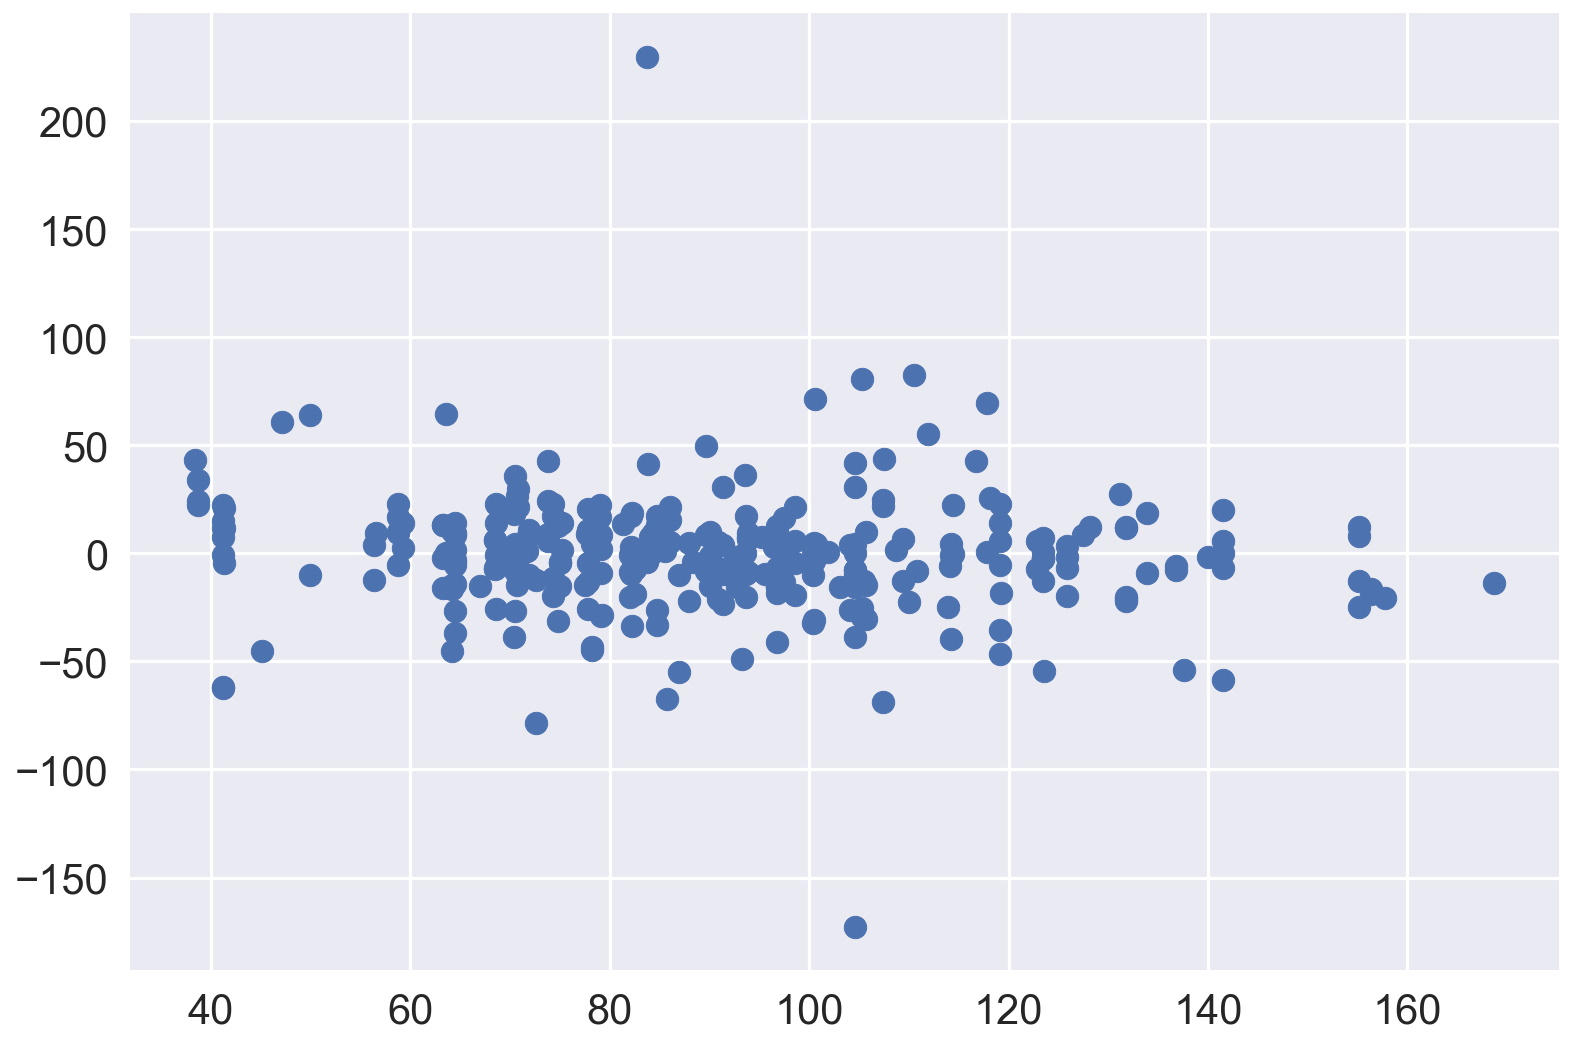

In [263]:
plt.scatter(angles, measured_alphas)

In [ ]:
# Todo: ipywidgets minimization of spline + offsets for vshift

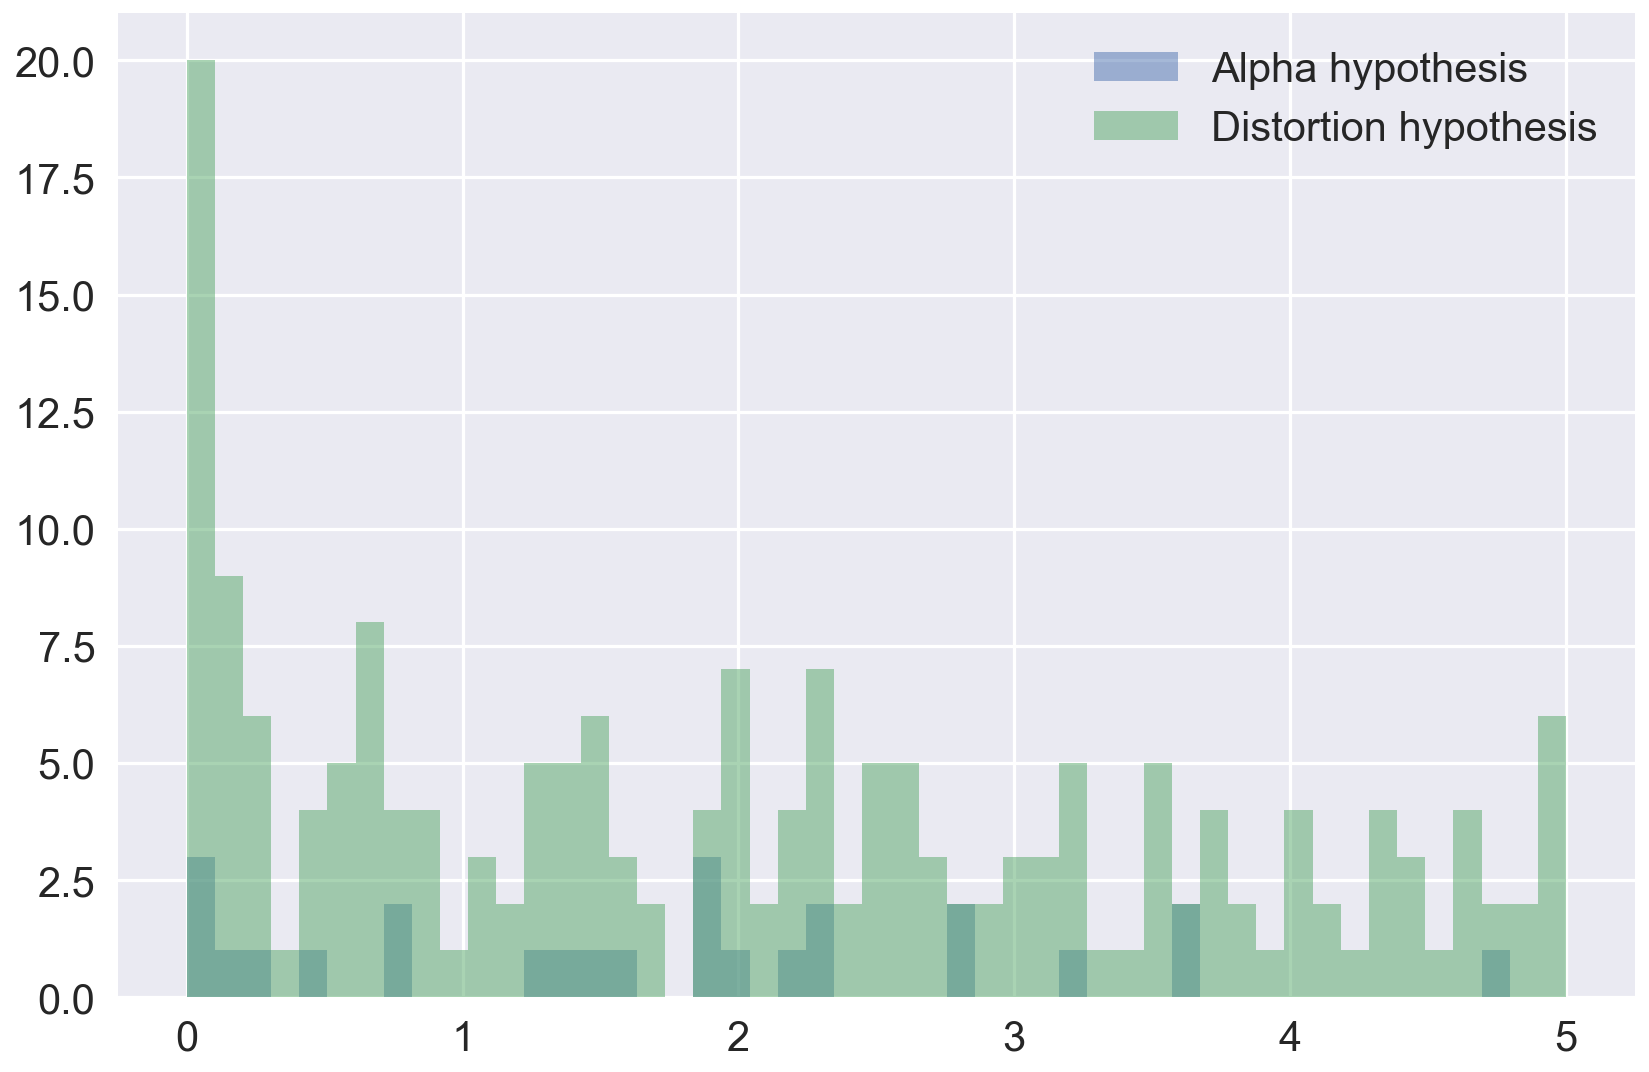

In [329]:
alpha = []
distortion = []
for (index, g) in df2.groupby('system'):
    X = sm.add_constant(g.x)
    model = sm.WLS(g.vshift, X, weights=1.0/g.sigma)
    results = model.fit()
    chisq = np.sum((g.vshift - results.fittedvalues)**2.0 / (g.sigma) ** 2.0)
    if chisq < 1e7:
        alpha.append(chisq)
    
    X = sm.add_constant(g.wavelength)
    model = sm.WLS(g.vshift, X, weights=1.0/g.sigma)
    results = model.fit()
    chisq = np.sum((g.vshift - results.fittedvalues)**2.0 / (g.sigma) ** 2.0)
    if chisq < 1e10:
        distortion.append(chisq)

alpha = np.array(alpha)
distortion = np.array(distortion)
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(alpha, alpha=0.5, 
                bins=np.linspace(0, 5, 50),
        label='Alpha hypothesis')
ax.hist(distortion, alpha=0.5, 
                        bins=np.linspace(0, 5, 50),
        label='Distortion hypothesis')
# ax.hist(alpha / distortion, 
#         bins=np.linspace(0, 5, 50), 
#         label='Wavelength',
#         alpha=0.5)
# ax.set_xlim(0, 5.0, )
ax.legend()
fig.tight_layout()

# Alpha measurements as proxies for wavelength distortions

We have many measurements of $\alpha$ on both the [Keck](https://en.wikipedia.org/wiki/W._M._Keck_Observatory) and [VLT](https://en.wikipedia.org/wiki/Very_Large_Telescope) telescopes. Measurements with spectrographs both telescopes reveal statistically significant (though small in absolute terms) differences between the expected positions of absorption lines and the measured positions. 


## Hypothesis tests or statistical inference

There are many possible hypotheses that could explain these differences. To list just two: 

 - the value of the fine-structure constant ($\alpha$) has changed
 - there are velocity distortions in the instrument.
 
We can consider any velocity shift measurements as a hypothesis test. Previous studies started with the assumption that any shift in absorption lines would come as a result of a change in $\alpha$. We have the reported $\frac{\Delta \alpha}{\alpha}$ values for both the Keck and VLT samples. If we invert the hypothesis: use the measured alpha values as a system of velocity shifts, we can effectively discriminate which hypothesis best fits the data.

## Simulations

The goal will be to simulate what the velocity shifts look like if the dipole model is correct, and compare that to what we currently see.


## Discussion

The end goal of this analysis is ultimately a change in how $\frac{\Delta \alpha}{\alpha}$ is measured. The proposed recipe is:

 1. Create the best fit velocity structure as usual.
 2. Fit for relative velocity shifts between all lines (`vpfit` already allows for this).
 3. Combine all velocity shifts for all measured systems with a particular telescope.
 4. Use standard hypothesis statistical tests to discriminate the most likely hypothesis: a wavelength distortion model, or a change in the fine-structure constant.

This will likely have rather low power for any single absorption system, but for ensembles, I think that it's likely the only case 



## Useful References (in reverse chronological order)

 - [Modeling long-range wavelength distortions in quasar absorption echelle spectra](https://arxiv.org/abs/1701.03176) (2017) by Vincent Dumont, John K. Webb
 - [Artificial intelligence applied to the automatic analysis of absorption spectra. Objective measurement of the fine structure constant](https://arxiv.org/abs/1606.07393) (2016) by Matthew B. Bainbridge, John K. Webb
 - [Impact of instrumental systematic errors on fine-structure constant measurements with quasar spectra](https://arxiv.org/abs/1409.4467) (2014) by Jonathan B. Whitmore, Michael T. Murphy
 
 - [Bayesian Approach Overview (pdf)](http://adsabs.harvard.edu/cgi-bin/nph-data_query?bibcode=2014MmSAI..85...96C&link_type=ARTICLE&db_key=AST&high=) by Ewan Cameron, Tony Pettitt
 - [Bayesian Approach 1](https://arxiv.org/abs/1207.6223) by Ewan Cameron, Tony Pettitt
 - [Bayesian Approach 2](https://arxiv.org/abs/1309.2737) by Ewan Cameron, Tony Pettitt
 
 - [Spatial variation in the fine-structure constant -- new results from VLT/UVES](https://arxiv.org/abs/1202.4758) (2012) by Julian A. King, John K. Webb, Michael T. Murphy, Victor V. Flambaum, Robert F. Carswell, Matthew B. Bainbridge, Michael R. Wilczynska, F. Elliot Koch
 - [Further evidence for a variable fine-structure constant from Keck/HIRES QSO absorption spectra](https://arxiv.org/abs/astro-ph/0306483) (2003) by Michael T. Murphy, John K. Webb, Victor V. Flambaum
 - [Does the fine structure constant vary? A detailed investigation into systematic effects](https://arxiv.org/abs/astro-ph/0210532) (2002) by M. T. Murphy, J. K. Webb, V. V. Flambaum, S. J. Curran


In [5]:
species = set([spec[0] for spec in qvals.index.str.split('I')])
colors = sns.color_palette(n_colors=len(species))
plot_colors = {}
for index, specie in enumerate(sorted(species)):
    plot_colors[specie] = colors[index]

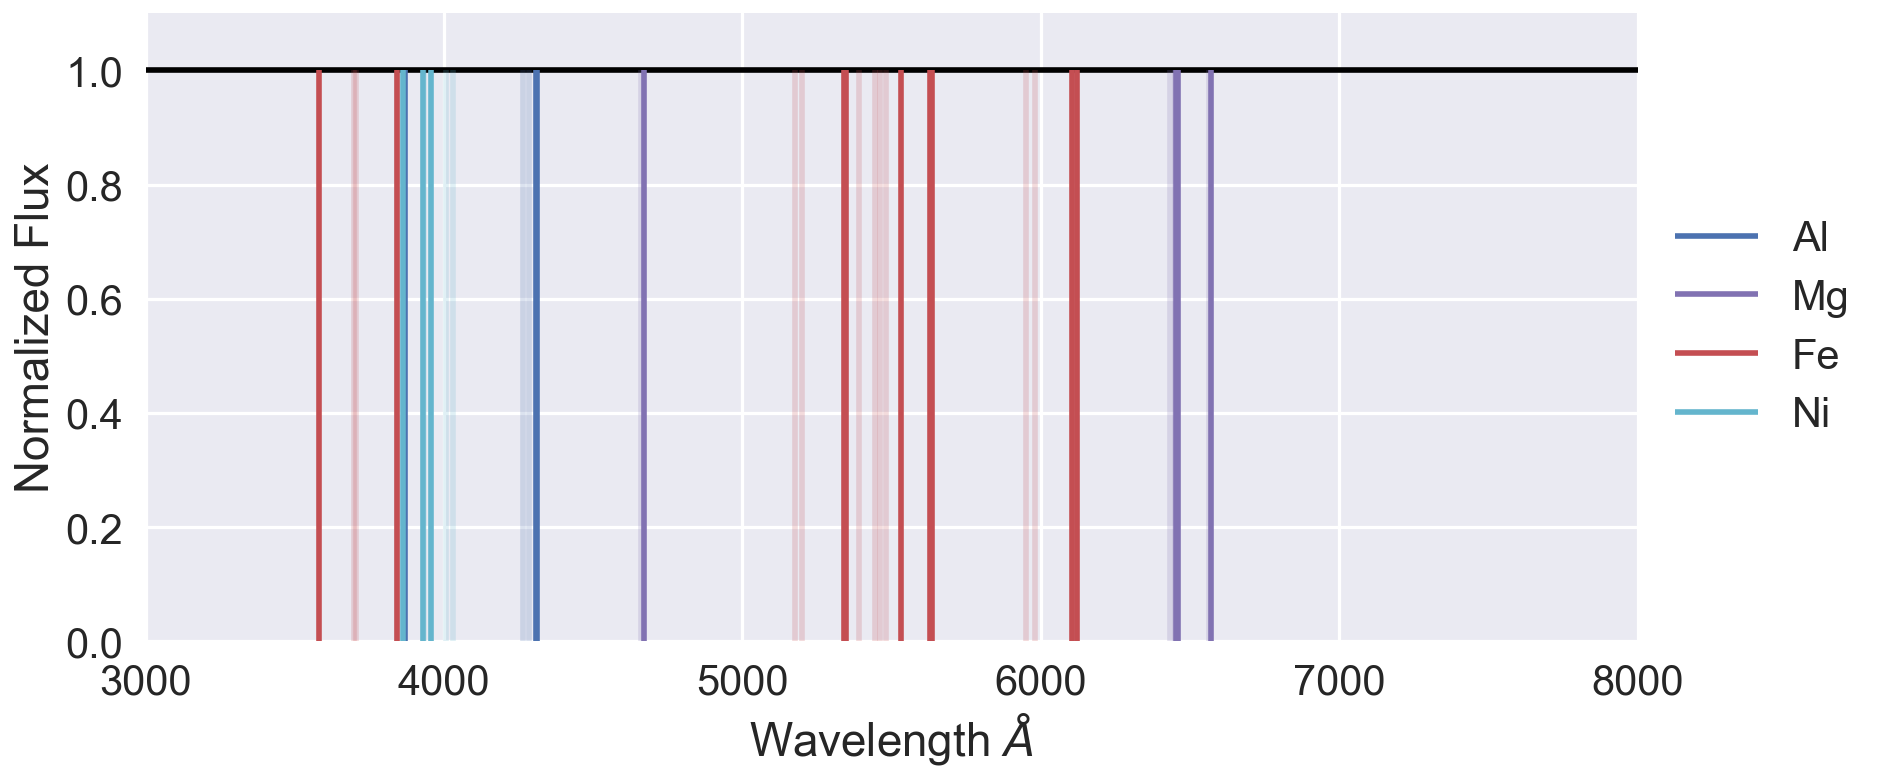

In [11]:
def plot_absorption(specie=['Al', 'Mg'],
                    z=1.3,
                    daa=0.05,
                   ):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hlines(1, 0, 10000)
    for tran, row in qvals[qvals.index.str.startswith(tuple(specie))].iterrows():
        ax.vlines((1.0 + z) * row.wave + row.qval * ((daa + 1)**2.0-1.0), 
                      0, 1, color=plot_colors[tran[:2]])
        ax.vlines((1.0 + z) * row.wave, 
                      0, 1, color=plot_colors[tran[:2]], alpha=0.2)
        
    ax.set_xlim(3000, 8e3)
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Normalized Flux")
    ax.set_xlabel(r"Wavelength $\AA$")
    
    for spec in specie:
        ax.vlines(-1, -1, 0, color=plot_colors[spec], label=spec)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()

plot_absorption(specie=['Al', 'Mg', 'Fe', 'Ni'], )

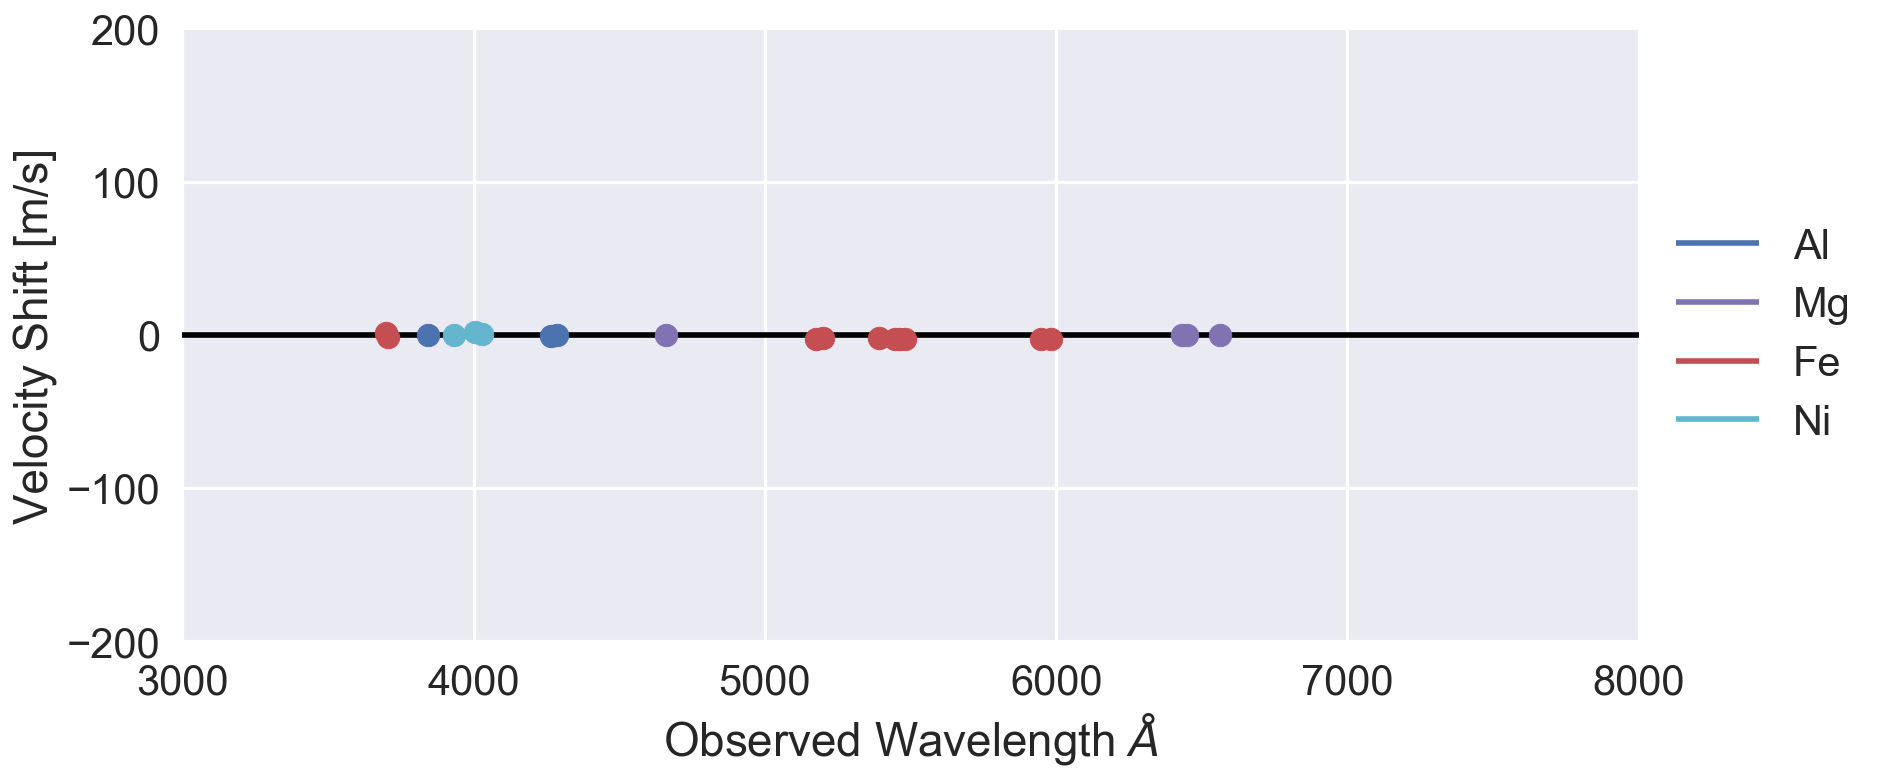

In [51]:
def plot_shift(specie=['Al', 'Mg'],
                    z=1.3,
                    daa=0.05,
                   ):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hlines(0, 0, 10000)
    for tran, row in qvals[qvals.index.str.startswith(tuple(specie))].iterrows():
        ax.scatter((1.0 + z) * row.wave, 
#                    row.qval * ((daa + 1)**2.0-1.0),
                   shifted_velocity(daa, row.qval, (1.0 + z) * row.wave),
                   color=plot_colors[tran[:2]], zorder=3)
        
    ax.set_xlim(3000, 8e3)
    ax.set_ylim(-200, 200)
    ax.set_ylabel("Velocity Shift [m/s]")
    ax.set_xlabel(r"Observed Wavelength $\AA$")
    
    for spec in specie:
        ax.vlines(-1, -1, 0, color=plot_colors[spec], label=spec, zorder=-3)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()

plot_shift(specie=['Al', 'Mg', 'Fe', 'Ni'], )

In [52]:
redshift_slider = FloatSlider(value=2.1, min=0.0, max=3.5)
alpha_slider = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1)
species_select = SelectMultiple(options=['Al', 'Cr', 'Fe', 'Mg', 'Mn', 'Ni', 'Si'],
                                description="Species",
                                value=['Al', 'Fe']
                               )
# w = interactive(plot_absorption, 
#                 specie=species_select,
#                 z=redshift_slider,
#                 daa=alpha_slider,
#                )
shift_interactive = interactive(plot_shift, 
                specie=species_select,
                z=redshift_slider,
                daa=alpha_slider,
               )

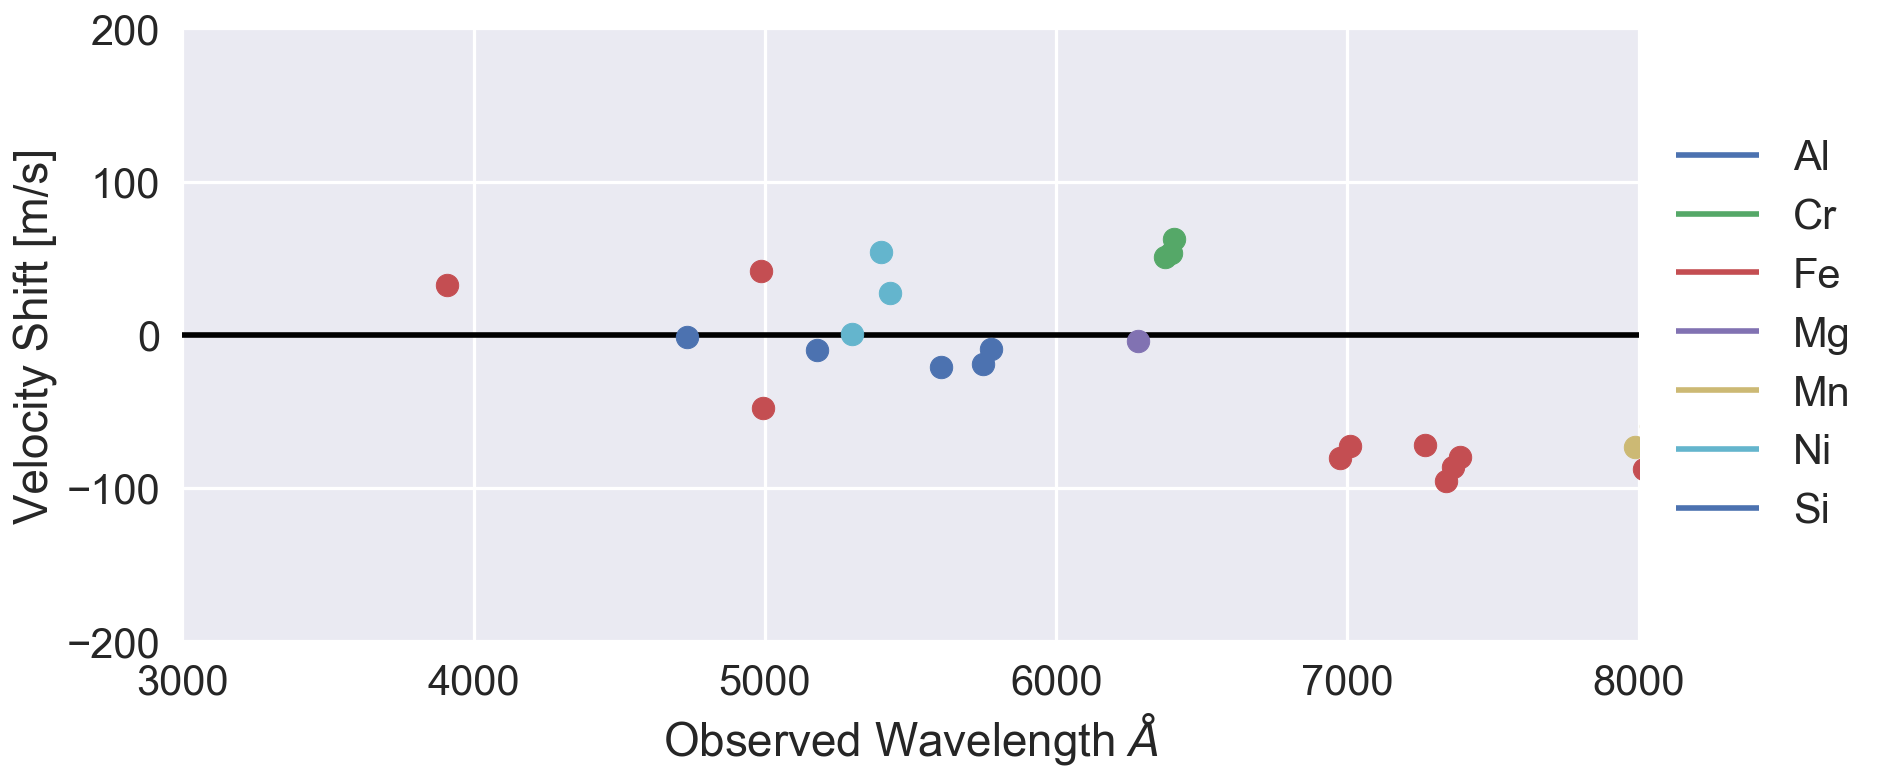

In [53]:
shift_interactive

In [42]:
all_systems.head()

#J2000   zem     zabs     da    eda sample source  sigflag  \
0  J000149-015940  2.31  2.09510   0.34   7.27     B1   Keck        2   
1  J000149-015940  2.31  2.15390  36.05  39.54     B1   Keck        1   
2  J000322-260316  4.11  1.43420 -12.53  11.67      C   Keck        1   
3  J000322-260316  4.11  3.38970 -78.43  35.48      C   Keck        1   
4  J000520+052410  1.90  0.59137 -31.05  24.33      C   Keck        1   

   imrotator               transition  
0          0  d g h i j k l s t u v w  
1          0                  d f g l  
2          1                  b c p r  
3          1                  d g l m  
4          0              b c n p q r

In [15]:
def plot_shifts(telescope='VLT'):
    fig, ax = plt.subplots(figsize=(12, 6))
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.2}, ax=ax)
    ax.set_ylim(-200, 200)
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title(telescope)
    fig.tight_layout()

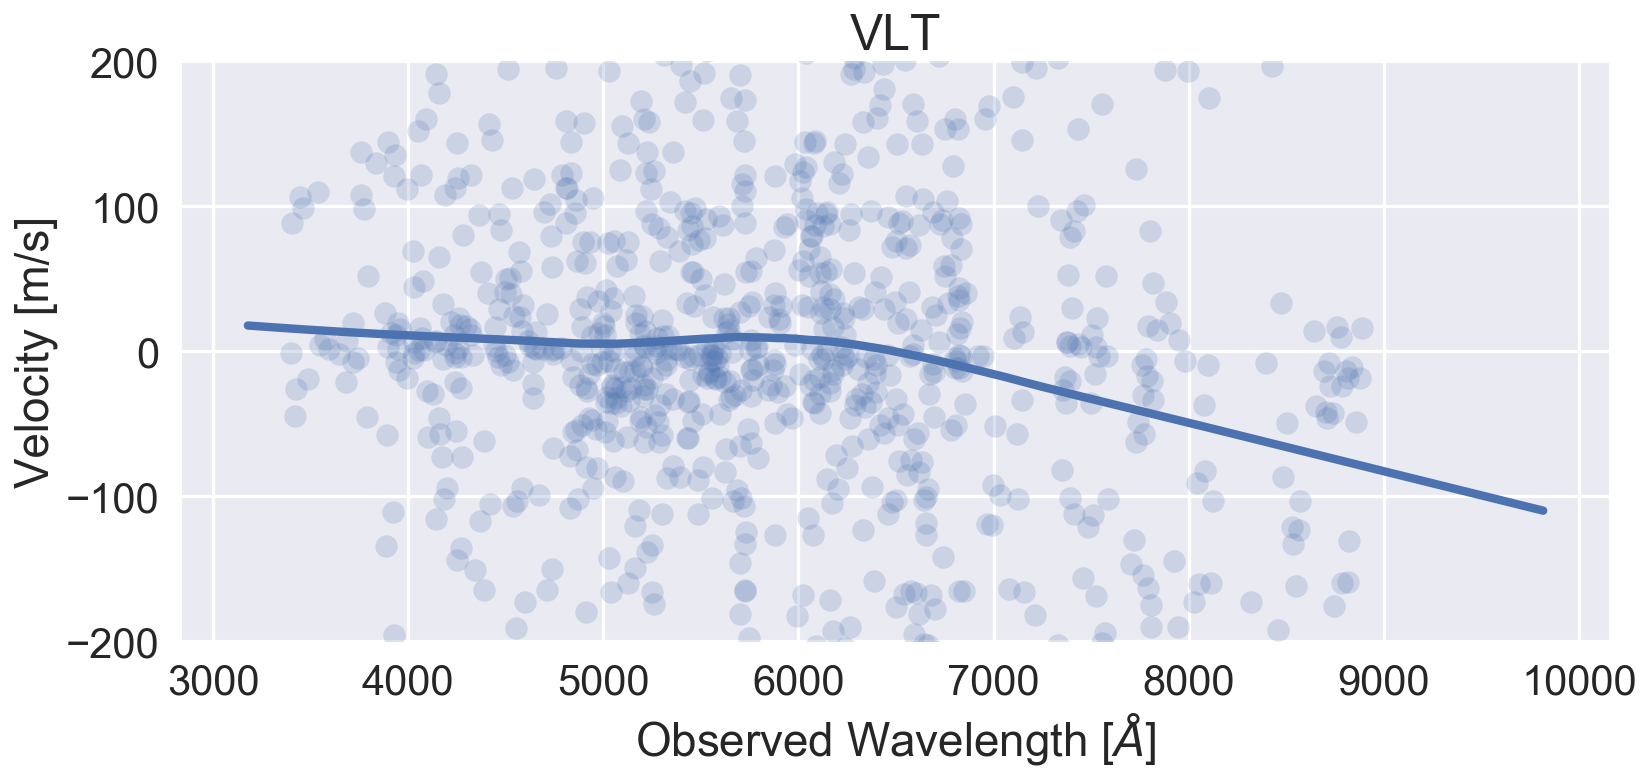

In [16]:
plot_shifts(telescope='VLT')

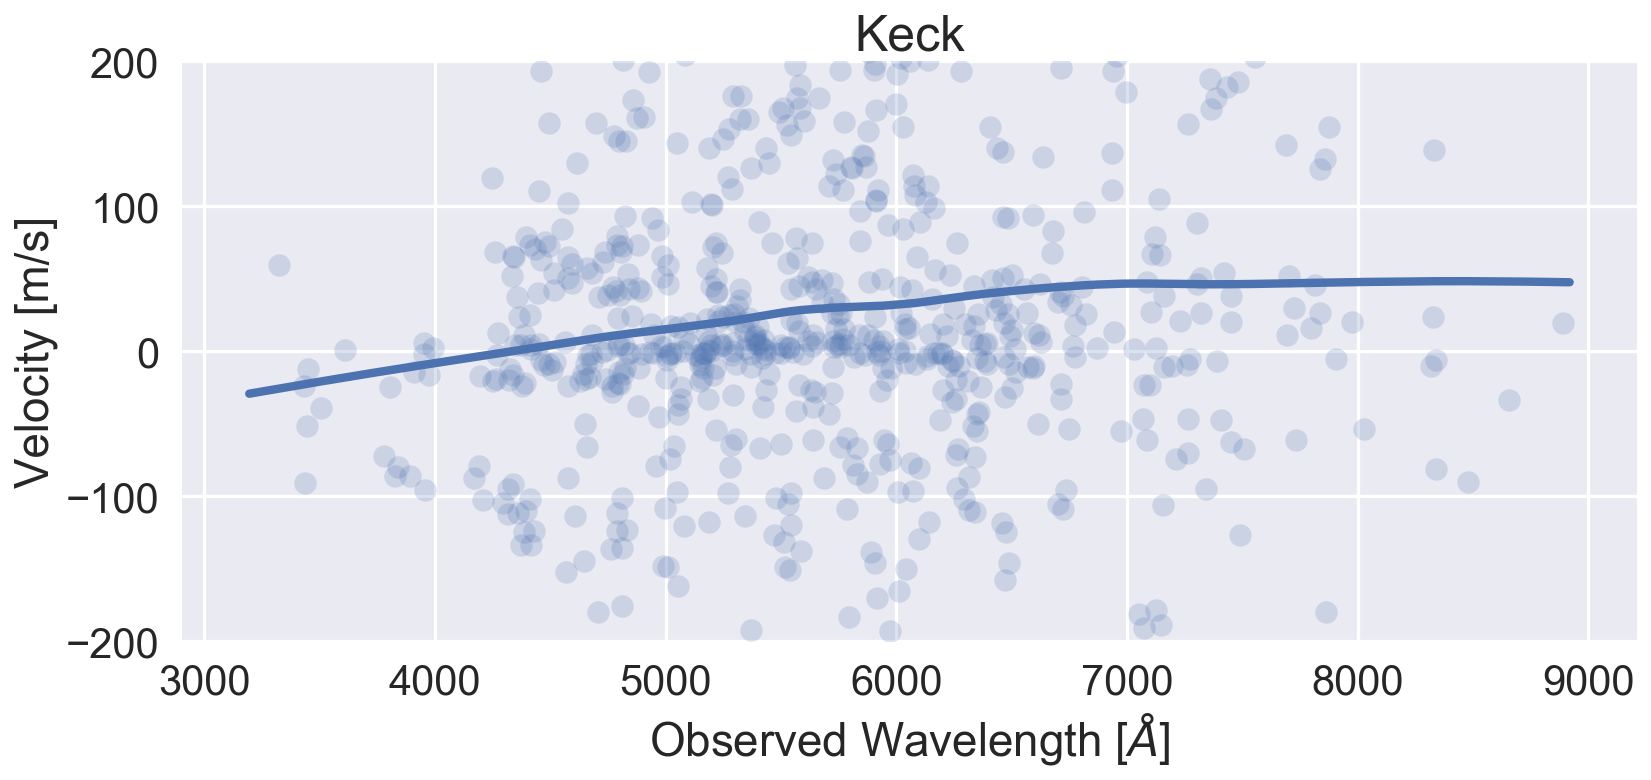

In [17]:
plot_shifts(telescope='Keck')

In [59]:
def plot_all(title='Keck + VLT'):
    fig, ax = plt.subplots(figsize=(12, 8))
    telescope='VLT'
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.5}, ax=ax, label=telescope)
    telescope='Keck'
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.5}, ax=ax, label=telescope)
    ax.set_xlim(2000, 10000)
    ax.set_ylim(-200, 200)
    ax.legend()
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title(title)
    fig.tight_layout()

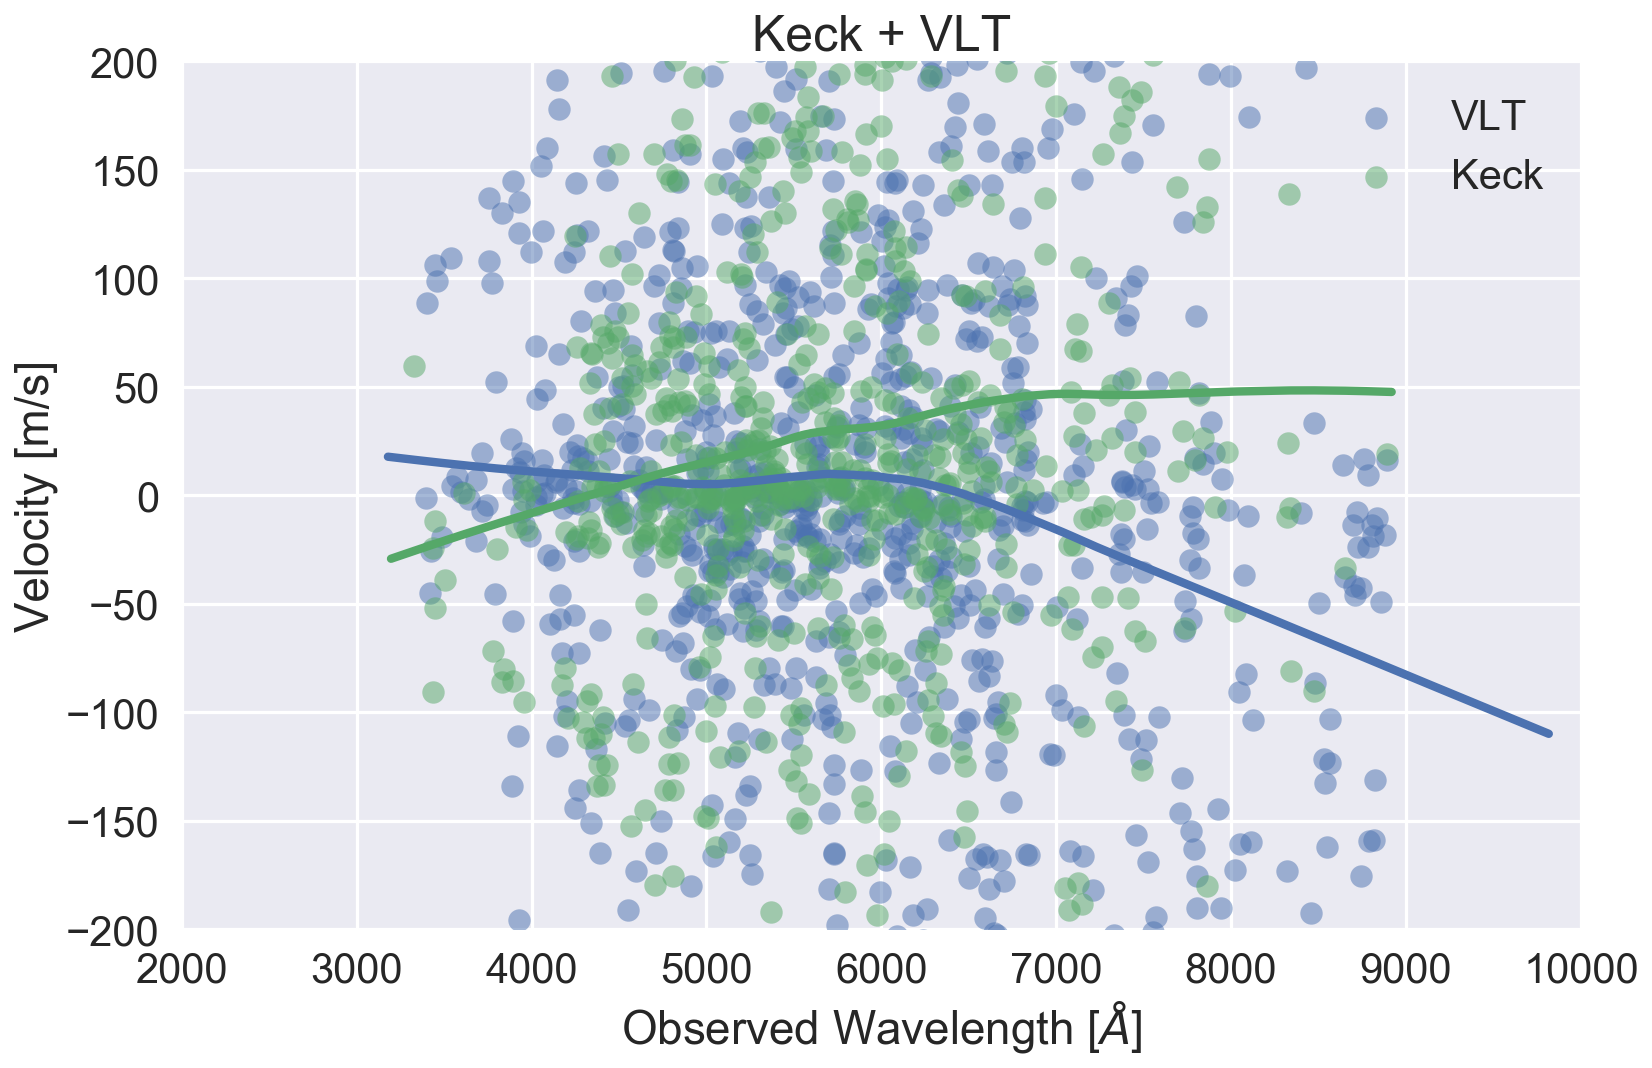

In [60]:
plot_all()

In [61]:
def observed_shifts_by_sample(sample='A'):
    waves = []
    shifts = []
    for index, row in all_systems[all_systems['sample'] == sample].iterrows():
        for tran in row['transitions'].split():
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.z_absorption)
            qval = qvals.loc[codes.loc[tran].trans].qval
            waves.append(measured_wave)
            shifts.append(shifted_velocity(row.delta_alpha, qval, rest_wave))
    return np.array(waves), np.array(shifts)

def plot_samples():
    fig, ax = plt.subplots(figsize=(12, 8))
    telescope='VLT'
    for sample in sorted(all_systems['sample'].unique()):
        w, s = observed_shifts_by_sample(sample=sample)
        sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.5}, ax=ax, label=sample)
    ax.set_ylim(-400, 400)
    ax.set_xlim(2000, 10000)
    ax.legend()
#     frame = ax.get_frame()
#     frame.set_alpha(1.0)
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title('Samples')
    fig.tight_layout()

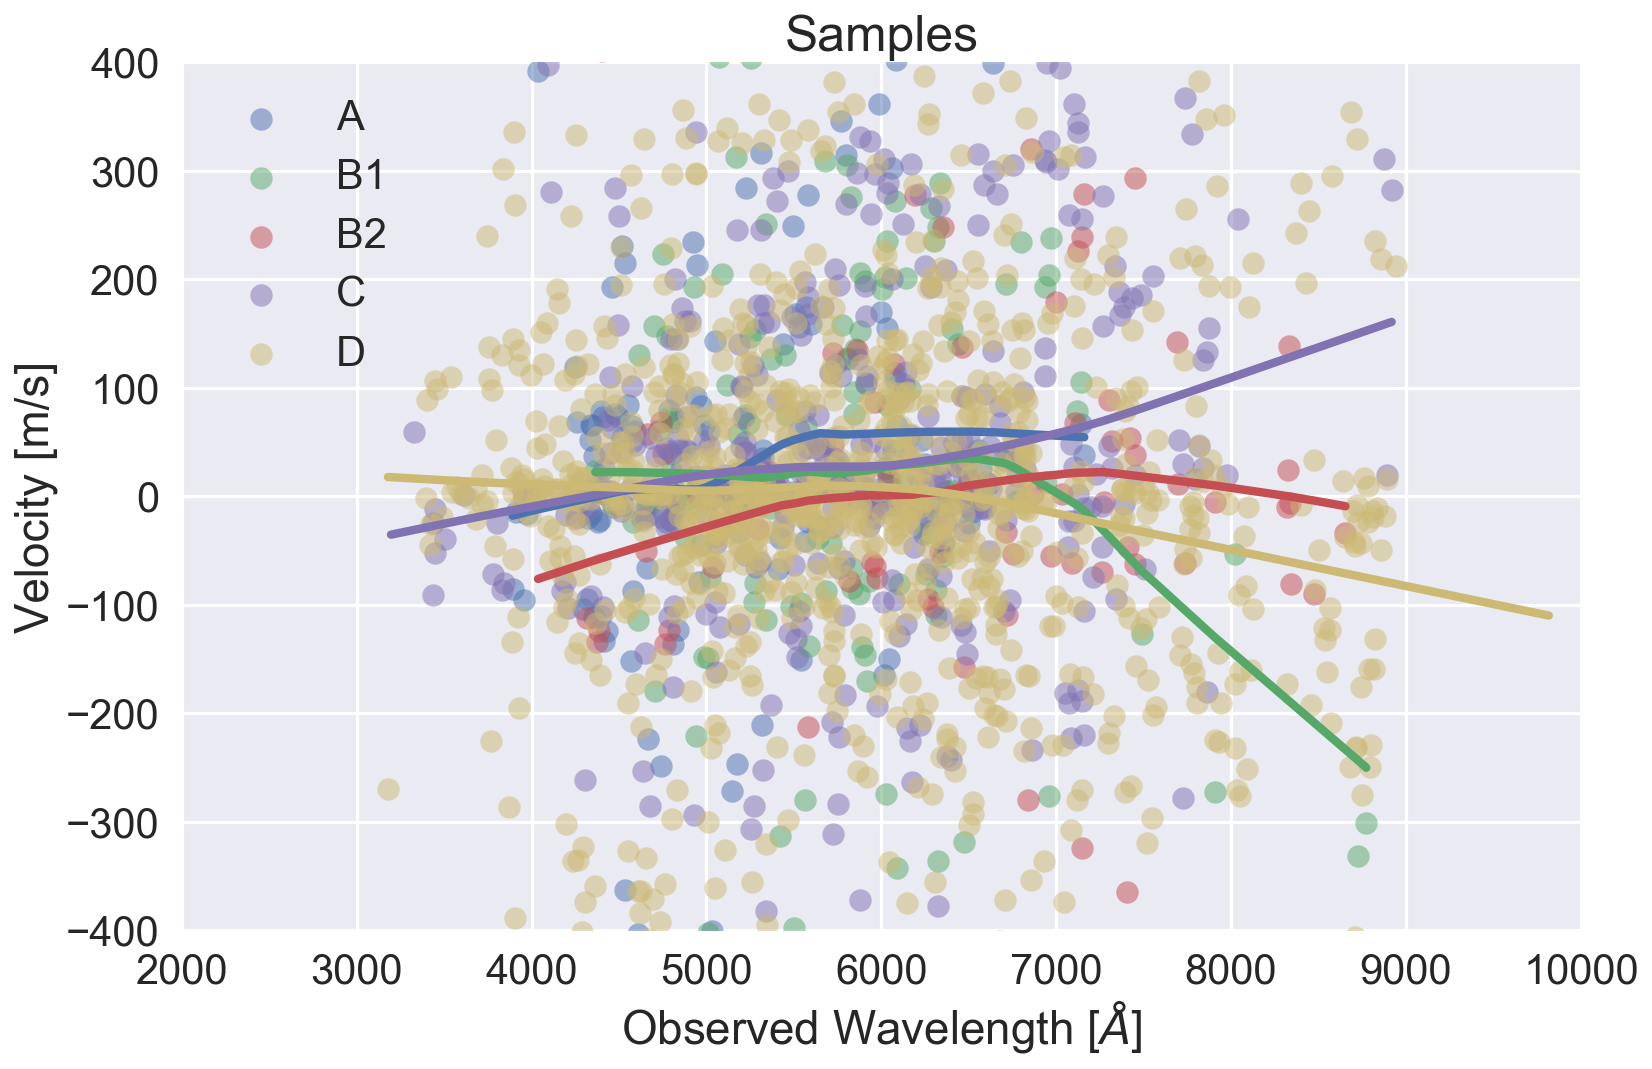

In [62]:
plot_samples()

## Simulations

Generate velocity shifts for the dipole hypothesis.

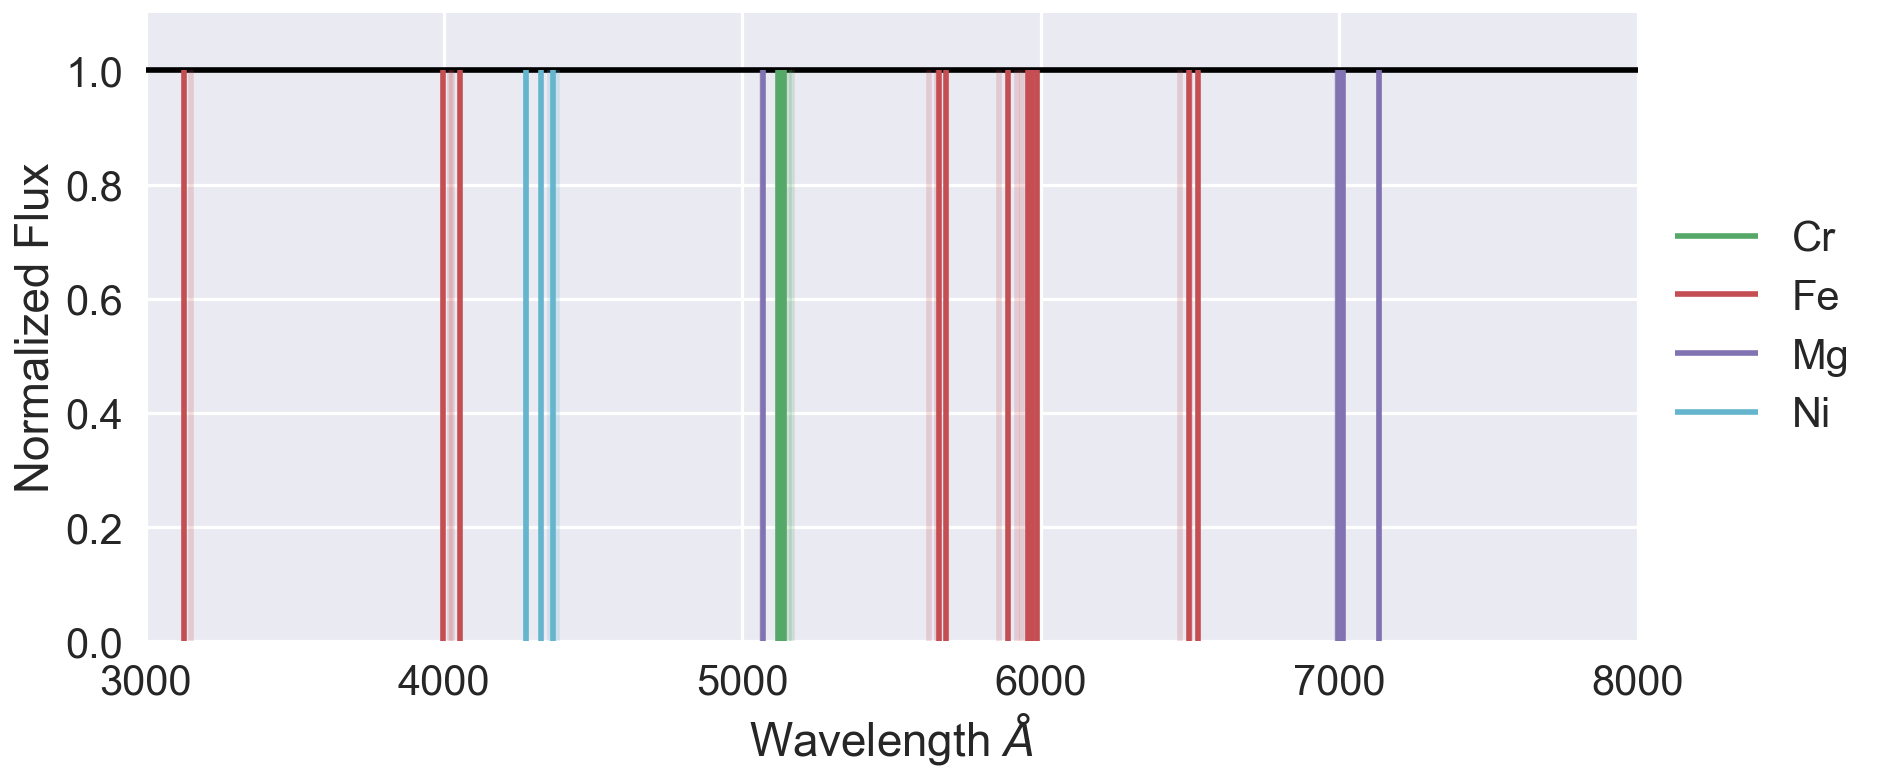

In [54]:
w

In [74]:
def plot_sim(telescope='VLT', use_dipole=True):
    fig, ax = plt.subplots(figsize=(12, 6))
    w, s = observed_shifts(telescope=telescope)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.05}, ax=ax, label='Implied by Measured VLT')
    w, s = simulated_shifts(telescope=telescope, use_dipole=use_dipole)
    sns.regplot(w, s, lowess=True, scatter_kws={'alpha':0.05}, ax=ax, label='Implied by Dipole VLT')
    ax.set_ylim(-200, 200)
    ax.legend()
    ax.set_xlabel(r"Observed Wavelength [$\AA$]")
    ax.set_ylabel("Velocity [m/s]")
    ax.set_title('Simulated velocity shifts for ' + telescope)
    fig.tight_layout()

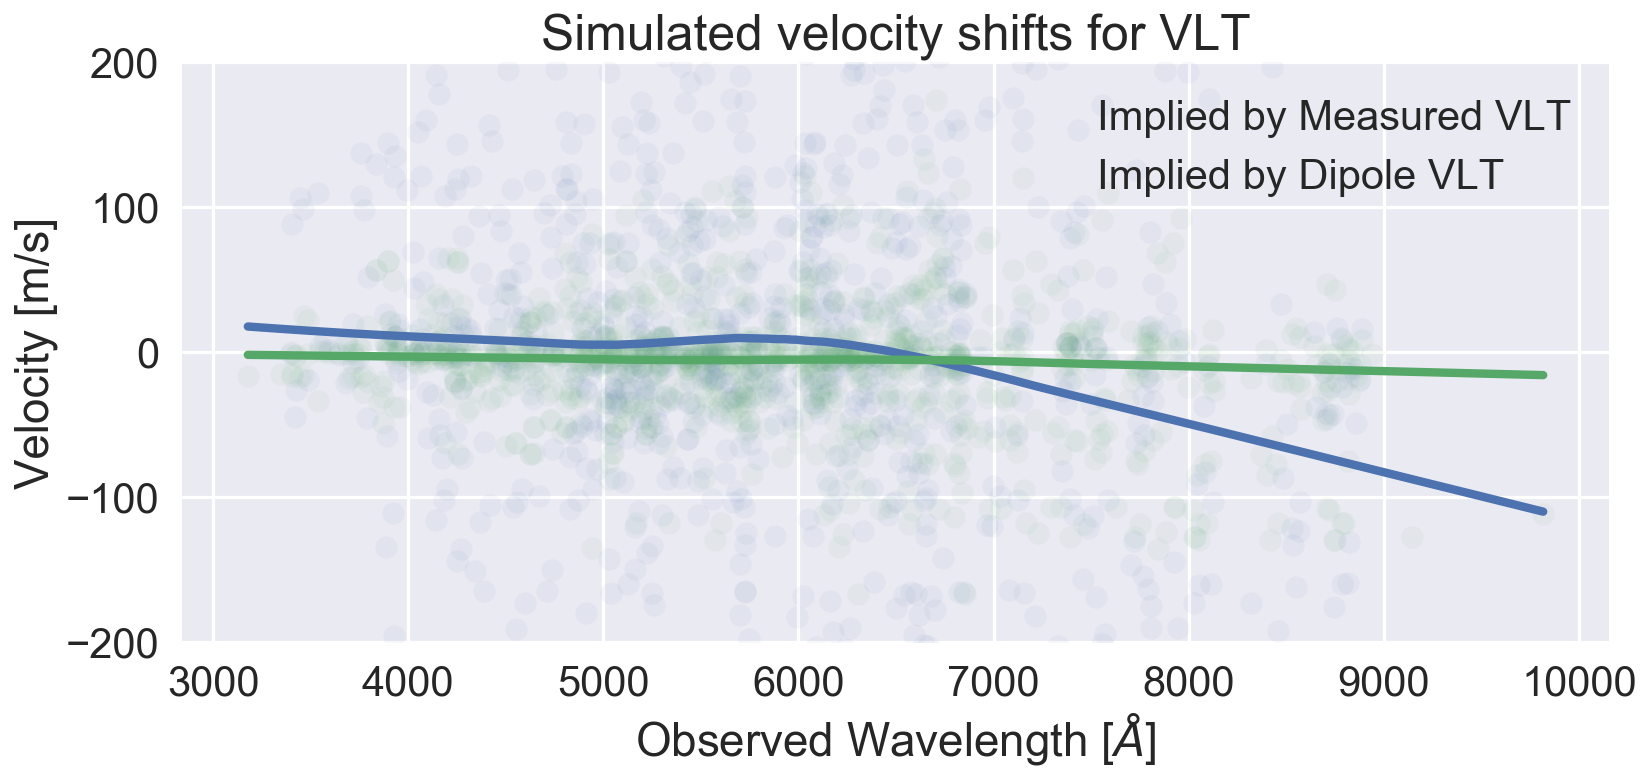

In [75]:
plot_sim()

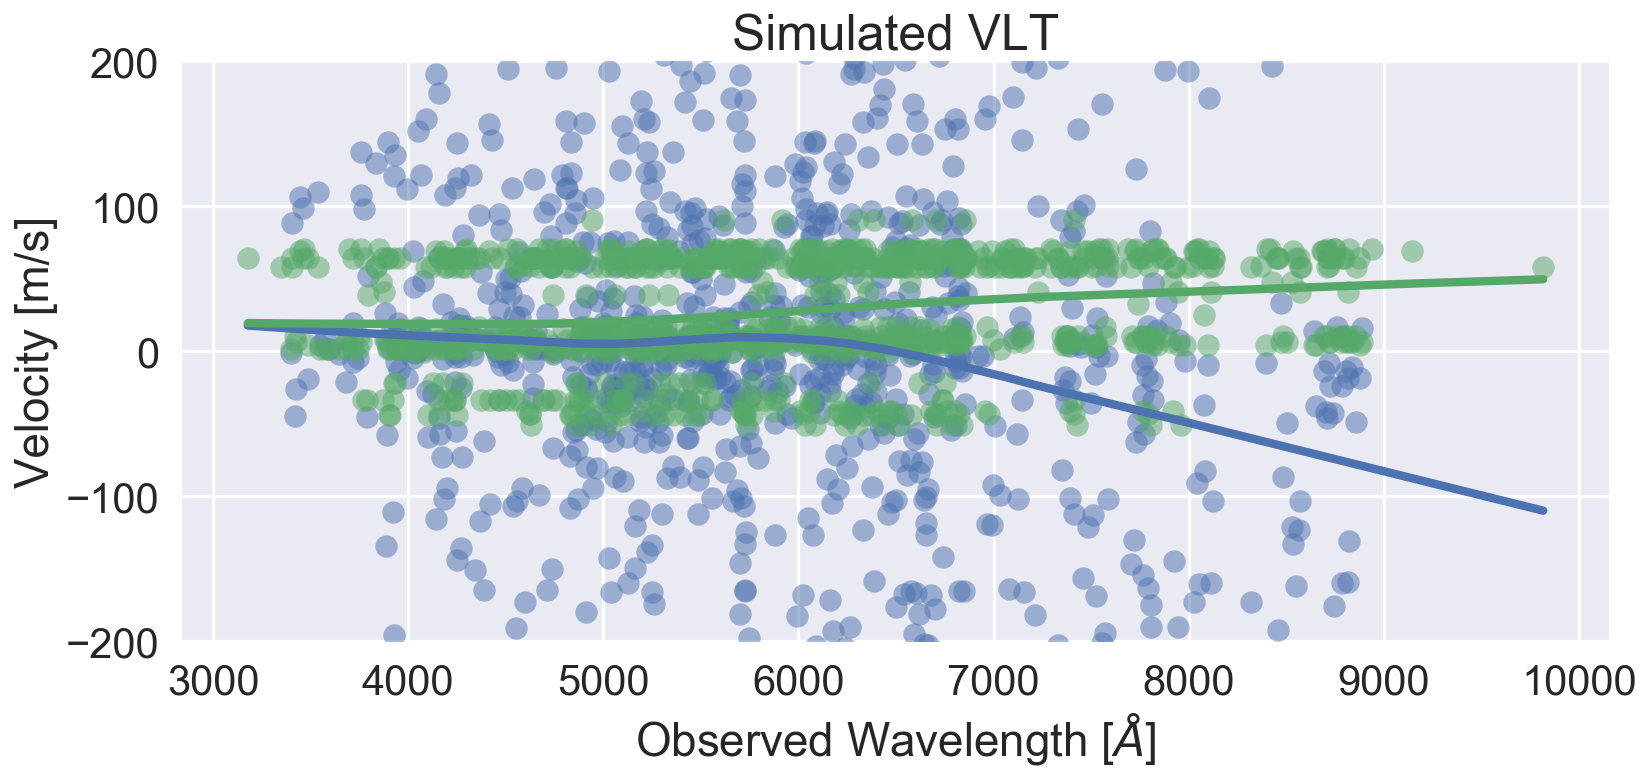

In [69]:
def simulated_shifts(telescope='VLT', use_dipole=True):
    waves = []
    shifts = []
    for index, row in all_systems[all_systems.source.eq(telescope)].iterrows():
        for tran in row['transitions'].split():
            rest_wave = qvals.loc[codes.loc[tran].trans].wave
            measured_wave = rest_wave * (1 + row.z_absorption)
            qval = qvals.loc[codes.loc[tran].trans].qval
            waves.append(measured_wave)
#             da = row.delta_alpha
            if use_dipole:
                da = row['dipole_delta_alpha']
            else:
                da = -3.0
            shifts.append(shifted_velocity(da, qval, rest_wave))
    return np.array(waves), np.array(shifts)

plot_sim(use_dipole=False)

## Hypothesis test

I think that a non-parametric test for $\alpha$ would be to fit for all velocity shifts as independent shifts. 

The general procedure would be thus:

 - fit velocity shifts per wavelength region (with errors). 

#J2000   zem    zabs    da   eda sample source  sigflag  \
152  J004131-493611  3.24  2.2485 -12.3  6.72      D    VLT        3   

     imrotator                                         transition  
152          0  j1 j2 j3 j6 j7 j8 c1 d1 d2 e2 h1 h2 h3 l1 l2 k...

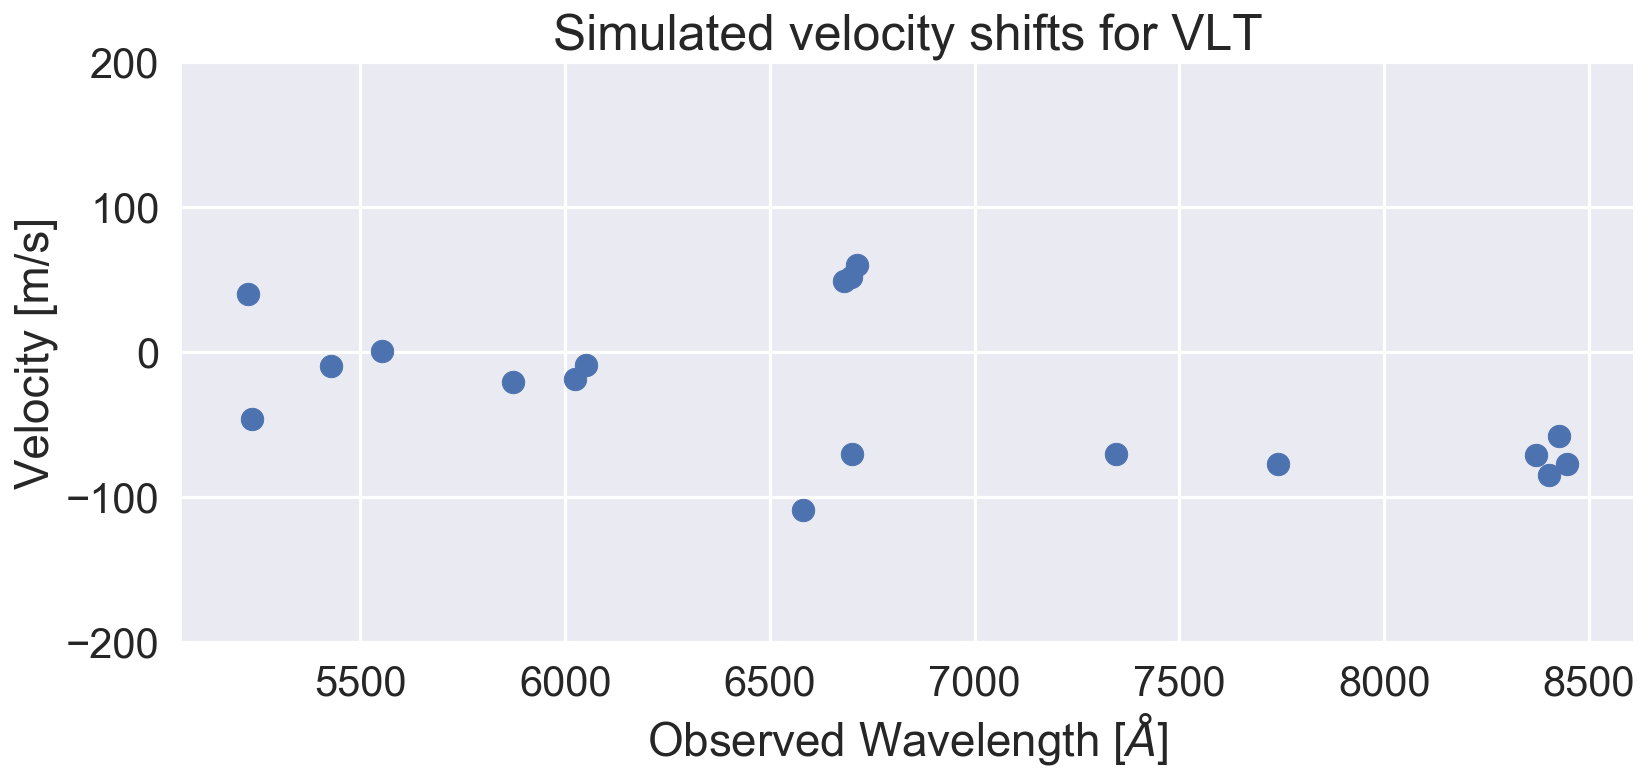

In [99]:
telescope = 'VLT'
row = all_systems[all_systems.source.eq(telescope)].sample(1,
                                                   random_state=2
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transitions'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.z_absorption)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.delta_alpha
#     if use_dipole:
    da = row['dipole_delta_alpha']
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)



fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)
ax.set_ylim(-200, 200)
# ax.legend()
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope)
fig.tight_layout()

In [ ]:
telescope = 'VLT'
row = all_systems[all_systems.source.eq(telescope)].sample(1,
                                                   random_state=2
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transitions'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.z_absorption)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.delta_alpha
#     if use_dipole:
    da = row['dipole_delta_alpha']
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)



fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)
ax.set_ylim(-200, 200)
# ax.legend()
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope + " " + str(np.round(da, 2)))
fig.tight_layout()

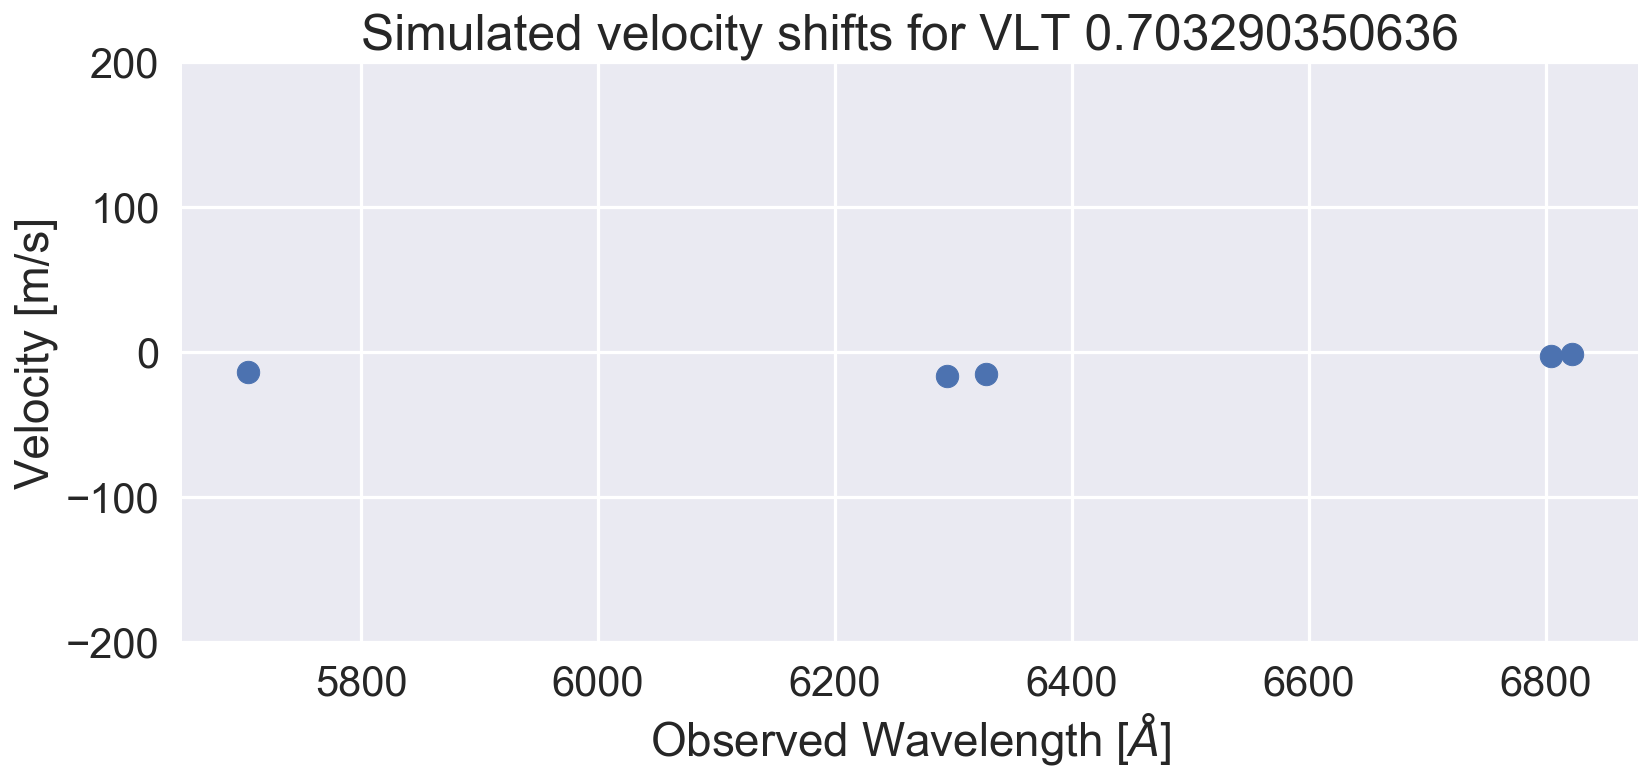

In [113]:
telescope = 'VLT'
row = all_systems[all_systems.source.eq(telescope)].sample(1,
                                                   random_state=3
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transitions'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.z_absorption)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
#             da = row.delta_alpha
#     if use_dipole:
    da = row['dipole_delta_alpha']
#     else:
#         da = -3.0
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)



fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)
ax.set_ylim(-200, 200)
# ax.legend()
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope + " " + str(da))
fig.tight_layout()

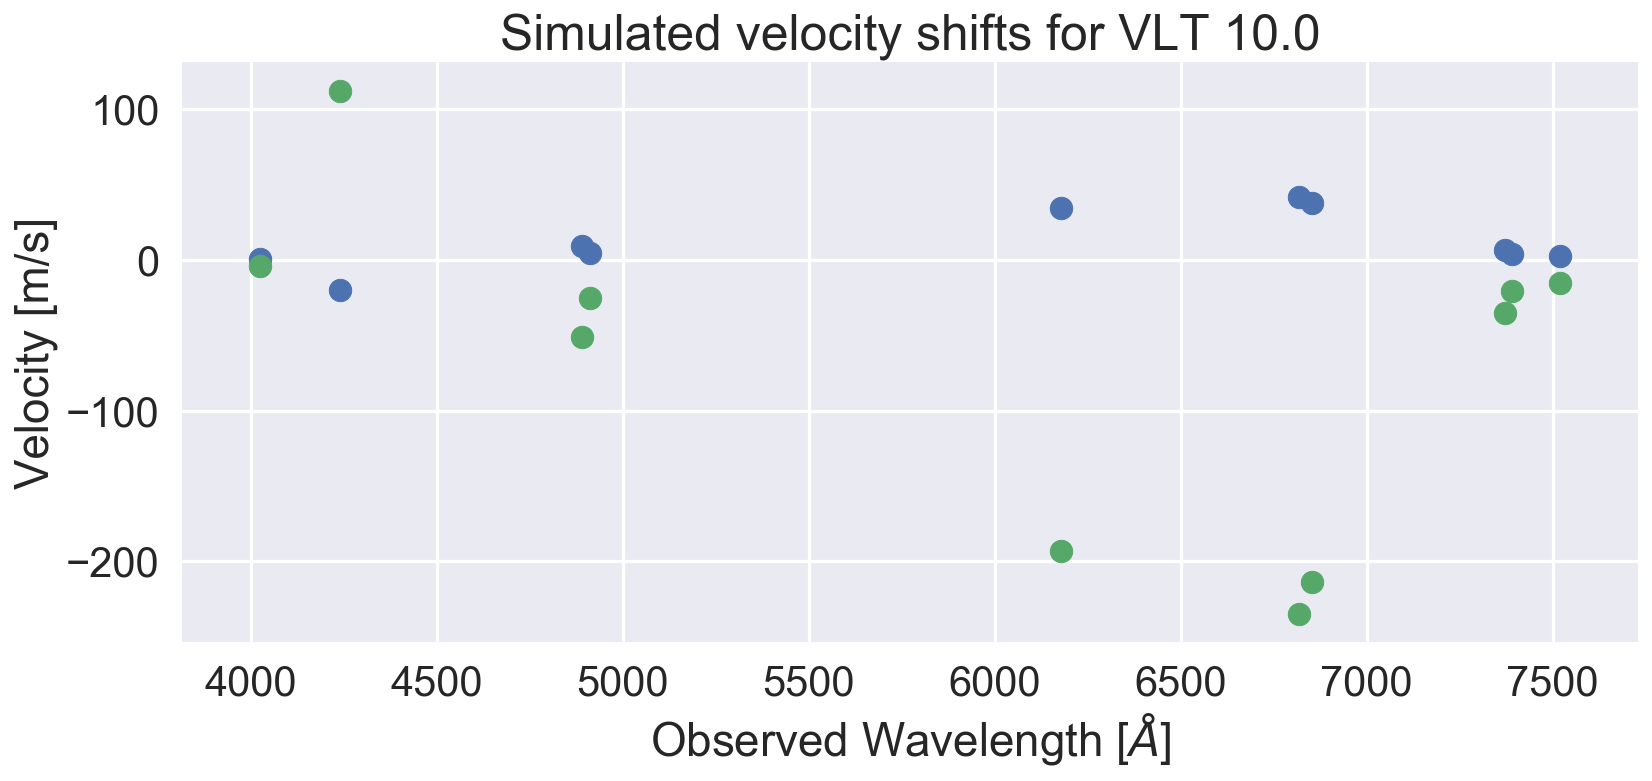

In [112]:
telescope = 'VLT'
row = all_systems[all_systems.source.eq(telescope)].sample(1,
                                                   random_state=8
                                                  ).iloc[0]
waves = []
shifts = []
for tran in row['transitions'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.z_absorption)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
    da = row['dipole_delta_alpha']
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)


fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(wav, shift)

waves = []
shifts = []
for tran in row['transitions'].split():
    rest_wave = qvals.loc[codes.loc[tran].trans].wave
    measured_wave = rest_wave * (1 + row.z_absorption)
    qval = qvals.loc[codes.loc[tran].trans].qval
    waves.append(measured_wave)
    da = row.delta_alpha
    shifts.append(shifted_velocity(da, qval, rest_wave))
wav, shift = np.array(waves), np.array(shifts)

ax.scatter(wav, shift)
ax.set_xlabel(r"Observed Wavelength [$\AA$]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title('Simulated velocity shifts for ' + telescope + " " + str(da))
fig.tight_layout()

In [222]:
#  Todo consider including the outliers stripped via the LTS method
# # Outliers http://astronomy.swin.edu.au/~mmurphy/files/KingJ_12a_VLT+Keck.dat
# 127   J194454+770552     3.02    2.8433     -4.959     1.334    C          Keck    1             1
# http://astronomy.swin.edu.au/~mmurphy/MurphyM_09a.dat
# -          -     2.8433  dgl              -4.959 1.334 0.000  0.149 0.000 C

# 145   J000448-415728     2.76    1.5419     -5.270     0.906    D          VLT     3             1
# TableA1 
# b1b2j4j5j6j7j8